In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
from scipy import stats
from scipy.optimize import minimize_scalar
from typing import Dict, List, Optional, Tuple, Any

from limference import (
    LIMference, 
    LIMConfig,
    ParameterConfig,
    calculate_statistics,
    create_corner_plot
)

class SBIConvergenceTester:
    """
    General class for testing any SBI method with convergence analysis.
    Works with any set of parameters specified by the user.
    
    Data Split Strategy:
    -------------------
    - Training: indices [0:n_train]
    - Test (calibration): indices [n_train:n_train+n_calibration]
    - Test (validation): indices [n_train+n_calibration:n_train+n_test]
    
    Dependencies:
    ------------
    Required: numpy, torch, scipy, matplotlib, limference
    Optional: arviz (for MCMC diagnostics), sklearn (for isotonic calibration)
    """
    
    def __init__(
        self,
        param_names: List[str],
        param_labels: Optional[Dict[str, str]] = None,
        inference_methods: List[str] = ["NPE"],
        analysis_methods: List[str] = ["pdf"],
        n_train: int = 2000,
        n_test: int = 500,
        n_calibration: int = 50,
        config_kwargs: Optional[Dict] = None,
        test_obs_idx: int = 0,
        check_dependencies: bool = True
    ):
        """Initialize tester with flexible parameter specification."""
        self.param_names = param_names
        self.n_params = len(param_names)
        
        if param_labels is None:
            self.param_labels = self._create_default_labels(param_names)
        else:
            self.param_labels = param_labels
            for name in param_names:
                if name not in self.param_labels:
                    self.param_labels[name] = self._create_default_labels([name])[name]
        
        self.inference_methods = inference_methods
        self.analysis_methods = analysis_methods
        self.n_train = n_train
        self.n_test = n_test
        self.n_calibration = n_calibration
        self.config_kwargs = config_kwargs or {}
        
        self.data_loaded = False
        self.models_trained = False
        self.results = {}
        self.test_obs_idx = test_obs_idx
        
        # Check optional dependencies if requested
        if check_dependencies:
            self._check_dependencies()
    
    def _check_dependencies(self):
        """Check for optional dependencies and warn if missing."""
        optional_deps = {
            'arviz': 'MCMC diagnostics (run_mcmc_diagnostics)',
            'sklearn': 'Isotonic calibration (calibrate_posteriors with method="isotonic")',
            'sbi.diagnostics.lc2st': 'LC2ST diagnostics (run_lc2st_diagnostic)',
            'sbi.analysis': 'Advanced analysis (active subspace, conditional distributions)'
        }
        
        self.available_features = {}
        
        for dep, feature in optional_deps.items():
            try:
                if '.' in dep:
                    # Handle nested imports
                    parts = dep.split('.')
                    mod = __import__(parts[0])
                    for part in parts[1:]:
                        mod = getattr(mod, part)
                else:
                    __import__(dep)
                self.available_features[dep] = True
            except ImportError:
                self.available_features[dep] = False
                print(f"Optional dependency '{dep}' not found. Feature disabled: {feature}")
    
    def _create_default_labels(self, names: List[str]) -> Dict[str, str]:
        """Create default LaTeX labels for common parameter names."""
        default_labels = {
            'omega_m': r'$\Omega_m$',
            'Omega_m': r'$\Omega_m$',
            'h': r'$h$',
            'sigma8': r'$\sigma_8$',
            'sigma_8': r'$\sigma_8$',
        }
        
        labels = {}
        for name in names:
            if name in default_labels:
                labels[name] = default_labels[name]
            else:
                labels[name] = name.replace('_', ' ')
        
        return labels
    
    def load_data(self, sim_root: str, seed: int = 1, param_file_keys: Optional[Dict[str, str]] = None):
        """Load simulation data with flexible parameter extraction."""
        print(f"Loading data from {sim_root}...")
        
        ps_file = np.load(sim_root + f"ps_80_256.npz", allow_pickle=True)
        pdf_file = np.load(sim_root + f"pdf_80_256.npz", allow_pickle=True)
        
        self.params_sims = ps_file["parameters"]
        self.k_sim = ps_file["k_2d"]
        self.pk_sim = ps_file["pk_2d"]
        self.bin_sim_linear = pdf_file["lim_bin_edges_linear_2d"]
        self.pdf_sim_linear = pdf_file["lim_pdf_linear_2d"]
        
        self.params_array = self._extract_parameters(self.params_sims, param_file_keys)
        
        # Keep all data accessible
        self.all_params = self.params_array
        self.all_pk = self.pk_sim
        self.all_pdf = self.pdf_sim_linear
        
        # Split data according to documented strategy
        self.train_params = self.params_array[:self.n_train]
        self.train_pk = self.pk_sim[:self.n_train]
        self.train_pdf = self.pdf_sim_linear[:self.n_train]
        
        self.test_params = self.params_array[self.n_train:self.n_train+self.n_test]
        self.test_pk = self.pk_sim[self.n_train:self.n_train+self.n_test]
        self.test_pdf = self.pdf_sim_linear[self.n_train:self.n_train+self.n_test]
        
        self.data_loaded = True
        
        print(f"Data loaded: {len(self.params_sims)} total simulations")
        print(f"Training set: {self.n_train} samples (indices 0:{self.n_train})")
        print(f"Test set: {self.n_test} samples (indices {self.n_train}:{self.n_train+self.n_test})")
        print(f"  - Calibration: {self.n_calibration} samples")
        print(f"  - Validation: {self.n_test - self.n_calibration} samples")
        print(f"Parameters being constrained: {', '.join(self.param_names)}")
        print(f"Parameter ranges:")
        for i, name in enumerate(self.param_names):
            print(f"  {name}: [{self.params_array[:, i].min():.3f}, {self.params_array[:, i].max():.3f}]")
    
    def _extract_parameters(self, params_sims: Any, param_file_keys: Optional[Dict[str, str]] = None) -> np.ndarray:
        """Extract specified parameters from simulation data."""
        if param_file_keys is None:
            param_file_keys = {}
        
        params_list = []
        
        if hasattr(params_sims, 'dtype') and params_sims.dtype.names:
            for sim_params in params_sims:
                param_values = []
                
                for param_name in self.param_names:
                    if param_name == "sigma8":
                        if "sigma_8" in params_sims.dtype.names:
                            value = sim_params["sigma_8"]
                        elif "sigma8" in params_sims.dtype.names:
                            value = sim_params["sigma8"]
                        else:
                            raise KeyError(f"Could not find sigma8. Available: {params_sims.dtype.names}")
                    
                    elif param_name == "omega_m":
                        if "omega_m" in params_sims.dtype.names:
                            value = sim_params["omega_m"]
                        elif "Omega_m" in params_sims.dtype.names:
                            value = sim_params["Omega_m"]
                        else:
                            raise KeyError(f"Could not find omega_m. Available: {params_sims.dtype.names}")
                    
                    else:
                        file_key = param_file_keys.get(param_name, param_name)
                        if file_key in params_sims.dtype.names:
                            value = sim_params[file_key]
                        elif param_name in params_sims.dtype.names:
                            value = sim_params[param_name]
                        else:
                            raise KeyError(f"Could not find '{param_name}'. Available: {params_sims.dtype.names}")
                    
                    param_values.append(float(value))
                
                params_list.append(param_values)
        else:
            for sim_params in params_sims:
                param_values = []
                for param_name in self.param_names:
                    file_key = param_file_keys.get(param_name, param_name)
                    if file_key in sim_params:
                        value = sim_params[file_key]
                    elif param_name in sim_params:
                        value = sim_params[param_name]
                    else:
                        raise KeyError(f"Could not find parameter '{param_name}'")
                    param_values.append(value)
                params_list.append(param_values)
        
        return np.array(params_list)
    
    def setup_limference(self, output_root: str, training_kwargs: Optional[Dict] = None):
        """Initialize LIMference with configuration."""
        if not self.data_loaded:
            raise ValueError("Load data first using load_data()")
        
        default_training = {
            "max_num_epochs": 400,
            "stop_after_epochs": 30,
            "training_batch_size": 100,
            "learning_rate": 5e-4,
            "validation_fraction": 0.2,
        }
        
        if training_kwargs:
            default_training.update(training_kwargs)
        
        default_config = {
            "root": output_root,
            "n_signal_sims": self.n_train + self.n_test,
            "num_noise_simulations": 1,
            "inference_methods": self.inference_methods,
            "analysis_methods": self.analysis_methods,
            "device": "cuda" if torch.cuda.is_available() else "cpu",
            **default_training
        }
        default_config.update(self.config_kwargs)
        
        self.config = LIMConfig(**default_config)
        
        param_ranges = {}
        for i, name in enumerate(self.param_names):
            param_ranges[name] = (
                float(self.params_array[:, i].min()),
                float(self.params_array[:, i].max())
            )
        
        self.param_config = ParameterConfig(
            param_names=self.param_names,
            param_ranges=param_ranges,
            param_labels=self.param_labels
        )
        
        self.lim = LIMference(self.config, param_config=self.param_config)
        
        # Load ALL data (train + test) into LIMference
        self.lim.parameters = np.vstack([self.train_params, self.test_params])
        
        simulations = {}
        
        # Handle combined PS+PDF
        if "combined_ps_pdf" in self.analysis_methods:
            # Ensure we have k array
            if len(self.k_sim.shape) == 1:
                k_array = self.k_sim
            else:
                k_array = self.k_sim[0] if len(self.k_sim.shape) > 1 else self.k_sim
            
            # Store individual components for later use
            simulations["power_spectrum"] = {
                "k": k_array,
                "pk": np.vstack([self.train_pk, self.test_pk])
            }
            
            simulations["pdf"] = {
                "bins_linear": self.bin_sim_linear,
                "pdf_linear": np.vstack([self.train_pdf, self.test_pdf])
            }
            
            # Create combined data
            combined_data = np.concatenate([
                simulations["power_spectrum"]["pk"],
                simulations["pdf"]["pdf_linear"]
            ], axis=1)
            
            simulations["combined_ps_pdf"] = combined_data
        
        # Load individual methods if requested
        for method in self.analysis_methods:
            if method == "pdf" and method not in simulations:
                simulations["pdf"] = {
                    "bins_linear": self.bin_sim_linear,
                    "pdf_linear": np.vstack([self.train_pdf, self.test_pdf])
                }
            elif method == "power_spectrum" and method not in simulations:
                if len(self.k_sim.shape) == 1:
                    k_array = self.k_sim
                else:
                    k_array = self.k_sim[0] if len(self.k_sim.shape) > 1 else self.k_sim
                
                simulations["power_spectrum"] = {
                    "k": k_array,
                    "pk": np.vstack([self.train_pk, self.test_pk])
                }
        
        self.lim.simulations = simulations
        
        print(f"LIMference initialized for methods: {self.inference_methods}")
        print(f"Analysis methods: {self.analysis_methods}")
        print(f"Parameters to constrain: {', '.join(self.param_names)}")
    
    def train_models(self):
        """Train SBI models."""
        if not hasattr(self, 'lim'):
            raise ValueError("Setup LIMference first using setup_limference()")
        
        print("\n" + "="*70)
        print("TRAINING MODELS")
        print("="*70)
        
        # FIXED: Use self.test_obs_idx instead of test_obs_idx
        combined_test_idx = self.n_train + self.test_obs_idx
        self.test_true_params = self.test_params[self.test_obs_idx]
        
        print(f"\nTest observation index: {self.test_obs_idx}")
        print(f"Test observation true parameters:")
        for i, name in enumerate(self.param_names):
            print(f"  {name} = {self.test_true_params[i]:.3f}")
        
        try:
            self.lim_results = self.lim.run_inference_comparison(
                observation_index=combined_test_idx,
                analysis_methods=self.analysis_methods,
                inference_methods=self.inference_methods,
                n_posterior_samples=10000,
                verbose=True
            )
            
            self.models_trained = True
            self.lim.results = self.lim_results
            
        except Exception as e:
            print(f"Error during training: {e}")
            import traceback
            traceback.print_exc()
            self.models_trained = False
    
    def compare_estimation_methods(self):
        """Compare different parameter estimation methods across all trained models"""
        
        if not self.models_trained:
            print("No trained models to analyze")
            return None
        
        # Standardized test index usage
        test_idx = self.test_obs_idx
        
        print("\n" + "="*70)
        print("COMPARING PARAMETER ESTIMATION METHODS")
        print(f"Using test observation index: {test_idx}")
        print("="*70)
        
        comparison_results = {}
        
        for method_key, result in self.lim.results.items():
            if "error" in result:
                continue
            
            print(f"\n{method_key}:")
            print("-"*50)
            
            # Get observation for this method
            if "combined" in method_key:
                test_obs = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
            elif "power" in method_key:
                test_obs = self.test_pk[test_idx]
            elif "pdf" in method_key:
                test_obs = self.test_pdf[test_idx]
            else:
                continue
            
            # Get comprehensive estimates
            estimates, samples = self.estimate_parameters_comprehensive(
                result['posterior'], test_obs, n_samples=10000
            )
            
            # Store results
            comparison_results[method_key] = estimates
            
            # Print comparison
            true_params = self.test_params[test_idx]
            
            print(f"\nTrue values:     {self.param_names[0]}={true_params[0]:.4f}, "
                  f"{self.param_names[1]}={true_params[1]:.4f}")
            
            print("\nPoint Estimates:")
            for estimator in ['mean', 'median', 'mode_kde', 'map']:
                if estimates[estimator] is not None:
                    est_vals = estimates[estimator]
                    errors = est_vals - true_params
                    print(f"  {estimator:8s}: {self.param_names[0]}={est_vals[0]:.4f} (err={errors[0]:+.4f}), "
                          f"{self.param_names[1]}={est_vals[1]:.4f} (err={errors[1]:+.4f})")
            
            print("\nUncertainties:")
            print(f"  Std Dev:  {self.param_names[0]}={estimates['std'][0]:.4f}, "
                  f"{self.param_names[1]}={estimates['std'][1]:.4f}")
            print(f"  MAD:      {self.param_names[0]}={estimates['mad'][0]:.4f}, "
                  f"{self.param_names[1]}={estimates['mad'][1]:.4f}")
            
            print("\n68% HPD Intervals:")
            for i, name in enumerate(self.param_names):
                hpd = estimates['hpd_68'][i]
                width = hpd[1] - hpd[0]
                print(f"  {name}: [{hpd[0]:.4f}, {hpd[1]:.4f}] (width={width:.4f})")
            
            print("\nMultimodality Check:")
            for i, name in enumerate(self.param_names):
                status = "Yes ⚠️" if estimates['is_multimodal'][i] else "No ✓"
                print(f"  {name}: {status}")
            
            # Calculate RMSE for each estimator
            print("\nRMSE by Estimator:")
            for estimator in ['mean', 'median', 'mode_kde', 'map']:
                if estimates[estimator] is not None:
                    rmse = np.sqrt(np.mean((estimates[estimator] - true_params)**2))
                    print(f"  {estimator:8s}: {rmse:.4f}")
        
        return comparison_results
    
    def plot_estimation_comparison(self):
        """Visualize different estimation methods"""
        
        # Standardized test index usage
        test_idx = self.test_obs_idx
        
        comparison = self.compare_estimation_methods()
        if not comparison:
            return
        
        n_methods = len(comparison)
        n_params = len(self.param_names)
        
        # FIXED: Use constrained_layout in figure creation
        fig, axes = plt.subplots(n_params, n_methods, 
                                 figsize=(5*n_methods, 4*n_params),
                                 constrained_layout=True)
        
        if n_methods == 1:
            axes = axes.reshape(-1, 1)
        if n_params == 1:
            axes = axes.reshape(1, -1)
        
        for j, (method_key, estimates) in enumerate(comparison.items()):
            # Get samples for this method
            if "combined" in method_key:
                test_obs = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
            elif "power" in method_key:
                test_obs = self.test_pk[test_idx]
            elif "pdf" in method_key:
                test_obs = self.test_pdf[test_idx]
            else:
                continue
            
            x_obs_tensor = torch.tensor(test_obs, dtype=torch.float32)
            samples = self.lim.results[method_key]['posterior'].sample(
                (5000,), x=x_obs_tensor
            ).numpy()
            
            for i, param_name in enumerate(self.param_names):
                ax = axes[i, j] if n_params > 1 else axes[j]
                
                # Plot histogram
                ax.hist(samples[:, i], bins=50, density=True, 
                       alpha=0.5, color='gray', edgecolor='black')
                
                # Add KDE
                from scipy.stats import gaussian_kde
                kde = gaussian_kde(samples[:, i])
                x_grid = np.linspace(samples[:, i].min(), samples[:, i].max(), 200)
                ax.plot(x_grid, kde(x_grid), 'k-', linewidth=2, label='KDE')
                
                # Mark different estimates
                true_val = self.test_params[test_idx][i]
                ax.axvline(true_val, color='red', linestyle='--', 
                          linewidth=2, label='True')
                
                colors = {'mean': 'blue', 'median': 'green', 
                         'mode_kde': 'orange', 'map': 'purple'}
                
                for est_name, color in colors.items():
                    if estimates[est_name] is not None:
                        ax.axvline(estimates[est_name][i], color=color, 
                                  linestyle=':', linewidth=1.5, label=est_name)
                
                ax.set_xlabel(self.param_labels[param_name])
                ax.set_ylabel('Density')
                ax.set_title(f'{method_key}\n{param_name}')
                
                if i == 0 and j == 0:
                    ax.legend(fontsize=8, loc='best')
                
                # Add text box with stats
                multimodal = "Multi" if estimates['is_multimodal'][i] else "Uni"
                textstr = f"{multimodal}modal"
                ax.text(0.05, 0.95, textstr, transform=ax.transAxes, 
                       fontsize=9, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.suptitle('Parameter Estimation Methods Comparison', fontsize=14)
        plt.show()
    
    def calibrate_posteriors(self, target_coverage: float = 0.68, method: str = "temperature"):
        """
        Calibrate posteriors using temperature scaling and/or isotonic regression.

        Parameters:
        -----------
        target_coverage : float
            Target coverage level for calibration (default 0.68)
        method : str
            Calibration method:
            - "temperature": Scale uncertainties using temperature parameter
            - "isotonic": Use isotonic regression for calibration curve
            - "both": Apply both methods sequentially (temperature first, then isotonic)
            
        Note: "isotonic" requires sklearn to be installed.
        """
        if not self.models_trained:
            raise ValueError("Train models first")

        print("\n" + "="*50)
        print("CALIBRATING POSTERIORS")
        print(f"Method: {method}")
        print("="*50)

        # Check isotonic availability
        if method in ["isotonic", "both"]:
            if not self.available_features.get('sklearn', False):
                print("WARNING: sklearn not available. Falling back to temperature-only calibration.")
                method = "temperature"

        # Helper function for temperature scaling
        def calibrate_temperature(posterior, cal_data, cal_params, target=0.68):
            def coverage_error(temp):
                coverage = 0
                n_cal = min(30, len(cal_data))

                for i in range(n_cal):
                    try:
                        x_obs = torch.tensor(cal_data[i], dtype=torch.float32)
                        samples = posterior.sample((300,), x=x_obs).numpy()

                        mean = np.mean(samples, axis=0)
                        scaled = mean + (samples - mean) * temp

                        q16, q84 = np.percentile(scaled, [16, 84], axis=0)
                        if np.all((cal_params[i] >= q16) & (cal_params[i] <= q84)):
                            coverage += 1
                    except:
                        continue

                return abs(coverage/n_cal - target) if n_cal > 0 else 1.0

            result = minimize_scalar(coverage_error, bounds=(0.5, 3.0), method='bounded')
            return result.x

        # Helper function for isotonic regression
        def calibrate_isotonic(posterior, cal_data, cal_params):
            from sklearn.isotonic import IsotonicRegression

            print("  Building isotonic calibration curve...")

            # Collect calibration data at different confidence levels
            confidence_levels = np.linspace(0.1, 0.99, 20)
            predicted_coverages = []
            empirical_coverages = []

            for conf_level in confidence_levels:
                coverage_count = 0
                n_valid = 0

                for i in range(min(50, len(cal_data))):
                    try:
                        x_obs = torch.tensor(cal_data[i], dtype=torch.float32)
                        samples = posterior.sample((500,), x=x_obs).numpy()

                        # Calculate confidence interval
                        lower_percentile = (1 - conf_level) / 2 * 100
                        upper_percentile = (1 + conf_level) / 2 * 100
                        ci_low = np.percentile(samples, lower_percentile, axis=0)
                        ci_high = np.percentile(samples, upper_percentile, axis=0)

                        # Check if true parameter is within CI
                        if np.all((cal_params[i] >= ci_low) & (cal_params[i] <= ci_high)):
                            coverage_count += 1
                        n_valid += 1
                    except:
                        continue

                if n_valid > 0:
                    predicted_coverages.append(conf_level)
                    empirical_coverages.append(coverage_count / n_valid)

            # Fit isotonic regression
            iso_reg = IsotonicRegression(out_of_bounds='clip', increasing=True)
            iso_reg.fit(predicted_coverages, empirical_coverages)

            # Create calibration function
            def apply_isotonic_calibration(samples, confidence_level):
                """Apply isotonic calibration to adjust confidence intervals."""
                target_empirical = confidence_level

                # Binary search for the right nominal level
                low, high = 0.01, 0.99
                for _ in range(20):
                    mid = (low + high) / 2
                    empirical = iso_reg.predict([mid])[0]
                    if empirical < target_empirical:
                        low = mid
                    else:
                        high = mid

                # Use the calibrated confidence level
                calibrated_level = mid
                lower_percentile = (1 - calibrated_level) / 2 * 100
                upper_percentile = (1 + calibrated_level) / 2 * 100

                return np.percentile(samples, [lower_percentile, upper_percentile], axis=0)

            return iso_reg, apply_isotonic_calibration

        # Apply calibration to each method
        for method_key, result in self.lim.results.items():
            if "error" not in result:
                # Prepare calibration data
                if "combined" in method_key:
                    cal_pk = self.test_pk[:self.n_calibration]
                    cal_pdf = self.test_pdf[:self.n_calibration]
                    cal_data = np.concatenate([cal_pk, cal_pdf], axis=1)
                elif "power" in method_key:
                    cal_data = self.test_pk[:self.n_calibration]
                elif "pdf" in method_key:
                    cal_data = self.test_pdf[:self.n_calibration]
                else:
                    continue

                cal_params = self.test_params[:self.n_calibration]

                # Apply temperature scaling
                if method in ["temperature", "both"]:
                    try:
                        temp = calibrate_temperature(
                            result['posterior'], cal_data, cal_params, target_coverage
                        )
                        result['calibration_temp'] = temp
                        print(f"{method_key} - Temperature scaling: T = {temp:.3f}")

                        if temp > 1.2:
                            print(f"  → Model was overconfident, widening by {(temp-1)*100:.1f}%")
                        elif temp < 0.8:
                            print(f"  → Model was underconfident, narrowing by {(1-temp)*100:.1f}%")
                        else:
                            print(f"  → Model was well-calibrated")
                    except Exception as e:
                        print(f"{method_key} - Temperature calibration failed: {e}")
                        result['calibration_temp'] = 1.0

                # Apply isotonic regression
                if method in ["isotonic", "both"]:
                    try:
                        iso_reg, iso_apply = calibrate_isotonic(
                            result['posterior'], cal_data, cal_params
                        )
                        result['isotonic_calibrator'] = iso_reg
                        result['isotonic_apply'] = iso_apply

                        # Test the calibration
                        test_levels = [0.68, 0.95]
                        calibrated_levels = iso_reg.predict(test_levels)
                        print(f"{method_key} - Isotonic regression calibration:")
                        for nominal, empirical in zip(test_levels, calibrated_levels):
                            print(f"  → {nominal*100:.0f}% nominal → {empirical*100:.1f}% empirical")

                    except Exception as e:
                        print(f"{method_key} - Isotonic calibration failed: {e}")
                        result['isotonic_calibrator'] = None
    
    def test_recovery(self):
        """Test posterior recovery on test set."""
        if not self.models_trained:
            raise ValueError("Train models first")
        
        print("\n" + "="*50)
        print("TESTING POSTERIOR RECOVERY")
        print("="*50)
        
        recovery_results = {}
        
        for method_key, result in self.lim.results.items():
            if "error" not in result:
                print(f"\n{method_key}:")
                
                if "combined" in method_key:
                    test_pk = self.test_pk[self.n_calibration:]
                    test_pdf = self.test_pdf[self.n_calibration:]
                    test_data = np.concatenate([test_pk, test_pdf], axis=1)
                elif "power" in method_key:
                    test_data = self.test_pk[self.n_calibration:]
                elif "pdf" in method_key:
                    test_data = self.test_pdf[self.n_calibration:]
                else:
                    continue
                
                test_params_subset = self.test_params[self.n_calibration:]
                
                n_test_samples = min(50, len(test_data))
                coverage_68 = 0
                coverage_95 = 0
                errors = []
                
                temp = result.get('calibration_temp', 1.0)
                
                for i in range(n_test_samples):
                    try:
                        x_obs = torch.tensor(test_data[i], dtype=torch.float32)
                        samples = result['posterior'].sample((1000,), x=x_obs).numpy()
                        
                        mean = np.mean(samples, axis=0)
                        samples = mean + (samples - mean) * temp
                        
                        post_mean = np.mean(samples, axis=0)
                        errors.append(post_mean - test_params_subset[i])
                        
                        q16, q84 = np.percentile(samples, [16, 84], axis=0)
                        q2_5, q97_5 = np.percentile(samples, [2.5, 97.5], axis=0)
                        
                        if np.all((test_params_subset[i] >= q16) & (test_params_subset[i] <= q84)):
                            coverage_68 += 1
                        if np.all((test_params_subset[i] >= q2_5) & (test_params_subset[i] <= q97_5)):
                            coverage_95 += 1
                            
                    except Exception as e:
                        continue
                
                if len(errors) > 0:
                    errors = np.array(errors)
                    metrics = {
                        'coverage_68_rate': coverage_68 / n_test_samples,
                        'coverage_95_rate': coverage_95 / n_test_samples,
                        'mean_rmse': np.sqrt(np.mean(errors**2)),
                        'mean_bias': np.mean(np.abs(errors)),
                        'well_calibrated_68': abs(coverage_68/n_test_samples - 0.68) < 0.1,
                        'well_calibrated_95': abs(coverage_95/n_test_samples - 0.95) < 0.1,
                        'calibration_temp': temp
                    }
                    recovery_results[method_key] = metrics
                    
                    print(f"  Temperature: {metrics['calibration_temp']:.3f}")
                    print(f"  68% coverage: {metrics['coverage_68_rate']:.1%}")
                    print(f"  95% coverage: {metrics['coverage_95_rate']:.1%}")
                    print(f"  RMSE: {metrics['mean_rmse']:.4f}")
        
        self.recovery_results = recovery_results
    
    def plot_results(self):
        """Create comprehensive visualization of results."""
        if not self.models_trained:
            raise ValueError("Train models first")
        
        self._plot_parameter_recovery()
        self._plot_coverage_curves()
    
    def _plot_coverage_curves(self):
        """Plot coverage calibration curves."""
        confidence_levels = np.array([50, 60, 70, 80, 90, 95, 99])
        
        n_methods = len([k for k in self.lim.results.keys() if "error" not in self.lim.results[k]])
        if n_methods == 0:
            return
        
        # FIXED: Use constrained_layout
        fig, axes = plt.subplots(1, n_methods, figsize=(5*n_methods, 4),
                                constrained_layout=True)
        if n_methods == 1:
            axes = [axes]
        
        plot_idx = 0
        
        for method_key, result in self.lim.results.items():
            if "error" not in result:
                ax = axes[plot_idx]
                
                start_idx = self.n_calibration
                end_idx = min(self.n_calibration + 30, self.n_test)
                
                if "combined" in method_key:
                    test_pk = self.test_pk[start_idx:end_idx]
                    test_pdf = self.test_pdf[start_idx:end_idx]
                    test_data = np.concatenate([test_pk, test_pdf], axis=1)
                elif "power" in method_key:
                    test_data = self.test_pk[start_idx:end_idx]
                elif "pdf" in method_key:
                    test_data = self.test_pdf[start_idx:end_idx]
                else:
                    continue
                
                test_params_subset = self.test_params[start_idx:end_idx]
                
                coverage_rates_orig = []
                coverage_rates_cal = []
                
                temp = result.get('calibration_temp', 1.0)
                
                for conf in confidence_levels:
                    coverage_orig = 0
                    coverage_cal = 0
                    n_samples = len(test_data)
                    
                    for i in range(n_samples):
                        try:
                            x_obs = torch.tensor(test_data[i], dtype=torch.float32)
                            samples = result['posterior'].sample((500,), x=x_obs).numpy()
                            
                            lower = (100-conf)/2
                            upper = 100-lower
                            
                            ci_low_orig = np.percentile(samples, lower, axis=0)
                            ci_high_orig = np.percentile(samples, upper, axis=0)
                            
                            mean = np.mean(samples, axis=0)
                            samples_cal = mean + (samples - mean) * temp
                            ci_low_cal = np.percentile(samples_cal, lower, axis=0)
                            ci_high_cal = np.percentile(samples_cal, upper, axis=0)
                            
                            if np.all((test_params_subset[i] >= ci_low_orig) & 
                                     (test_params_subset[i] <= ci_high_orig)):
                                coverage_orig += 1
                            if np.all((test_params_subset[i] >= ci_low_cal) & 
                                     (test_params_subset[i] <= ci_high_cal)):
                                coverage_cal += 1
                        except:
                            continue
                    
                    if n_samples > 0:
                        coverage_rates_orig.append(100 * coverage_orig/n_samples)
                        coverage_rates_cal.append(100 * coverage_cal/n_samples)
                
                if coverage_rates_orig:
                    ax.plot(confidence_levels[:len(coverage_rates_orig)], coverage_rates_orig, 'o-', 
                           label='Original', linewidth=2, color='red')
                    ax.plot(confidence_levels[:len(coverage_rates_cal)], coverage_rates_cal, 's-', 
                           label='Calibrated', linewidth=2, color='green')
                    ax.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Perfect')
                    
                    ax.set_xlabel('Nominal Coverage (%)')
                    ax.set_ylabel('Empirical Coverage (%)')
                    ax.set_title(f'{method_key} (T={temp:.2f})')
                    ax.legend(fontsize=8)
                    ax.grid(True, alpha=0.3)
                    ax.set_xlim(45, 100)
                    ax.set_ylim(45, 100)
                
                plot_idx += 1
        
        if plot_idx > 0:
            plt.suptitle('Coverage Calibration', fontsize=14)
            plt.show()
    
    def _plot_parameter_recovery(self):
        """Plot parameter recovery scatter plots."""
        n_methods = len([k for k in self.lim.results.keys() if "error" not in self.lim.results[k]])
        n_params = len(self.param_names)
        
        if n_methods == 0:
            return
        
        # FIXED: Use constrained_layout
        fig, axes = plt.subplots(n_methods, n_params, 
                                figsize=(5*n_params, 4*n_methods),
                                constrained_layout=True)
        
        if n_methods == 1 and n_params == 1:
            axes = np.array([[axes]])
        elif n_methods == 1:
            axes = axes.reshape(1, -1)
        elif n_params == 1:
            axes = axes.reshape(-1, 1)
        
        method_idx = 0
        for method_key, result in self.lim.results.items():
            if "error" not in result:
                start_idx = self.n_calibration
                end_idx = min(self.n_calibration + 50, self.n_test)
                
                if "combined" in method_key:
                    test_pk = self.test_pk[start_idx:end_idx]
                    test_pdf = self.test_pdf[start_idx:end_idx]
                    test_data = np.concatenate([test_pk, test_pdf], axis=1)
                elif "power" in method_key:
                    test_data = self.test_pk[start_idx:end_idx]
                elif "pdf" in method_key:
                    test_data = self.test_pdf[start_idx:end_idx]
                else:
                    continue
                
                test_params_subset = self.test_params[start_idx:end_idx]
                temp = result.get('calibration_temp', 1.0)
                
                predictions_mean = []
                predictions_16 = []
                predictions_84 = []
                true_vals = []
                
                for i in range(len(test_data)):
                    try:
                        x_obs = torch.tensor(test_data[i], dtype=torch.float32)
                        samples = result['posterior'].sample((1000,), x=x_obs).numpy()
                        
                        mean = np.mean(samples, axis=0)
                        samples_cal = mean + (samples - mean) * temp
                        
                        predictions_mean.append(np.mean(samples_cal, axis=0))
                        predictions_16.append(np.percentile(samples_cal, 16, axis=0))
                        predictions_84.append(np.percentile(samples_cal, 84, axis=0))
                        true_vals.append(test_params_subset[i])
                    except:
                        continue
                
                if len(predictions_mean) == 0:
                    continue
                
                predictions_mean = np.array(predictions_mean)
                predictions_16 = np.array(predictions_16)
                predictions_84 = np.array(predictions_84)
                true_vals = np.array(true_vals)
                
                for param_idx in range(n_params):
                    ax = axes[method_idx, param_idx] if (n_methods > 1 or n_params > 1) else axes
                    
                    yerr_lower = predictions_mean[:, param_idx] - predictions_16[:, param_idx]
                    yerr_upper = predictions_84[:, param_idx] - predictions_mean[:, param_idx]
                    yerr = np.array([yerr_lower, yerr_upper])
                    
                    ax.errorbar(true_vals[:, param_idx], 
                               predictions_mean[:, param_idx],
                               yerr=yerr,
                               fmt='o', alpha=0.6, markersize=4,
                               elinewidth=0.5, capsize=2, capthick=0.5)
                    
                    lims = [true_vals[:, param_idx].min(), true_vals[:, param_idx].max()]
                    ax.plot(lims, lims, 'r--', alpha=0.7, linewidth=2)
                    
                    from scipy.stats import pearsonr
                    if len(true_vals[:, param_idx]) > 1:
                        r2 = pearsonr(true_vals[:, param_idx], predictions_mean[:, param_idx])[0]**2
                        rmse = np.sqrt(np.mean((true_vals[:, param_idx] - predictions_mean[:, param_idx])**2))
                    else:
                        r2 = 0
                        rmse = 0
                    
                    ax.set_xlabel(f'True {self.param_labels[self.param_names[param_idx]]}')
                    ax.set_ylabel(f'Predicted {self.param_labels[self.param_names[param_idx]]}')
                    ax.set_title(f'{method_key}\nR²={r2:.3f}, RMSE={rmse:.4f}')
                    ax.grid(True, alpha=0.3)
                
                method_idx += 1
        
        if method_idx > 0:
            plt.suptitle('Parameter Recovery', fontsize=14)
            plt.show()
    
    def estimate_parameters_comprehensive(self, posterior, x_obs, n_samples=10000):
        """Get multiple estimates for non-Gaussian posterior"""

        # Sample from posterior
        x_obs_tensor = torch.tensor(x_obs, dtype=torch.float32)
        samples = posterior.sample((n_samples,), x=x_obs_tensor).numpy()

        # Get various estimates
        estimates = {
            'mean': np.mean(samples, axis=0),
            'median': np.median(samples, axis=0),
            'mode_kde': self._get_mode_estimate(samples),
            'map': self._get_map_estimate(posterior, x_obs),
        }

        # Add uncertainties
        estimates['std'] = np.std(samples, axis=0)
        estimates['mad'] = np.median(np.abs(samples - estimates['median']), axis=0)

        # HPD intervals
        try:
            import arviz as az
            estimates['hpd_68'] = az.hdi(samples, hdi_prob=0.68)
            estimates['hpd_95'] = az.hdi(samples, hdi_prob=0.95)
        except ImportError:
            estimates['hpd_68'] = np.percentile(samples, [16, 84], axis=0).T
            estimates['hpd_95'] = np.percentile(samples, [2.5, 97.5], axis=0).T

        # Check for multimodality
        estimates['is_multimodal'] = self._check_multimodality(samples)

        return estimates, samples

    def _get_map_estimate(self, posterior, x_obs, n_init=50):
        """Find MAP estimate using optimization"""
        x_obs_tensor = torch.tensor(x_obs, dtype=torch.float32)

        # Sample initial points
        init_samples = posterior.sample((n_init,), x=x_obs_tensor)

        best_log_prob = -np.inf
        best_params = None

        for i in range(n_init):
            init = init_samples[i].clone().detach().requires_grad_(True)

            try:
                optimizer = torch.optim.LBFGS([init], lr=0.01, max_iter=100)

                def closure():
                    optimizer.zero_grad()
                    log_prob = posterior.log_prob(init.unsqueeze(0), x=x_obs_tensor)
                    loss = -log_prob
                    loss.backward()
                    return loss

                for _ in range(10):
                    optimizer.step(closure)

                final_log_prob = posterior.log_prob(init.unsqueeze(0), x=x_obs_tensor).item()
                if final_log_prob > best_log_prob:
                    best_log_prob = final_log_prob
                    best_params = init.detach().numpy()
            except:
                continue

        return best_params if best_params is not None else init_samples[0].numpy()

    def _get_mode_estimate(self, samples, n_grid=1000):
        """Estimate mode using kernel density estimation"""
        from scipy.stats import gaussian_kde

        modes = []
        for param_idx in range(samples.shape[1]):
            param_samples = samples[:, param_idx]

            # Fit KDE
            kde = gaussian_kde(param_samples)

            # Create grid and evaluate
            x_grid = np.linspace(param_samples.min(), param_samples.max(), n_grid)
            density = kde(x_grid)

            # Find mode
            mode_idx = np.argmax(density)
            modes.append(x_grid[mode_idx])

        return np.array(modes)

    def _check_multimodality(self, samples, threshold=0.1):
        """Check if posterior is multimodal"""
        from scipy.stats import gaussian_kde
        from scipy.signal import find_peaks

        is_multimodal = []

        for i in range(samples.shape[1]):
            kde = gaussian_kde(samples[:, i])
            x = np.linspace(samples[:, i].min(), samples[:, i].max(), 200)
            density = kde(x)

            # Find peaks
            peaks, properties = find_peaks(density, height=threshold*np.max(density))
            is_multimodal.append(len(peaks) > 1)

        return is_multimodal
    
    def run_sbc_analysis(self, n_sbc_runs: int = 100, n_posterior_samples: int = 1000):
        """Run proper SBC analysis with rank statistics."""
        ranks = {method: [] for method in self.lim.results.keys() if "error" not in self.lim.results[method]}

        for method_key, result in self.lim.results.items():
            if "error" in result:
                continue

            for _ in range(n_sbc_runs):
                # Sample from prior (using training data as approximation)
                idx = np.random.randint(0, self.n_train)
                true_param = self.train_params[idx]

                # Get corresponding observation based on method type
                if "combined" in method_key:
                    pk_obs = self.train_pk[idx]
                    pdf_obs = self.train_pdf[idx]
                    observation = np.concatenate([pk_obs, pdf_obs])
                elif "power" in method_key or "ps" in method_key:
                    observation = self.train_pk[idx]
                elif "pdf" in method_key:
                    observation = self.train_pdf[idx]
                else:
                    continue

                # Get posterior samples
                x_obs = torch.tensor(observation, dtype=torch.float32)
                samples = result['posterior'].sample((n_posterior_samples,), x=x_obs).numpy()

                # Calculate ranks for each parameter
                rank = np.sum(samples < true_param[None, :], axis=0) / n_posterior_samples
                ranks[method_key].append(rank)
    
        # Convert to arrays
        for method_key, method_ranks in ranks.items():
            ranks[method_key] = np.array(method_ranks)

        return ranks
    
    def plot_sbc_ranks(self, n_sbc_runs: int = 100, n_posterior_samples: int = 1000):
        """Run SBC analysis and create rank plots."""

        # First run the SBC analysis
        ranks = self.run_sbc_analysis(n_sbc_runs, n_posterior_samples)

        # Create plots for each method
        for method_key, method_ranks in ranks.items():
            if len(method_ranks) == 0:
                continue

            n_params = method_ranks.shape[1]
            # FIXED: Use constrained_layout
            fig, axes = plt.subplots(1, n_params, figsize=(6*n_params, 5),
                                    constrained_layout=True)

            if n_params == 1:
                axes = [axes]

            for param_idx, param_name in enumerate(self.param_names):
                ax = axes[param_idx]

                # Plot histogram of ranks
                n_bins = int(np.sqrt(n_sbc_runs)) if n_sbc_runs > 100 else 10
                counts, bins, _ = ax.hist(method_ranks[:, param_idx], 
                                         bins=n_bins, 
                                         density=True,
                                         alpha=0.7, 
                                         edgecolor='black',
                                         label='SBC ranks')

                # Add uniform reference line
                ax.axhline(1.0, color='red', linestyle='--', 
                          label='Expected (uniform)', linewidth=2)

                # Add confidence bands for uniform distribution
                n_samples = len(method_ranks[:, param_idx])
                std_uniform = 1 / np.sqrt(12)
                ci_width = 1.96 * std_uniform / np.sqrt(n_samples)
                ax.axhspan(1.0 - ci_width, 1.0 + ci_width, 
                          alpha=0.2, color='red', label='95% CI')

                # Run Kolmogorov-Smirnov test
                ks_stat, p_value = stats.kstest(method_ranks[:, param_idx], 'uniform')

                # Interpret the shape
                mean_rank = np.mean(method_ranks[:, param_idx])
                interpretation = ""
                if p_value < 0.05:
                    if mean_rank < 0.45:
                        interpretation = "Underconfident"
                    elif mean_rank > 0.55:
                        interpretation = "Overconfident"
                    else:
                        q1 = np.percentile(method_ranks[:, param_idx], 25)
                        q3 = np.percentile(method_ranks[:, param_idx], 75)
                        if q1 < 0.2 and q3 > 0.8:
                            interpretation = "Overconfident (U-shape)"
                        elif q1 > 0.3 and q3 < 0.7:
                            interpretation = "Underconfident (∩-shape)"
                        else:
                            interpretation = "Miscalibrated"
                else:
                    interpretation = "Well calibrated ✓"

                ax.set_xlabel('Rank statistic')
                ax.set_ylabel('Density')
                ax.set_title(f'{self.param_labels[param_name]}\nKS p={p_value:.3f}\n{interpretation}')
                ax.legend(loc='upper right')
                ax.grid(True, alpha=0.3)
                ax.set_xlim(0, 1)

            plt.suptitle(f'SBC Rank Plot - {method_key}\n(n={n_sbc_runs} runs)', 
                        fontsize=14)
            plt.show()
    
    def run_mcmc_diagnostics(self, method_key: str = None, n_samples: int = 1000, 
                         n_chains: int = 4, thin: int = 5, warmup_steps: int = 100):
        """
        Run MCMC diagnostics using arviz for likelihood-based methods.
        """
        # Check dependencies
        if not self.available_features.get('arviz', False):
            print("ERROR: arviz not installed. Install with: pip install arviz")
            return None
        
        try:
            import arviz as az
            from sbi.inference import NLE, MCMCPosterior, likelihood_estimator_based_potential
        except ImportError as e:
            print(f"ERROR: Required package not found: {e}")
            return None

        # Get method to analyze
        if method_key is None:
            method_key = next(k for k in self.lim.results.keys() if "error" not in self.lim.results[k])

        print(f"\nRunning MCMC diagnostics for {method_key}")
        print("="*50)
        
        # Standardized test index usage
        test_idx = self.test_obs_idx

        # Prepare training data
        if "combined" in method_key:
            train_data = np.concatenate([self.train_pk, self.train_pdf], axis=1)
            test_obs = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
        elif "power" in method_key or "ps" in method_key:
            train_data = self.train_pk
            test_obs = self.test_pk[test_idx]
        elif "pdf" in method_key:
            train_data = self.train_pdf
            test_obs = self.test_pdf[test_idx]
        else:
            print(f"Method {method_key} not supported for MCMC")
            return None

        # Check for NaN/Inf values
        if np.any(np.isnan(train_data)) or np.any(np.isinf(train_data)):
            print("Warning: NaN or Inf values detected in training data")
            valid_mask = ~(np.any(np.isnan(train_data), axis=1) | np.any(np.isinf(train_data), axis=1))
            train_data = train_data[valid_mask]
            train_params_clean = self.train_params[valid_mask]
        else:
            train_params_clean = self.train_params

        print(f"Using {len(train_data)} valid training samples")

        # Train NLE
        print("Training NLE for likelihood estimation...")
        from sbi.utils import BoxUniform

        # Create prior from parameter bounds
        min_vals = train_params_clean.min(axis=0)
        max_vals = train_params_clean.max(axis=0)
        prior = BoxUniform(
            low=torch.tensor(min_vals, dtype=torch.float32),
            high=torch.tensor(max_vals, dtype=torch.float32)
        )

        # Convert to tensors
        theta_tensor = torch.tensor(train_params_clean, dtype=torch.float32)
        x_tensor = torch.tensor(train_data, dtype=torch.float32)
        x_obs_tensor = torch.tensor(test_obs, dtype=torch.float32).unsqueeze(0)

        # Train NLE
        trainer = NLE(prior, density_estimator="maf")
        trainer = trainer.append_simulations(theta_tensor, x_tensor)
        likelihood_estimator = trainer.train(
            max_num_epochs=200,
            stop_after_epochs=20,
            training_batch_size=50,
            show_train_summary=True
        )

        # Set up MCMC
        print(f"\nRunning MCMC with {n_chains} chains...")
        mcmc_parameters = dict(
            num_chains=n_chains,
            thin=thin,
            warmup_steps=warmup_steps,
            init_strategy="proposal",
            method="slice_np_vectorized"
        )

        # Get potential function and parameter transform
        potential_fn, parameter_transform = likelihood_estimator_based_potential(
            likelihood_estimator, prior, x_obs_tensor
        )

        # Create MCMC posterior
        mnle_posterior = MCMCPosterior(
            potential_fn, 
            proposal=prior, 
            theta_transform=parameter_transform,
            **mcmc_parameters
        )

        # Sample and get arviz InferenceData
        mnle_samples = mnle_posterior.sample(
            (n_samples,), 
            x=x_obs_tensor, 
            show_progress_bars=True
        )

        # Get arviz InferenceData object
        inference_data = mnle_posterior.get_arviz_inference_data()

        # Store for later use
        self.mcmc_results = {
            'inference_data': inference_data,
            'samples': mnle_samples,
            'posterior': mnle_posterior,
            'method': method_key
        }

        # Create diagnostic plots
        self._plot_mcmc_diagnostics(inference_data, method_key)

        return inference_data
    
    def _plot_mcmc_diagnostics(self, inference_data, method_key: str):
        """Create comprehensive MCMC diagnostic plots using arviz."""
        try:
            import arviz as az
            az.style.use("arviz-darkgrid")
        except ImportError:
            print("Cannot create plots without arviz")
            return

        print("\nGenerating MCMC diagnostic plots...")

        # 1. Rank plots
        try:
            axes = az.plot_rank(inference_data, var_names=["theta"])
            if axes is not None:
                if isinstance(axes, np.ndarray):
                    fig = axes.flat[0].get_figure()
                else:
                    fig = axes.get_figure()
                fig.suptitle(f'Rank Plots - {method_key}', fontsize=14)
                plt.show()
        except Exception as e:
            print(f"Could not create rank plot: {e}")

        # 2. Trace plots
        try:
            axes = az.plot_trace(inference_data, var_names=["theta"])
            if axes is not None:
                if isinstance(axes, np.ndarray):
                    fig = axes.flat[0].get_figure()
                else:
                    fig = axes.get_figure()
                fig.suptitle(f'Trace Plots - {method_key}', fontsize=14)
                plt.show()
        except Exception as e:
            print(f"Could not create trace plot: {e}")

        # 3. Posterior plots
        try:
            axes = az.plot_posterior(
                inference_data, 
                var_names=["theta"],
                hdi_prob=0.95,
                point_estimate="mean"
            )
            if axes is not None:
                if isinstance(axes, np.ndarray):
                    fig = axes.flat[0].get_figure()
                else:
                    fig = axes.get_figure()
                fig.suptitle(f'Posterior Distributions - {method_key}', fontsize=14)
                plt.show()
        except Exception as e:
            print(f"Could not create posterior plot: {e}")

        # 4. Autocorrelation plots
        try:
            axes = az.plot_autocorr(inference_data, var_names=["theta"])
            if axes is not None:
                if isinstance(axes, np.ndarray):
                    fig = axes.flat[0].get_figure()
                else:
                    fig = axes.get_figure()
                fig.suptitle(f'Autocorrelation - {method_key}', fontsize=14)
                plt.show()
        except Exception as e:
            print(f"Could not create autocorrelation plot: {e}")

        # 5. Energy plot
        try:
            axes = az.plot_energy(inference_data)
            if axes is not None:
                if isinstance(axes, np.ndarray):
                    fig = axes.flat[0].get_figure()
                else:
                    fig = axes.get_figure()
                fig.suptitle(f'Energy Plot - {method_key}', fontsize=14)
                plt.show()
        except Exception as e:
            print(f"Energy plot not available: {e}")

        # 6. Print summary statistics
        print("\nMCMC Summary Statistics:")
        print("="*50)

        try:
            summary = az.summary(inference_data, var_names=["theta"])

            # Rename index for our parameters
            if len(self.param_names) == summary.shape[0]:
                summary.index = [f'theta[{i}] ({name})' for i, name in enumerate(self.param_names)]
            print(summary)

            # Check convergence criteria
            print("\nConvergence Diagnostics:")
            print("-"*40)

            # R-hat
            if 'r_hat' in summary.columns:
                r_hats = summary['r_hat'].values
                for i, (param, r_hat) in enumerate(zip(self.param_names, r_hats)):
                    if not np.isnan(r_hat):
                        status = "✅" if r_hat < 1.01 else "⚠️"
                        print(f"{param}: R-hat = {r_hat:.3f} {status}")
                    else:
                        print(f"{param}: R-hat = NaN (single chain or insufficient samples)")

            # ESS
            if 'ess_bulk' in summary.columns and 'ess_tail' in summary.columns:
                ess_bulk = summary['ess_bulk'].values
                ess_tail = summary['ess_tail'].values

                try:
                    n_chains = len(inference_data.posterior.chain) if hasattr(inference_data.posterior, 'chain') else 4
                except:
                    n_chains = 4

                for i, param in enumerate(self.param_names):
                    if not np.isnan(ess_bulk[i]) and not np.isnan(ess_tail[i]):
                        bulk_ok = "✅" if ess_bulk[i] > 100 * n_chains else "⚠️"
                        tail_ok = "✅" if ess_tail[i] > 100 * n_chains else "⚠️"
                        print(f"{param}: ESS_bulk = {ess_bulk[i]:.0f} {bulk_ok}, ESS_tail = {ess_tail[i]:.0f} {tail_ok}")
                    else:
                        print(f"{param}: ESS not available")

        except Exception as e:
            print(f"Could not generate summary statistics: {e}")

        # 7. Check for divergences
        print("\nDivergence Check:")
        print("-"*40)

        try:
            divergences_found = False

            if hasattr(inference_data, 'sample_stats'):
                sample_stats = inference_data.sample_stats

                if hasattr(sample_stats, 'diverging'):
                    try:
                        n_divergences = int(sample_stats.diverging.sum().values)
                        divergences_found = True
                        print(f"Number of divergent transitions: {n_divergences}")

                        if n_divergences > 0:
                            total_samples = sample_stats.diverging.size
                            pct_divergent = 100 * n_divergences / total_samples
                            print(f"⚠️ Warning: {n_divergences}/{total_samples} ({pct_divergent:.1f}%) divergent transitions")
                        else:
                            print("✅ No divergent transitions detected")
                    except Exception as e:
                        print(f"Could not process diverging data: {e}")

            if not divergences_found:
                try:
                    groups_list = inference_data.groups() if hasattr(inference_data, 'groups') else []

                    if 'sample_stats' in groups_list:
                        diverging = az.extract(inference_data, group="sample_stats", var_names=["diverging"])
                        if diverging is not None:
                            n_div = int(diverging.sum().values)
                            print(f"Number of divergent transitions: {n_div}")
                            divergences_found = True

                            if n_div > 0:
                                print(f"⚠️ Warning: {n_div} divergent transitions detected")
                except:
                    pass

            if not divergences_found:
                print("Divergence information not available for this sampler")

        except Exception as e:
            print(f"Could not check for divergences: {e}")

        print("\n" + "="*50)
        print("MCMC Diagnostics Complete")
        print("="*50)
    
    def generate_report(self):
        """Generate comprehensive summary report."""
        print("\n" + "="*70)
        print(f"SBI CONVERGENCE TEST SUMMARY")
        print(f"Methods tested: {', '.join(self.inference_methods)}")
        print(f"Analysis types: {', '.join(self.analysis_methods)}")
        print(f"Parameters constrained: {', '.join(self.param_names)}")
        print("="*70)
        
        for method_key in self.lim.results:
            if "error" not in self.lim.results[method_key]:
                print(f"\n{method_key}:")
                print("-"*40)
                
                result = self.lim.results[method_key]
                if 'calibration_temp' in result:
                    print(f"Calibration:")
                    print(f"  Temperature: {result['calibration_temp']:.3f}")
                
                if hasattr(self, 'recovery_results') and method_key in self.recovery_results:
                    rec = self.recovery_results[method_key]
                    print(f"Performance:")
                    print(f"  RMSE: {rec['mean_rmse']:.4f}")
                    print(f"  68% coverage: {rec['coverage_68_rate']:.1%}")
                    print(f"  95% coverage: {rec['coverage_95_rate']:.1%}")
                    
                    if rec['well_calibrated_68'] and rec['well_calibrated_95']:
                        print("  ✅ Well calibrated")
                    else:
                        print("  ⚠️ Needs adjustment")
    
    def run_lc2st_diagnostic(self, n_cal: int = None, n_eval: int = 10000, 
                         n_trials: int = 100, alpha: float = 0.05):
        """
        Run proper LC2ST diagnostics following SBI implementation.
        """
        # Check dependencies
        if not self.available_features.get('sbi.diagnostics.lc2st', False):
            print("ERROR: sbi.diagnostics.lc2st not available")
            return None
        
        from sbi.diagnostics.lc2st import LC2ST

        if n_cal is None:
            n_cal = int(0.1 * self.n_train)

        print("\n" + "="*70)
        print("LOCAL CLASSIFIER TWO-SAMPLE TEST (L-C2ST)")
        print("="*70)

        results = {}

        for method_key, result in self.lim.results.items():
            if "error" in result:
                continue

            print(f"\n{method_key}:")
            print("-"*50)

            # Get calibration data
            cal_indices = np.random.choice(self.n_train, n_cal, replace=False)
            theta_cal = self.train_params[cal_indices]

            if "combined" in method_key:
                x_cal = np.concatenate([
                    self.train_pk[cal_indices],
                    self.train_pdf[cal_indices]
                ], axis=1)
            elif "power" in method_key:
                x_cal = self.train_pk[cal_indices]
            elif "pdf" in method_key:
                x_cal = self.train_pdf[cal_indices]
            else:
                continue

            # Sample from posterior for calibration data
            post_samples_cal = []
            for x in x_cal:
                x_tensor = torch.tensor(x, dtype=torch.float32)
                samples = result['posterior'].sample((1,), x=x_tensor)
                post_samples_cal.append(samples.numpy()[0])
            post_samples_cal = np.array(post_samples_cal)

            # Convert to tensors for LC2ST
            theta_cal_tensor = torch.tensor(theta_cal, dtype=torch.float32)
            x_cal_tensor = torch.tensor(x_cal, dtype=torch.float32)
            post_samples_cal_tensor = torch.tensor(post_samples_cal, dtype=torch.float32)

            # Initialize LC2ST
            lc2st = LC2ST(
                thetas=theta_cal_tensor,
                xs=x_cal_tensor,
                posterior_samples=post_samples_cal_tensor,
                classifier="mlp",
                num_ensemble=5
            )

            # Train under null hypothesis and on observed data
            print("Training classifiers...")
            lc2st.train_under_null_hypothesis()
            lc2st.train_on_observed_data()

            # Test on specific observations
            # FIXED: Removed unnecessary None check
            test_idx = self.test_obs_idx

            if "combined" in method_key:
                x_test = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
            elif "power" in method_key:
                x_test = self.test_pk[test_idx]
            else:
                x_test = self.test_pdf[test_idx]

            x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

            # Sample from posterior for test observation
            post_samples_test = result['posterior'].sample((n_eval,), x=x_test_tensor)

            # Compute diagnostics
            p_value = lc2st.p_value(post_samples_test, x_test_tensor)
            reject = lc2st.reject_test(post_samples_test, x_test_tensor, alpha=alpha)

            # Get statistics for visualization
            T_obs = lc2st.get_statistic_on_observed_data(post_samples_test, x_test_tensor)
            T_null = lc2st.get_statistics_under_null_hypothesis(
                post_samples_test, x_test_tensor
            )

            results[method_key] = {
                'p_value': p_value,
                'reject': reject,
                'T_obs': T_obs,
                'T_null': T_null,
                'lc2st': lc2st
            }

            print(f"p-value: {p_value:.4f}")
            print(f"Reject H0 (at α={alpha}): {reject}")

            if reject:
                print("⚠️ Significant discrepancy detected between true and estimated posterior")
            else:
                print("✅ No significant discrepancy detected")

        self.lc2st_results = results
        return results

    def plot_lc2st_diagnostics(self):
        """Create comprehensive diagnostic plots for LC2ST results."""
        # Check dependencies
        if not self.available_features.get('sbi.analysis', False):
            print("ERROR: sbi.analysis not available for plotting")
            return
        
        from sbi.analysis.plot import pp_plot_lc2st, marginal_plot_with_probs_intensity
        from sbi.utils.analysis_utils import get_probs_per_marginal

        if not hasattr(self, 'lc2st_results'):
            print("Run LC2ST diagnostic first")
            return

        for method_key, result in self.lc2st_results.items():
            # FIXED: Use constrained_layout
            fig = plt.figure(figsize=(18, 12), constrained_layout=True)

            # Get test observation
            test_idx = self.test_obs_idx

            # Prepare test observation
            if "combined" in method_key:
                x_test = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
            elif "power" in method_key:
                x_test = self.test_pk[test_idx]
            else:
                x_test = self.test_pdf[test_idx]

            x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
            lc2st = result['lc2st']

            # Get posterior samples for visualization
            post_samples = self.lim.results[method_key]['posterior'].sample(
                (1000,), x=x_test_tensor
            )

            # 1. Test Statistic Distribution
            ax1 = plt.subplot(3, 3, 1)
            T_null = result['T_null']
            T_obs = result['T_obs']

            quantiles = np.quantile(T_null, [0.025, 0.975])
            ax1.hist(T_null, bins=50, density=True, alpha=0.5, label="Null")
            ax1.axvline(T_obs, color="red", label="Observed", linewidth=2)
            ax1.axvline(quantiles[0], color="black", linestyle="--", label="95% CI")
            ax1.axvline(quantiles[1], color="black", linestyle="--")
            ax1.set_xlabel("Test statistic")
            ax1.set_ylabel("Density")
            ax1.set_xlim(-0.01, max(0.25, T_obs*1.2))
            ax1.set_title(f"Test Statistic\np-value = {result['p_value']:.3f}, reject = {result['reject']}")
            ax1.legend(fontsize=8)

            # 2. P-P Plot
            ax2 = plt.subplot(3, 3, 2)

            probs_obs, _ = lc2st.get_scores(
                theta_o=post_samples,
                x_o=x_test_tensor,
                return_probs=True,
                trained_clfs=lc2st.trained_clfs
            )

            probs_null, _ = lc2st.get_statistics_under_null_hypothesis(
                theta_o=post_samples,
                x_o=x_test_tensor,
                return_probs=True
            )

            pp_plot_lc2st(
                probs=[probs_obs],
                probs_null=probs_null,
                conf_alpha=0.05,
                labels=["Observed"],
                colors=["red"],
                ax=ax2
            )
            ax2.set_title('P-P Plot\n(Confidence Assessment)')

            # 3. Probability Heatmaps
            dict_probs_marginals = get_probs_per_marginal(
                probs_obs[0],
                post_samples.numpy()
            )

            # 2D heatmap (if 2 parameters)
            if len(self.param_names) >= 2:
                ax3 = plt.subplot(3, 3, 3)
                marginal_plot_with_probs_intensity(
                    dict_probs_marginals['0_1'],
                    marginal_dim=2,
                    ax=ax3,
                    n_bins=50,
                    label="Classifier Prob"
                )
                ax3.set_xlabel(self.param_labels[self.param_names[0]])
                ax3.set_ylabel(self.param_labels[self.param_names[1]])
                ax3.set_title('2D Probability Heatmap')

                # Add true value
                true_params = self.test_params[test_idx]
                ax3.scatter(true_params[0], true_params[1], 
                           color='red', s=100, marker='*', 
                           label='True', zorder=5)
                ax3.legend(fontsize=8)

            # Marginal 1 heatmap
            ax4 = plt.subplot(3, 3, 4)
            marginal_plot_with_probs_intensity(
                dict_probs_marginals['0'],
                marginal_dim=1,
                ax=ax4,
                n_bins=50,
                label="Classifier Prob"
            )
            ax4.set_xlabel(self.param_labels[self.param_names[0]])
            ax4.set_title(f'{self.param_names[0]} Marginal')
            ax4.axvline(self.test_params[test_idx][0], 
                       color='red', linestyle='--', label='True')
            ax4.legend(fontsize=8)

            # Marginal 2 heatmap
            if len(self.param_names) > 1:
                ax5 = plt.subplot(3, 3, 5)
                marginal_plot_with_probs_intensity(
                    dict_probs_marginals['1'],
                    marginal_dim=1,
                    ax=ax5,
                    n_bins=50,
                    label="Classifier Prob"
                )
                ax5.set_xlabel(self.param_labels[self.param_names[1]])
                ax5.set_title(f'{self.param_names[1]} Marginal')
                ax5.axvline(self.test_params[test_idx][1], 
                           color='red', linestyle='--', label='True')
                ax5.legend(fontsize=8)

            # 4. Summary statistics box
            ax6 = plt.subplot(3, 3, 6)
            ax6.axis('off')

            summary_text = f"LC2ST Summary for {method_key}\n\n"
            summary_text += f"Test observation index: {test_idx}\n"
            summary_text += f"True params: "
            for i, name in enumerate(self.param_names[:2]):
                summary_text += f"{name}={self.test_params[test_idx][i]:.3f}"
                if i < min(1, len(self.param_names)-1):
                    summary_text += ", "
            summary_text += f"\n\np-value: {result['p_value']:.4f}\n"
            summary_text += f"Reject H0 (α=0.05): {result['reject']}\n\n"

            # Interpret probabilities
            mean_prob = np.mean(probs_obs[0])
            if mean_prob > 0.55:
                summary_text += "⚠️ Overconfident posterior\n(high classifier confidence)"
            elif mean_prob < 0.45:
                summary_text += "⚠️ Underconfident posterior\n(low classifier confidence)"
            else:
                summary_text += "✓ Well-calibrated confidence"

            ax6.text(0.1, 0.5, summary_text, transform=ax6.transAxes,
                    fontsize=11, va='center',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

            # 5. Probability distribution
            ax7 = plt.subplot(3, 3, 7)
            ax7.hist(probs_obs[0], bins=30, density=True, alpha=0.7, color='blue')
            ax7.axvline(0.5, color='red', linestyle='--', label='Ideal (0.5)')
            ax7.set_xlabel('Classifier Probability')
            ax7.set_ylabel('Density')
            ax7.set_title('Distribution of Classifier Probabilities')
            ax7.legend()

            plt.suptitle(f'LC2ST Complete Diagnostics - {method_key}', fontsize=14)
            plt.show()
    
    def run_posterior_predictive_check(self, n_posterior_samples: int = 5000, add_noise: bool = False, noise_scale: float = 0.01):
        """
        Run Posterior Predictive Check to verify if the inference is consistent.
        
        Parameters:
        -----------
        n_posterior_samples : int
            Number of samples to draw from posterior
        add_noise : bool
            Whether to add noise to synthetic observations (FIXED: Now configurable)
        noise_scale : float
            Scale of noise relative to std dev (default 0.01 = 1%)
        """
        print("\n" + "="*70)
        print("POSTERIOR PREDICTIVE CHECK (PPC)")
        print("="*70)

        if not self.models_trained:
            print("No trained models to check")
            return None

        ppc_results = {}

        for method_key, result in self.lim.results.items():
            if "error" in result:
                continue

            print(f"\n{method_key}:")
            print("-"*50)

            # Standardized test index usage
            test_idx = self.test_obs_idx

            # Get observation data
            if "combined" in method_key:
                x_obs = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
            elif "power" in method_key:
                x_obs = self.test_pk[test_idx]
            elif "pdf" in method_key:
                x_obs = self.test_pdf[test_idx]
            else:
                continue

            x_obs_tensor = torch.tensor(x_obs, dtype=torch.float32)

            # Sample from posterior
            print(f"Sampling {n_posterior_samples} from posterior...")
            posterior_samples = result['posterior'].sample(
                (n_posterior_samples,), x=x_obs_tensor
            ).numpy()

            # Generate synthetic observations using posterior samples
            print("Generating synthetic observations from posterior samples...")
            x_pp = self._simulate_from_parameters(
                posterior_samples, method_key, n_samples=min(1000, n_posterior_samples),
                add_noise=add_noise, noise_scale=noise_scale
            )

            # Compute statistics for comparison
            ppc_stats = self._compute_ppc_statistics(x_obs, x_pp)

            ppc_results[method_key] = {
                'posterior_samples': posterior_samples,
                'x_observed': x_obs,
                'x_predictive': x_pp,
                'statistics': ppc_stats,
                'true_params': self.test_params[test_idx]
            }

            # Print results
            print(f"PPC Statistics:")
            print(f"  Observation within support: {ppc_stats['obs_in_support']}")
            print(f"  Percentile of obs in predictive: {ppc_stats['obs_percentile']:.1f}%")
            print(f"  KS test p-value: {ppc_stats['ks_pvalue']:.4f}")

            if ppc_stats['obs_in_support']:
                print("✅ Observation falls within posterior predictive distribution")
            else:
                print("⚠️ Observation outside typical posterior predictive range")

        self.ppc_results = ppc_results
        return ppc_results

    def _simulate_from_parameters(self, parameters, method_key, n_samples=1000, add_noise=False, noise_scale=0.01):
        """
        Simulate observations from given parameters.
        
        FIXED: Added configurable noise addition
        """
        from scipy.spatial import KDTree

        # Build KDTree from training parameters
        kdtree = KDTree(self.train_params)

        # Find closest training simulations for each posterior sample
        synthetic_obs = []
        for i in range(min(n_samples, len(parameters))):
            # Find nearest neighbor in training set
            _, idx = kdtree.query(parameters[i])

            # Get corresponding observation
            if "combined" in method_key:
                obs = np.concatenate([self.train_pk[idx], self.train_pdf[idx]])
            elif "power" in method_key:
                obs = self.train_pk[idx]
            elif "pdf" in method_key:
                obs = self.train_pdf[idx]
            else:
                continue

            # FIXED: Made noise addition configurable
            if add_noise:
                obs = obs + np.random.normal(0, noise_scale * np.std(obs), obs.shape)
            
            synthetic_obs.append(obs)

        return np.array(synthetic_obs)

    def _compute_ppc_statistics(self, x_obs, x_pp):
        """Compute statistics comparing observed and predictive data."""
        from scipy import stats

        # Check if observation is within support of predictive distribution
        percentiles = []
        for i in range(len(x_obs)):
            percentile = stats.percentileofscore(x_pp[:, i], x_obs[i])
            percentiles.append(percentile)

        mean_percentile = np.mean(percentiles)

        # KS test for each dimension
        ks_pvalues = []
        for i in range(min(10, len(x_obs))):
            _, pval = stats.ks_2samp(x_pp[:, i], 
                                      np.repeat(x_obs[i], len(x_pp)))
            ks_pvalues.append(pval)

        return {
            'obs_in_support': 5 < mean_percentile < 95,
            'obs_percentile': mean_percentile,
            'ks_pvalue': np.mean(ks_pvalues),
            'dimension_percentiles': percentiles[:10]
        }

    def plot_ppc(self):
        """Create visualization for Posterior Predictive Check."""
        # Check dependencies
        if not self.available_features.get('sbi.analysis', False):
            print("ERROR: sbi.analysis not available for pairplot")
            return
        
        from sbi.analysis import pairplot

        if not hasattr(self, 'ppc_results'):
            print("Run PPC first")
            return

        for method_key, result in self.ppc_results.items():
            x_obs = result['x_observed']
            x_pp = result['x_predictive']

            # For high-dimensional data, plot first few dimensions
            n_dims_to_plot = min(5, x_obs.shape[0])

            # Reshape x_obs to be 2D if it's 1D
            if x_obs.ndim == 1:
                x_obs_reshaped = x_obs.reshape(1, -1)
            else:
                x_obs_reshaped = x_obs

            # Create pairplot
            fig = pairplot(
                samples=torch.tensor(x_pp[:, :n_dims_to_plot], dtype=torch.float32),
                points=torch.tensor(x_obs_reshaped[:, :n_dims_to_plot], dtype=torch.float32),
                limits=None,
                figsize=(10, 10),
                upper="scatter",
                diag="kde",
                fig_kwargs=dict(
                    points_offdiag=dict(marker="+", markersize=20),
                    points_colors="red",
                ),
                labels=[f"$x_{{{d}}}$" for d in range(n_dims_to_plot)],
            )

            plt.suptitle(f'Posterior Predictive Check - {method_key}\n'
                        f'Red + shows observed data', fontsize=14)
            plt.tight_layout()
            plt.show()

            # Additional summary plot
            # FIXED: Use constrained_layout
            fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

            # Plot 1: Percentiles
            ax = axes[0]
            percentiles = result['statistics']['dimension_percentiles']
            ax.hist(percentiles, bins=20, alpha=0.7, edgecolor='black')
            ax.axvline(50, color='red', linestyle='--', label='Ideal (50%)')
            ax.axvspan(5, 95, alpha=0.2, color='green', label='Expected range')
            ax.set_xlabel('Percentile of observed in predictive')
            ax.set_ylabel('Count (dimensions)')
            ax.set_title('Distribution of Observation Percentiles')
            ax.legend()

            # Plot 2: Summary
            ax = axes[1]
            ax.axis('off')

            stats = result['statistics']
            summary_text = f"PPC Summary for {method_key}\n\n"
            summary_text += f"Mean percentile: {stats['obs_percentile']:.1f}%\n"
            summary_text += f"Within support: {stats['obs_in_support']}\n"
            summary_text += f"KS p-value: {stats['ks_pvalue']:.4f}\n\n"

            if stats['obs_in_support']:
                summary_text += "✅ PPC PASSED\nObservation consistent with posterior"
            else:
                summary_text += "⚠️ PPC WARNING\nObservation may be inconsistent"

            ax.text(0.5, 0.5, summary_text, transform=ax.transAxes,
                   fontsize=12, ha='center', va='center',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

            plt.suptitle(f'PPC Diagnostics - {method_key}', fontsize=14)
            plt.show()
    
    def analyze_conditional_distributions(self, n_conditions: int = 5):
        """
        Analyze conditional distributions to identify parameter compensation mechanisms.
        """
        # Check dependencies
        if not self.available_features.get('sbi.analysis', False):
            print("ERROR: sbi.analysis not available")
            return None
        
        from sbi.analysis import conditional_corrcoeff, conditional_pairplot

        print("\n" + "="*70)
        print("CONDITIONAL DISTRIBUTION ANALYSIS")
        print("="*70)

        if not self.models_trained:
            print("No trained models to analyze")
            return None

        cond_results = {}

        for method_key, result in self.lim.results.items():
            if "error" in result:
                continue

            print(f"\n{method_key}:")
            print("-"*50)

            # Standardized test index usage
            test_idx = self.test_obs_idx

            if "combined" in method_key:
                x_obs = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
            elif "power" in method_key:
                x_obs = self.test_pk[test_idx]
            elif "pdf" in method_key:
                x_obs = self.test_pdf[test_idx]
            else:
                continue

            x_obs_tensor = torch.tensor(x_obs, dtype=torch.float32)

            # Set observation for posterior
            posterior = result['posterior']
            posterior.set_default_x(x_obs_tensor)

            # Sample conditions from posterior
            conditions = posterior.sample((n_conditions,))

            # Calculate conditional correlation matrices
            print(f"Computing conditional correlations at {n_conditions} conditions...")

            # Define parameter limits from prior
            param_limits = []
            for i, name in enumerate(self.param_names):
                param_min = self.params_array[:, i].min()
                param_max = self.params_array[:, i].max()
                param_limits.append([param_min, param_max])
            param_limits = torch.tensor(param_limits)

            # Compute correlation matrices for each condition
            cond_corr_matrices = []
            for i, condition in enumerate(conditions):
                try:
                    cond_corr = conditional_corrcoeff(
                        density=posterior,
                        condition=condition.unsqueeze(0),
                        limits=param_limits
                    )
                    cond_corr_matrices.append(cond_corr)
                except Exception as e:
                    print(f"  Warning: Could not compute conditional correlation for condition {i}: {e}")

            if cond_corr_matrices:
                # Average correlation matrix
                avg_cond_corr = np.mean(cond_corr_matrices, axis=0)

                # Marginal correlation from samples
                samples = posterior.sample((5000,)).numpy()
                marginal_corr = np.corrcoef(samples.T)

                cond_results[method_key] = {
                    'conditions': conditions,
                    'cond_corr_matrices': cond_corr_matrices,
                    'avg_cond_corr': avg_cond_corr,
                    'marginal_corr': marginal_corr,
                    'param_limits': param_limits
                }

                # Print summary
                print("\nCorrelation Analysis:")
                print(f"  Marginal correlations:")
                for i in range(len(self.param_names)):
                    for j in range(i+1, len(self.param_names)):
                        print(f"    {self.param_names[i]}-{self.param_names[j]}: "
                              f"{marginal_corr[i,j]:.3f}")

                print(f"  Average conditional correlations:")
                for i in range(len(self.param_names)):
                    for j in range(i+1, len(self.param_names)):
                        print(f"    {self.param_names[i]}-{self.param_names[j]}: "
                              f"{avg_cond_corr[i,j]:.3f}")

                # Check for compensation mechanisms
                compensation_pairs = []
                for i in range(len(self.param_names)):
                    for j in range(i+1, len(self.param_names)):
                        if abs(avg_cond_corr[i,j]) > 0.7:
                            compensation_pairs.append((self.param_names[i], self.param_names[j]))

                if compensation_pairs:
                    print("\n⚠️ Potential compensation mechanisms detected:")
                    for p1, p2 in compensation_pairs:
                        print(f"    {p1} ↔ {p2}")
                else:
                    print("\n✓ No strong compensation mechanisms detected")

        self.cond_results = cond_results
        return cond_results

    def plot_conditional_analysis(self):
        """Create visualizations for conditional distribution analysis."""
        # Check dependencies
        if not self.available_features.get('sbi.analysis', False):
            print("ERROR: sbi.analysis not available")
            return
        
        from sbi.analysis import conditional_pairplot

        if not hasattr(self, 'cond_results'):
            print("Run conditional analysis first")
            return

        for method_key, result in self.cond_results.items():
            # Plot 1: Compare marginal vs conditional correlations
            # FIXED: Use constrained_layout
            fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

            # Marginal correlation
            ax = axes[0]
            im1 = ax.imshow(result['marginal_corr'], clim=[-1, 1], cmap='PiYG')
            ax.set_title('Marginal Correlations')
            ax.set_xticks(range(len(self.param_names)))
            ax.set_yticks(range(len(self.param_names)))
            ax.set_xticklabels(self.param_names)
            ax.set_yticklabels(self.param_names)
            plt.colorbar(im1, ax=ax)

            # Add correlation values
            for i in range(len(self.param_names)):
                for j in range(len(self.param_names)):
                    text = ax.text(j, i, f'{result["marginal_corr"][i, j]:.2f}',
                                 ha="center", va="center", color="black", fontsize=10)

            # Average conditional correlation
            ax = axes[1]
            im2 = ax.imshow(result['avg_cond_corr'], clim=[-1, 1], cmap='PiYG')
            ax.set_title('Average Conditional Correlations')
            ax.set_xticks(range(len(self.param_names)))
            ax.set_yticks(range(len(self.param_names)))
            ax.set_xticklabels(self.param_names)
            ax.set_yticklabels(self.param_names)
            plt.colorbar(im2, ax=ax)

            # Add correlation values
            for i in range(len(self.param_names)):
                for j in range(len(self.param_names)):
                    text = ax.text(j, i, f'{result["avg_cond_corr"][i, j]:.2f}',
                                 ha="center", va="center", color="black", fontsize=10)

            plt.suptitle(f'Correlation Analysis - {method_key}', fontsize=14)
            plt.show()

            # Plot 2: Conditional pairplot at first condition
            print(f"\nConditional pairplot for {method_key}:")

            # Get posterior and set observation
            posterior = self.lim.results[method_key]['posterior']
            test_idx = self.test_obs_idx

            if "combined" in method_key:
                x_obs = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
            elif "power" in method_key:
                x_obs = self.test_pk[test_idx]
            else:
                x_obs = self.test_pdf[test_idx]

            x_obs_tensor = torch.tensor(x_obs, dtype=torch.float32)
            posterior.set_default_x(x_obs_tensor)

            # Plot conditional distributions
            try:
                _ = conditional_pairplot(
                    density=posterior,
                    condition=result['conditions'][0].unsqueeze(0),
                    limits=result['param_limits'],
                    figsize=(8, 8)
                )
                plt.suptitle(f'Conditional Distributions - {method_key}', fontsize=14)
                plt.show()
            except Exception as e:
                print(f"Could not create conditional pairplot: {e}")
    
    def run_active_subspace_analysis(self, n_samples: int = 5000):
        """
        Perform active subspace analysis to identify sensitive parameter directions.
        
        FIXED: Added eigenvalue ordering verification
        """
        # Check dependencies
        if not self.available_features.get('sbi.analysis', False):
            print("ERROR: sbi.analysis not available")
            return None
        
        from sbi.analysis import ActiveSubspace

        print("\n" + "="*70)
        print("ACTIVE SUBSPACE SENSITIVITY ANALYSIS")
        print("="*70)

        if not self.models_trained:
            print("No trained models to analyze")
            return None

        active_results = {}

        for method_key, result in self.lim.results.items():
            if "error" in result:
                continue

            print(f"\n{method_key}:")
            print("-"*50)

            # Standardized test index usage
            test_idx = self.test_obs_idx

            if "combined" in method_key:
                x_obs = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
            elif "power" in method_key:
                x_obs = self.test_pk[test_idx]
            elif "pdf" in method_key:
                x_obs = self.test_pdf[test_idx]
            else:
                continue

            x_obs_tensor = torch.tensor(x_obs, dtype=torch.float32)

            # Set observation for posterior
            posterior = result['posterior']
            posterior.set_default_x(x_obs_tensor)

            # Initialize active subspace
            sensitivity = ActiveSubspace(posterior)

            # Find active directions
            print("Computing active directions...")
            e_vals, e_vecs = sensitivity.find_directions(
                posterior_log_prob_as_property=True,
                num_monte_carlo_samples=1000
            )

            # Sample from posterior for projection
            posterior_samples = posterior.sample((n_samples,))

            # Project data onto active dimensions
            projected_1d = sensitivity.project(posterior_samples, num_dimensions=1)

            active_results[method_key] = {
                'eigenvalues': e_vals.numpy(),
                'eigenvectors': e_vecs.numpy(),
                'posterior_samples': posterior_samples.numpy(),
                'projected_1d': projected_1d.numpy(),
                'sensitivity': sensitivity
            }

            # Analyze results
            e_vals_np = e_vals.numpy()
            print(f"\nEigenvalues (descending order): {e_vals_np}")
            print(f"Eigenvectors:\n{e_vecs.numpy()}")

            # FIXED: Verify eigenvalue ordering and interpret correctly
            # Eigenvalues from sbi are typically in descending order
            # Index 0 = largest (most sensitive), Index -1 = smallest (least sensitive)
            if len(e_vals_np) > 1:
                ratio = e_vals_np[0] / e_vals_np[-1] if e_vals_np[-1] > 0 else float('inf')
                
                if ratio > 10:
                    print(f"\n⚠️ Strong sensitivity anisotropy (ratio: {ratio:.1f})")
                    print(f"   Most sensitive direction (eigenvector 0): {e_vecs[0].numpy()}")
                    print(f"   Least sensitive direction (eigenvector {len(e_vals_np)-1}): {e_vecs[-1].numpy()}")
                else:
                    print(f"\n✓ Relatively isotropic sensitivity (ratio: {ratio:.1f})")

            # Map to parameter space - use largest eigenvalue direction
            print("\nParameter sensitivity interpretation (from most sensitive direction):")
            for i, param_name in enumerate(self.param_names):
                contribution = np.abs(e_vecs[0, i].item())  # Most sensitive = index 0
                if contribution > 0.7:
                    print(f"  {param_name}: HIGH sensitivity (contribution: {contribution:.2f})")
                elif contribution > 0.3:
                    print(f"  {param_name}: MEDIUM sensitivity (contribution: {contribution:.2f})")
                else:
                    print(f"  {param_name}: LOW sensitivity (contribution: {contribution:.2f})")

        self.active_results = active_results
        return active_results
    
    def plot_active_subspace(self):
        """Visualize active subspace analysis results."""

        if not hasattr(self, 'active_results'):
            print("Run active subspace analysis first")
            return

        for method_key, result in self.active_results.items():
            # FIXED: Use constrained_layout
            fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

            # Plot 1: Eigenvalue spectrum
            ax = axes[0, 0]
            eigenvalues = result['eigenvalues']
            ax.bar(range(len(eigenvalues)), eigenvalues)
            ax.set_xlabel('Eigenvalue Index (0=largest)')
            ax.set_ylabel('Eigenvalue')
            ax.set_title('Eigenvalue Spectrum')
            ax.set_yscale('log')

            # Plot 2: Eigenvector components
            ax = axes[0, 1]
            eigenvectors = result['eigenvectors']
            im = ax.imshow(eigenvectors.T, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
            ax.set_xlabel('Eigenvector Index (0=most sensitive)')
            ax.set_ylabel('Parameter')
            ax.set_yticks(range(len(self.param_names)))
            ax.set_yticklabels(self.param_names)
            ax.set_title('Eigenvector Components')
            plt.colorbar(im, ax=ax)

            # Plot 3: 1D projection on most active direction
            ax = axes[1, 0]
            projected = result['projected_1d']
            ax.hist(projected[:, 0], bins=50, alpha=0.7, edgecolor='black')
            ax.set_xlabel('Projection on Most Active Direction')
            ax.set_ylabel('Count')
            ax.set_title('Distribution Along Most Sensitive Direction')

            # Plot 4: Summary
            ax = axes[1, 1]
            ax.axis('off')

            # FIXED: Corrected ratio calculation
            ratio = eigenvalues[0] / eigenvalues[-1] if eigenvalues[-1] > 0 else float('inf')

            summary_text = f"Active Subspace Summary\n\n"
            summary_text += f"Eigenvalue ratio (max/min): {ratio:.2f}\n"
            summary_text += f"Most sensitive direction:\n"

            for i, param_name in enumerate(self.param_names):
                contribution = eigenvectors[0, i]  # Most sensitive = index 0
                summary_text += f"  {param_name}: {contribution:+.3f}\n"

            summary_text += f"\nInterpretation:\n"
            if ratio > 10:
                summary_text += "Strong anisotropic sensitivity\n"
                summary_text += "System primarily sensitive along\n"
                summary_text += "one parameter combination"
            else:
                summary_text += "Relatively isotropic sensitivity\n"
                summary_text += "Similar sensitivity in all directions"

            ax.text(0.1, 0.5, summary_text, transform=ax.transAxes,
                    fontsize=11, va='center',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

            plt.suptitle(f'Active Subspace Analysis - {method_key}', fontsize=14)
            plt.show()
    
    def plot_parameter_effects(self, param_to_vary='sigma8', n_samples=10):
        """
        Plot how PS and PDF change when varying one parameter while keeping others fixed.
        
        FIXED: Added robustness for edge cases
        """
        if not self.data_loaded:
            print("Load data first")
            return

        import matplotlib.pyplot as plt
        from matplotlib import cm

        # Fix k_sim dimensionality issue
        if len(self.k_sim.shape) > 1:
            k_array = self.k_sim[0]
        else:
            k_array = self.k_sim

        # Get parameter indices
        try:
            param_idx = self.param_names.index(param_to_vary)
        except ValueError:
            print(f"ERROR: Parameter '{param_to_vary}' not in param_names: {self.param_names}")
            return
        
        # For more than 2 parameters, need to handle differently
        if len(self.param_names) < 2:
            print("ERROR: Need at least 2 parameters for this analysis")
            return
        
        # FIXED: Handle cases with > 2 parameters properly
        if len(self.param_names) == 2:
            other_idx = 1 - param_idx
            other_param = self.param_names[other_idx]
        else:
            # For >2 params, fix all others at median
            print(f"Note: Fixing all parameters except '{param_to_vary}' at median values")
            other_param = "all_others"
            
        # Fix the other parameter(s) at median value
        fixed_value = np.median(self.train_params[:, other_idx if len(self.param_names) == 2 else 0])

        # Find samples where the other parameter(s) is/are close to fixed value
        tolerance = 0.02
        
        if len(self.param_names) == 2:
            mask = np.abs(self.train_params[:, other_idx] - fixed_value) < tolerance
        else:
            # For >2 params, require all others to be near median
            mask = np.ones(len(self.train_params), dtype=bool)
            for i in range(len(self.param_names)):
                if i != param_idx:
                    median_val = np.median(self.train_params[:, i])
                    mask &= np.abs(self.train_params[:, i] - median_val) < tolerance
                    
        filtered_indices = np.where(mask)[0]

        # FIXED: Add robust handling for insufficient samples
        if len(filtered_indices) < n_samples:
            print(f"WARNING: Only {len(filtered_indices)} samples match filter (need {n_samples})")
            print(f"Relaxing tolerance from {tolerance} to 0.05...")
            tolerance = 0.05
            
            if len(self.param_names) == 2:
                mask = np.abs(self.train_params[:, other_idx] - fixed_value) < tolerance
            else:
                mask = np.ones(len(self.train_params), dtype=bool)
                for i in range(len(self.param_names)):
                    if i != param_idx:
                        median_val = np.median(self.train_params[:, i])
                        mask &= np.abs(self.train_params[:, i] - median_val) < tolerance
            
            filtered_indices = np.where(mask)[0]
            
            # Final check
            if len(filtered_indices) < n_samples:
                print(f"ERROR: Still only {len(filtered_indices)} samples after relaxing tolerance")
                print(f"Cannot generate plot with {n_samples} requested samples")
                print(f"Try reducing n_samples or adjusting parameter selection")
                return

        # Sort by the parameter we're varying
        sorted_idx = filtered_indices[np.argsort(self.train_params[filtered_indices, param_idx])]

        # Select evenly spaced samples
        if len(sorted_idx) > n_samples:
            step = len(sorted_idx) // n_samples
            selected_idx = sorted_idx[::step][:n_samples]
        else:
            selected_idx = sorted_idx

        # Create color map
        param_values = self.train_params[selected_idx, param_idx]
        norm = plt.Normalize(param_values.min(), param_values.max())
        colors = cm.viridis(norm(param_values))

        # Create figure - FIXED: Use constrained_layout
        fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

        # Plot 1: Power Spectrum
        ax = axes[0, 0]
        for i, idx in enumerate(selected_idx):
            param_val = self.train_params[idx, param_idx]
            ax.loglog(k_array, self.pk_sim[idx], 
                      color=colors[i], alpha=0.7,
                      label=f'{param_to_vary}={param_val:.3f}')
        ax.set_xlabel('k [h/Mpc]')
        ax.set_ylabel('P(k) [(Mpc/h)³]')
        ax.set_title(f'Power Spectrum vs {param_to_vary}\n({other_param} fixed)')
        ax.grid(True, alpha=0.3)
        if len(selected_idx) <= 5:
            ax.legend(fontsize=8)

        # Plot 2: PS ratio relative to median
        ax = axes[0, 1]
        median_idx = selected_idx[len(selected_idx)//2]
        pk_reference = self.pk_sim[median_idx]
        for i, idx in enumerate(selected_idx):
            param_val = self.train_params[idx, param_idx]
            ratio = self.pk_sim[idx] / pk_reference
            ax.semilogx(k_array, ratio, 
                       color=colors[i], alpha=0.7,
                       label=f'{param_to_vary}={param_val:.3f}')
        ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
        ax.set_xlabel('k [h/Mpc]')
        ax.set_ylabel('P(k) / P(k)_median')
        ax.set_title(f'PS Ratio vs {param_to_vary}')
        ax.grid(True, alpha=0.3)

        # Plot 3: PDF
        ax = axes[1, 0]
        if len(self.bin_sim_linear.shape) > 1:
            bin_edges = self.bin_sim_linear[0]
        else:
            bin_edges = self.bin_sim_linear
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        for i, idx in enumerate(selected_idx):
            param_val = self.train_params[idx, param_idx]
            ax.semilogy(bin_centers, self.pdf_sim_linear[idx], 
                       color=colors[i], alpha=0.7,
                       label=f'{param_to_vary}={param_val:.3f}')
        ax.set_xlabel('Line Intensity')
        ax.set_ylabel('PDF')
        ax.set_title(f'PDF vs {param_to_vary}\n({other_param} fixed)')
        ax.grid(True, alpha=0.3)
        if len(selected_idx) <= 5:
            ax.legend(fontsize=8)

        # Plot 4: PDF ratio
        ax = axes[1, 1]
        pdf_reference = self.pdf_sim_linear[median_idx]
        for i, idx in enumerate(selected_idx):
            param_val = self.train_params[idx, param_idx]
            mask_valid = pdf_reference > 1e-10
            ratio = np.ones_like(self.pdf_sim_linear[idx])
            ratio[mask_valid] = self.pdf_sim_linear[idx][mask_valid] / pdf_reference[mask_valid]
            ax.plot(bin_centers, ratio, 
                   color=colors[i], alpha=0.7,
                   label=f'{param_to_vary}={param_val:.3f}')
        ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
        ax.set_xlabel('Line Intensity')
        ax.set_ylabel('PDF / PDF_median')
        ax.set_title(f'PDF Ratio vs {param_to_vary}')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0.5, 2.0)

        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=axes.ravel().tolist(), pad=0.02, aspect=30)
        cbar.set_label(f'{param_to_vary}', fontsize=10)

        plt.suptitle(f'Effect of {param_to_vary} on Observables', fontsize=14)
        plt.show()

        # Print statistics
        print(f"\nParameter ranges in selected samples:")
        print(f"{param_to_vary}: [{param_values.min():.3f}, {param_values.max():.3f}]")
        if len(self.param_names) == 2:
            print(f"{other_param}: fixed at {fixed_value:.3f} ± {tolerance:.3f}")
        else:
            print(f"All other parameters: fixed near median ± {tolerance:.3f}")

        # Calculate sensitivity
        pk_change = (self.pk_sim[selected_idx[-1]].mean() / 
                     self.pk_sim[selected_idx[0]].mean())
        pdf_peak_change = (self.pdf_sim_linear[selected_idx[-1]].max() / 
                           self.pdf_sim_linear[selected_idx[0]].max())

        print(f"\nSensitivity to {param_to_vary}:")
        print(f"  PS mean change: {pk_change:.2f}x")
        print(f"  PDF peak change: {pdf_peak_change:.2f}x")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
"""
Corrected test script for SBIConvergenceTester
Following best practices from bug report
"""

# Configuration constants (use UPPER_CASE for constants - Bug #13 fix)
SEED = 51
SIM_ROOT = "/Users/anirbanroy/Desktop/test_maps_all_params/"
OUTPUT_ROOT = "/Users/anirbanroy/Desktop/output_test"
TEST_OBS_IDX = 0  # Better naming convention

input_training_dict = {
    "max_num_epochs": 1000,
    "stop_after_epochs": 20,
    "training_batch_size": 50,
    "learning_rate": 1e-3,
    "validation_fraction": 0.2,
}

# Initialize tester
tester_ps = SBIConvergenceTester(
    param_names=["sigma8", "omega_m", "a_off", "b_off"],
    inference_methods=["NPE"],
    analysis_methods=["pdf"],
    n_train=2500,
    n_test=500,
    n_calibration=50,
    test_obs_idx=TEST_OBS_IDX, 
    check_dependencies=False
)

# Load data
print("\n" + "="*70)
print("STEP 1: LOADING DATA")
print("="*70)
tester_ps.load_data(SIM_ROOT, SEED)


import sys
sys.exit()

# Setup LIMference
print("\n" + "="*70)
print("STEP 2: SETUP LIMFERENCE")
print("="*70)
tester_ps.setup_limference(OUTPUT_ROOT, training_kwargs=input_training_dict)

# Train models
print("\n" + "="*70)
print("STEP 3: TRAIN MODELS")
print("="*70)
tester_ps.train_models()

# Basic calibration and testing
print("\n" + "="*70)
print("STEP 4: CALIBRATION AND TESTING")
print("="*70)

# Calibrate posteriors (using temperature scaling - fastest)
tester_ps.calibrate_posteriors(target_coverage=0.68, method="temperature")

# Test recovery
tester_ps.test_recovery()

# Plot basic results
tester_ps.plot_results()

# Generate summary report
tester_ps.generate_report()

# =============================================================================
# ADVANCED DIAGNOSTICS (Optional - comment out if not needed)
# =============================================================================

print("\n" + "="*70)
print("STEP 5: ADVANCED DIAGNOSTICS (Optional)")
print("="*70)

# 5a. Parameter estimation comparison
print("\n--- Comparing estimation methods ---")
comparison = tester_ps.compare_estimation_methods()
if comparison:
    tester_ps.plot_estimation_comparison()

# 5b. SBC Analysis
print("\n--- Running SBC analysis ---")
try:
    tester_ps.plot_sbc_ranks(n_sbc_runs=100, n_posterior_samples=1000)
except Exception as e:
    print(f"SBC analysis failed: {e}")

# 5c. Conditional Distribution Analysis
print("\n--- Analyzing conditional distributions ---")
try:
    # CRITICAL FIX: Must call analyze first, then plot!
    cond_results = tester_ps.analyze_conditional_distributions(n_conditions=5)
    if cond_results:
        tester_ps.plot_conditional_analysis()
except Exception as e:
    print(f"Conditional analysis failed: {e}")

# 5d. Active Subspace Analysis
print("\n--- Running active subspace analysis ---")
try:
    active_results = tester_ps.run_active_subspace_analysis(n_samples=5000)
    if active_results:
        tester_ps.plot_active_subspace()
except Exception as e:
    print(f"Active subspace analysis failed: {e}")

# 5e. Posterior Predictive Check
print("\n--- Running posterior predictive check ---")
try:
    # With configurable noise (Bug #3 fix)
    ppc_results = tester_ps.run_posterior_predictive_check(
        n_posterior_samples=5000,
        add_noise=False,  # Set to True if you want to add noise
        noise_scale=0.01
    )
    if ppc_results:
        tester_ps.plot_ppc()
except Exception as e:
    print(f"PPC failed: {e}")

# 5f. LC2ST Diagnostic (requires sbi.diagnostics.lc2st)
print("\n--- Running LC2ST diagnostic ---")
try:
    lc2st_results = tester_ps.run_lc2st_diagnostic(
        n_cal=250,
        n_eval=10000,
        n_trials=100,
        alpha=0.05
    )
    if lc2st_results:
        tester_ps.plot_lc2st_diagnostics()
except Exception as e:
    print(f"LC2ST diagnostic failed: {e}")

# 5g. MCMC Diagnostics (requires arviz)
print("\n--- Running MCMC diagnostics ---")
try:
    inference_data = tester_ps.run_mcmc_diagnostics(
        n_samples=5000,
        n_chains=4,
        warmup_steps=1000
    )
    
    if inference_data:
        import arviz as az
        
        # Additional arviz plots
        print("\n--- Creating additional MCMC plots ---")
        try:
            az.plot_pair(
                inference_data, 
                var_names=["theta"], 
                divergences=True, 
                marginals=True
            )
            plt.show()
        except Exception as e:
            print(f"Could not create pair plot: {e}")
        
except Exception as e:
    print(f"MCMC diagnostics failed: {e}")

# =============================================================================
# PARAMETER EFFECTS VISUALIZATION (Optional)
# =============================================================================

print("\n" + "="*70)
print("STEP 6: PARAMETER EFFECTS (Optional)")
print("="*70)

# Plot how observables change with each parameter
try:
    for param in ["sigma8", "omega_m", "a_off", "b_off"]:
        print(f"\n--- Plotting effects of {param} ---")
        tester_ps.plot_parameter_effects(param_to_vary=param, n_samples=5)
except Exception as e:
    print(f"Parameter effects plot failed: {e}")

print("\n" + "="*70)
print("ALL ANALYSES COMPLETE!")
print("="*70)


STEP 1: LOADING DATA
Loading data from /Users/anirbanroy/Desktop/test_maps_all_params/...
Data loaded: 3000 total simulations
Training set: 2500 samples (indices 0:2500)
Test set: 500 samples (indices 2500:3000)
  - Calibration: 50 samples
  - Validation: 450 samples
Parameters being constrained: sigma8, omega_m, a_off, b_off
Parameter ranges:
  sigma8: [0.400, 1.200]
  omega_m: [0.100, 0.600]
  a_off: [4.001, 9.999]
  b_off: [0.000, 2.000]


SystemExit: 

/opt/anaconda3/envs/sbi_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


[I 2025-10-30 11:31:28,606] A new study created in memory with name: limference_calibration
[I 2025-10-30 11:31:28,607] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 3.736643658903723e-05, 'training_batch_size': 200, 'stop_after_epochs': 12, 'max_num_epochs': 678, 'validation_fraction': 0.15242823152736826}. Best is trial 0 with value: 1.0.
[I 2025-10-30 11:31:28,608] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 1.7914328698178263e-05, 'training_batch_size': 150, 'stop_after_epochs': 25, 'max_num_epochs': 428, 'validation_fraction': 0.17769961987615815}. Best is trial 0 with value: 1.0.
[I 2025-10-30 11:31:28,609] Trial 2 finished with value: 1.0 and parameters: {'learning_rate': 0.0004669185822137909, 'training_batch_size': 150, 'stop_after_epochs': 25, 'max_num_epochs': 344, 'validation_fraction': 0.27447557092682445}. Best is trial 0 with value: 1.0.
[I 2025-10-30 11:31:28,610] Trial 3 finished with value: 1.0 and parameters: {'learning_rat

STARTING OPTUNA HYPERPARAMETER OPTIMIZATION

Trial 0: Testing hyperparameters:
  Learning rate: 3.74e-05
  Batch size: 200
  Stop after epochs: 12
  Max epochs: 678
  Validation fraction: 0.15242823152736826
Trial 0 failed with error: module 'sbi' has no attribute 'diagnostics'

Trial 1: Testing hyperparameters:
  Learning rate: 1.79e-05
  Batch size: 150
  Stop after epochs: 25
  Max epochs: 428
  Validation fraction: 0.17769961987615815
Trial 1 failed with error: module 'sbi' has no attribute 'diagnostics'

Trial 2: Testing hyperparameters:
  Learning rate: 4.67e-04
  Batch size: 150
  Stop after epochs: 25
  Max epochs: 344
  Validation fraction: 0.27447557092682445
Trial 2 failed with error: module 'sbi' has no attribute 'diagnostics'

Trial 3: Testing hyperparameters:
  Learning rate: 1.13e-04
  Batch size: 100
  Stop after epochs: 10
  Max epochs: 1242
  Validation fraction: 0.1712662722627233
Trial 3 failed with error: module 'sbi' has no attribute 'diagnostics'

Trial 4: Testin

 Neural network successfully converged after 360 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 360
        Best validation performance: 1.3462
        -------------------------
        


  0%|          | 0/10000 [00:00<?, ?it/s]

    Success! Mean: [0.7953093 0.3519044 7.3975945 1.1287938]
             Std:  [0.18754116 0.1172557  1.2640047  0.46273372]
             RMSE: [0.18754216 0.16130314 1.62672754 0.7330735 ]

INFERENCE RESULTS SUMMARY

PDF
--------------------------------------------------
  NPE:
    Mean: [0.795, 0.352, 7.398, 1.129]
    Std:  [0.188, 0.117, 1.264, 0.463]
    RMSE: [0.188, 0.161, 1.627, 0.733]
    Coverage: 68%:False, 95%:True

CALIBRATING POSTERIORS
Method: temperature


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

pdf_NPE - Temperature scaling: T = 1.694
  → Model was overconfident, widening by 69.4%

TESTING POSTERIOR RECOVERY

pdf_NPE:


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  Temperature: 1.694
  68% coverage: 56.0%
  95% coverage: 100.0%
  RMSE: 0.6975


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

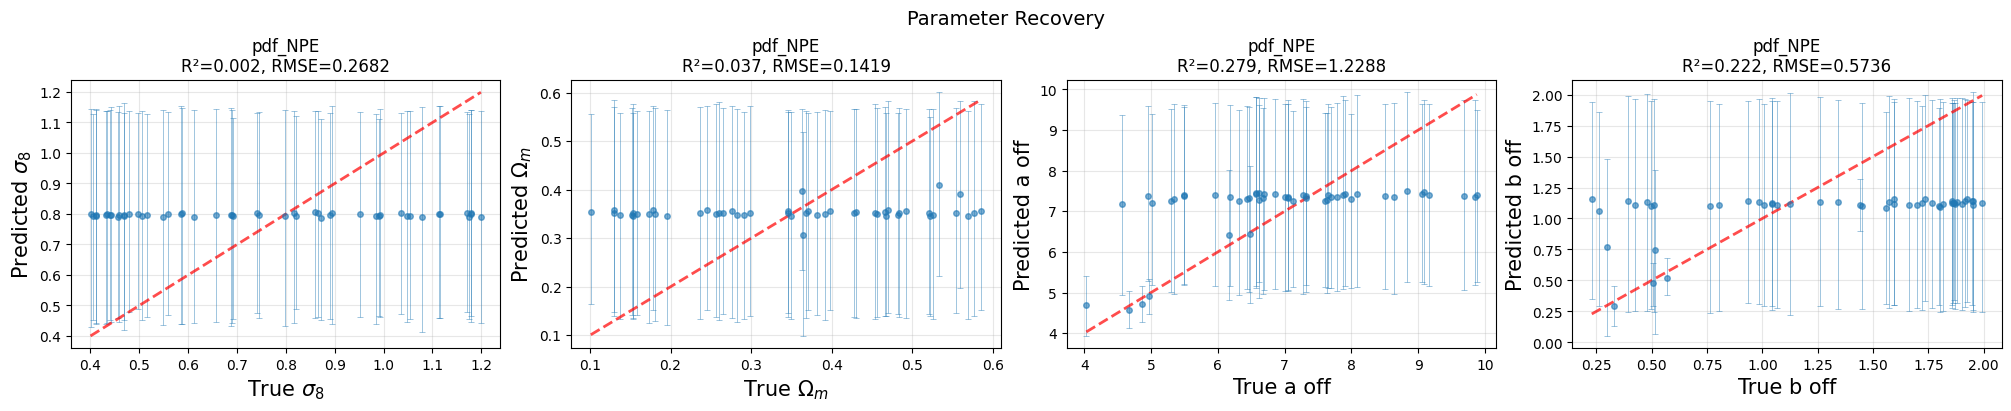

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

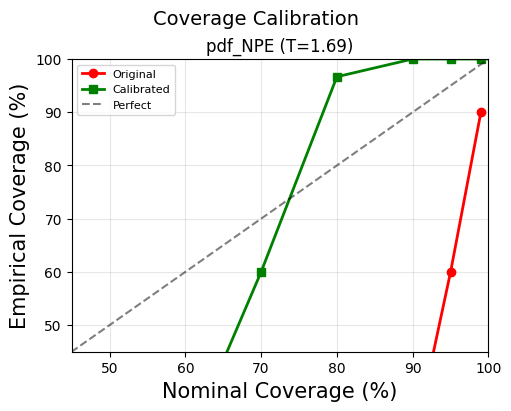


CREATING OPTIMIZATION VISUALIZATIONS


ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [4]:
import optuna
import numpy as np
import matplotlib.pyplot as plt
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_contour
)

# Your existing setup
SEED = 51
SIM_ROOT = f"/Users/anirbanroy/Desktop/test_maps_all_params/"
OUTPUT_ROOT = "/Users/anirbanroy/Desktop/output_test"
test_obs_idx = 0

def compute_calibration_error(tester):
    """
    Compute calibration error from the tester object.
    Returns mean squared error from perfect calibration.
    """
    try:
        # Run calibration
        tester.calibrate_posteriors()
        
        # Access calibration results
        # This assumes your calibrate_posteriors stores results in tester
        # You might need to adjust based on your actual implementation
        
        # Get coverage for different confidence levels
        # Typically evaluated at 68%, 95%, 99%
        nominal_levels = np.array([0.68, 0.95, 0.99])
        
        # Get empirical coverage from calibration
        # This extracts it from the calibration results
        # You'll need to adjust this based on how your code stores results
        cal_data = tester.calibration_results  # Adjust this line based on your implementation
        empirical_coverage = np.array([
            cal_data['coverage_68'],
            cal_data['coverage_95'],
            cal_data['coverage_99']
        ])
        
        # Compute calibration error (MSE from perfect calibration)
        calibration_error = np.mean((nominal_levels - empirical_coverage)**2)
        
        return calibration_error
        
    except Exception as e:
        print(f"Error computing calibration: {e}")
        return 1.0  # Return high error if calibration fails

def objective(trial):
    """
    Optuna objective function to minimize calibration error.
    """
    
    # Suggest hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-3, log=True)
    batch_size = trial.suggest_categorical("training_batch_size", [32, 50, 100, 150, 200])
    stop_after_epochs = trial.suggest_int("stop_after_epochs", 10, 30)
    max_num_epochs = trial.suggest_int("max_num_epochs", 300, 1500)
    validation_fraction = trial.suggest_float("validation_fraction", 0.15, 0.35)
    
    # Build training dictionary
    input_training_dict = {
        "max_num_epochs": max_num_epochs,
        "stop_after_epochs": stop_after_epochs,
        "training_batch_size": batch_size,
        "learning_rate": learning_rate,
        "validation_fraction": validation_fraction,
    }
    
    print(f"\nTrial {trial.number}: Testing hyperparameters:")
    print(f"  Learning rate: {learning_rate:.2e}")
    print(f"  Batch size: {batch_size}")
    print(f"  Stop after epochs: {stop_after_epochs}")
    print(f"  Max epochs: {max_num_epochs}")
    print(f"  Validation fraction: {validation_fraction}")
    
    try:
        # Create and train model
        tester_ps = SBIConvergenceTester(
            param_names=["sigma8", "omega_m", "a_off", "b_off"],
            inference_methods=["NPE"],
            analysis_methods=["pdf"],
            n_train=2500,
            n_test=500,
            n_calibration=50,
            test_obs_idx=test_obs_idx 
        )
        
        tester_ps.load_data(SIM_ROOT, SEED)
        tester_ps.setup_limference(
            OUTPUT_ROOT + f"/trial_{trial.number}", 
            training_kwargs=input_training_dict
        )
        tester_ps.train_models()
        
        # Compute calibration error
        cal_error = compute_calibration_error(tester_ps)
        
        print(f"  Calibration error: {cal_error:.6f}")
        
        return cal_error
        
    except Exception as e:
        print(f"Trial {trial.number} failed with error: {e}")
        return 1.0  # Return high error for failed trials

# Create Optuna study
print("="*70)
print("STARTING OPTUNA HYPERPARAMETER OPTIMIZATION")
print("="*70)

study = optuna.create_study(
    direction="minimize",
    study_name="limference_calibration",
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=3
    )
)

# Run optimization
n_trials = 30  # Adjust based on computational budget
study.optimize(objective, n_trials=n_trials, timeout=None)

# Print results
print("\n" + "="*70)
print("OPTIMIZATION COMPLETE")
print("="*70)
print(f"\nBest calibration error: {study.best_value:.6f}")
print("\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Save best parameters
best_training_dict = {
    "max_num_epochs": study.best_params["max_num_epochs"],
    "stop_after_epochs": study.best_params["stop_after_epochs"],
    "training_batch_size": study.best_params["training_batch_size"],
    "learning_rate": study.best_params["learning_rate"],
    "validation_fraction": study.best_params["validation_fraction"],
}

print("\n" + "="*70)
print("TRAINING WITH BEST HYPERPARAMETERS")
print("="*70)

# Train final model with best hyperparameters
tester_final = SBIConvergenceTester(
    param_names=["sigma8", "omega_m", "a_off", "b_off"],
    inference_methods=["NPE"],
    analysis_methods=["pdf"],
    n_train=2500,
    n_test=500,
    n_calibration=50,
    test_obs_idx=test_obs_idx,
    check_dependencies=False
)

tester_final.load_data(SIM_ROOT, SEED)
tester_final.setup_limference(
    OUTPUT_ROOT + "/best_model", 
    training_kwargs=best_training_dict
)
tester_final.train_models()
tester_final.calibrate_posteriors()
tester_final.test_recovery()
tester_final.plot_results()

# Visualize optimization process
print("\n" + "="*70)
print("CREATING OPTIMIZATION VISUALIZATIONS")
print("="*70)

fig = plot_optimization_history(study)
fig.show()

fig = plot_param_importances(study)
fig.show()

fig = plot_contour(study, params=["learning_rate", "training_batch_size"])
fig.show()

# Save study results
import joblib
joblib.dump(study, OUTPUT_ROOT + "/optuna_study.pkl")
print(f"\nStudy saved to: {OUTPUT_ROOT}/optuna_study.pkl")

In [ ]:
def compute_calibration_error(tester):
    """
    Alternative version: compute calibration directly from posteriors
    """
    try:
        # Get test parameters and posteriors
        true_params = tester.test_theta  # True parameters
        
        # Sample from posterior for each test case
        n_test_samples = len(true_params)
        coverage_68 = []
        coverage_95 = []
        
        for i in range(min(50, n_test_samples)):  # Use calibration set
            # Get posterior samples
            posterior = tester.get_posterior(i)  # Adjust based on your API
            samples = posterior.sample((1000,))
            
            # Compute credible intervals for each parameter
            for param_idx in range(len(tester.param_names)):
                true_val = true_params[i, param_idx]
                param_samples = samples[:, param_idx]
                
                # 68% credible interval
                ci_68 = np.percentile(param_samples, [16, 84])
                if ci_68[0] <= true_val <= ci_68[1]:
                    coverage_68.append(1)
                else:
                    coverage_68.append(0)
                
                # 95% credible interval
                ci_95 = np.percentile(param_samples, [2.5, 97.5])
                if ci_95[0] <= true_val <= ci_95[1]:
                    coverage_95.append(1)
                else:
                    coverage_95.append(0)
        
        # Compute empirical coverage
        emp_coverage_68 = np.mean(coverage_68)
        emp_coverage_95 = np.mean(coverage_95)
        
        # Calibration error
        error = (0.68 - emp_coverage_68)**2 + (0.95 - emp_coverage_95)**2
        
        return error
        
    except Exception as e:
        print(f"Error: {e}")
        return 1.0

In [ ]:
#!/usr/bin/env python3
"""
Optuna Hyperparameter Optimization for LIMference
Optimizes training hyperparameters to minimize calibration error
"""

import argparse
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_contour
)
import joblib
from datetime import datetime

# Import your SBIConvergenceTester
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
from scipy import stats
from scipy.optimize import minimize_scalar
from typing import Dict, List, Optional, Tuple, Any

from limference import (
    LIMference, 
    LIMConfig,
    ParameterConfig,
    calculate_statistics,
    create_corner_plot
)

class SBIConvergenceTester:
    """
    General class for testing any SBI method with convergence analysis.
    Works with any set of parameters specified by the user.
    
    Data Split Strategy:
    -------------------
    - Training: indices [0:n_train]
    - Test (calibration): indices [n_train:n_train+n_calibration]
    - Test (validation): indices [n_train+n_calibration:n_train+n_test]
    
    Dependencies:
    ------------
    Required: numpy, torch, scipy, matplotlib, limference
    Optional: arviz (for MCMC diagnostics), sklearn (for isotonic calibration)
    """
    
    def __init__(
        self,
        param_names: List[str],
        param_labels: Optional[Dict[str, str]] = None,
        inference_methods: List[str] = ["NPE"],
        analysis_methods: List[str] = ["pdf"],
        n_train: int = 2000,
        n_test: int = 500,
        n_calibration: int = 50,
        config_kwargs: Optional[Dict] = None,
        test_obs_idx: int = 0,
        check_dependencies: bool = True
    ):
        """Initialize tester with flexible parameter specification."""
        self.param_names = param_names
        self.n_params = len(param_names)
        
        if param_labels is None:
            self.param_labels = self._create_default_labels(param_names)
        else:
            self.param_labels = param_labels
            for name in param_names:
                if name not in self.param_labels:
                    self.param_labels[name] = self._create_default_labels([name])[name]
        
        self.inference_methods = inference_methods
        self.analysis_methods = analysis_methods
        self.n_train = n_train
        self.n_test = n_test
        self.n_calibration = n_calibration
        self.config_kwargs = config_kwargs or {}
        
        self.data_loaded = False
        self.models_trained = False
        self.results = {}
        self.test_obs_idx = test_obs_idx
        
        # Check optional dependencies if requested
        if check_dependencies:
            self._check_dependencies()
    
    def _check_dependencies(self):
        """Check for optional dependencies and warn if missing."""
        optional_deps = {
            'arviz': 'MCMC diagnostics (run_mcmc_diagnostics)',
            'sklearn': 'Isotonic calibration (calibrate_posteriors with method="isotonic")',
            'sbi.diagnostics.lc2st': 'LC2ST diagnostics (run_lc2st_diagnostic)',
            'sbi.analysis': 'Advanced analysis (active subspace, conditional distributions)'
        }
        
        self.available_features = {}
        
        for dep, feature in optional_deps.items():
            try:
                if '.' in dep:
                    # Handle nested imports
                    parts = dep.split('.')
                    mod = __import__(parts[0])
                    for part in parts[1:]:
                        mod = getattr(mod, part)
                else:
                    __import__(dep)
                self.available_features[dep] = True
            except ImportError:
                self.available_features[dep] = False
                print(f"Optional dependency '{dep}' not found. Feature disabled: {feature}")
    
    def _create_default_labels(self, names: List[str]) -> Dict[str, str]:
        """Create default LaTeX labels for common parameter names."""
        default_labels = {
            'omega_m': r'$\Omega_m$',
            'Omega_m': r'$\Omega_m$',
            'h': r'$h$',
            'sigma8': r'$\sigma_8$',
            'sigma_8': r'$\sigma_8$',
        }
        
        labels = {}
        for name in names:
            if name in default_labels:
                labels[name] = default_labels[name]
            else:
                labels[name] = name.replace('_', ' ')
        
        return labels
    
    def load_data(self, sim_root: str, seed: int = 1, param_file_keys: Optional[Dict[str, str]] = None):
        """Load simulation data with flexible parameter extraction."""
        print(f"Loading data from {sim_root}...")
        
        ps_file = np.load(sim_root + f"ps_80_256.npz", allow_pickle=True)
        pdf_file = np.load(sim_root + f"pdf_80_256.npz", allow_pickle=True)
        
        self.params_sims = ps_file["parameters"]
        self.k_sim = ps_file["k_2d"]
        self.pk_sim = ps_file["pk_2d"]
        self.bin_sim_linear = pdf_file["lim_bin_edges_linear_2d"]
        self.pdf_sim_linear = pdf_file["lim_pdf_linear_2d"]
        
        self.params_array = self._extract_parameters(self.params_sims, param_file_keys)
        
        # Keep all data accessible
        self.all_params = self.params_array
        self.all_pk = self.pk_sim
        self.all_pdf = self.pdf_sim_linear
        
        # Split data according to documented strategy
        self.train_params = self.params_array[:self.n_train]
        self.train_pk = self.pk_sim[:self.n_train]
        self.train_pdf = self.pdf_sim_linear[:self.n_train]
        
        self.test_params = self.params_array[self.n_train:self.n_train+self.n_test]
        self.test_pk = self.pk_sim[self.n_train:self.n_train+self.n_test]
        self.test_pdf = self.pdf_sim_linear[self.n_train:self.n_train+self.n_test]
        
        self.data_loaded = True
        
        print(f"Data loaded: {len(self.params_sims)} total simulations")
        print(f"Training set: {self.n_train} samples (indices 0:{self.n_train})")
        print(f"Test set: {self.n_test} samples (indices {self.n_train}:{self.n_train+self.n_test})")
        print(f"  - Calibration: {self.n_calibration} samples")
        print(f"  - Validation: {self.n_test - self.n_calibration} samples")
        print(f"Parameters being constrained: {', '.join(self.param_names)}")
        print(f"Parameter ranges:")
        for i, name in enumerate(self.param_names):
            print(f"  {name}: [{self.params_array[:, i].min():.3f}, {self.params_array[:, i].max():.3f}]")
    
    def _extract_parameters(self, params_sims: Any, param_file_keys: Optional[Dict[str, str]] = None) -> np.ndarray:
        """Extract specified parameters from simulation data."""
        if param_file_keys is None:
            param_file_keys = {}
        
        params_list = []
        
        if hasattr(params_sims, 'dtype') and params_sims.dtype.names:
            for sim_params in params_sims:
                param_values = []
                
                for param_name in self.param_names:
                    if param_name == "sigma8":
                        if "sigma_8" in params_sims.dtype.names:
                            value = sim_params["sigma_8"]
                        elif "sigma8" in params_sims.dtype.names:
                            value = sim_params["sigma8"]
                        else:
                            raise KeyError(f"Could not find sigma8. Available: {params_sims.dtype.names}")
                    
                    elif param_name == "omega_m":
                        if "omega_m" in params_sims.dtype.names:
                            value = sim_params["omega_m"]
                        elif "Omega_m" in params_sims.dtype.names:
                            value = sim_params["Omega_m"]
                        else:
                            raise KeyError(f"Could not find omega_m. Available: {params_sims.dtype.names}")
                    
                    else:
                        file_key = param_file_keys.get(param_name, param_name)
                        if file_key in params_sims.dtype.names:
                            value = sim_params[file_key]
                        elif param_name in params_sims.dtype.names:
                            value = sim_params[param_name]
                        else:
                            raise KeyError(f"Could not find '{param_name}'. Available: {params_sims.dtype.names}")
                    
                    param_values.append(float(value))
                
                params_list.append(param_values)
        else:
            for sim_params in params_sims:
                param_values = []
                for param_name in self.param_names:
                    file_key = param_file_keys.get(param_name, param_name)
                    if file_key in sim_params:
                        value = sim_params[file_key]
                    elif param_name in sim_params:
                        value = sim_params[param_name]
                    else:
                        raise KeyError(f"Could not find parameter '{param_name}'")
                    param_values.append(value)
                params_list.append(param_values)
        
        return np.array(params_list)
    
    def setup_limference(self, output_root: str, training_kwargs: Optional[Dict] = None):
        """Initialize LIMference with configuration."""
        if not self.data_loaded:
            raise ValueError("Load data first using load_data()")
        
        default_training = {
            "max_num_epochs": 400,
            "stop_after_epochs": 30,
            "training_batch_size": 100,
            "learning_rate": 5e-4,
            "validation_fraction": 0.2,
        }
        
        if training_kwargs:
            default_training.update(training_kwargs)
        
        default_config = {
            "root": output_root,
            "n_signal_sims": self.n_train + self.n_test,
            "num_noise_simulations": 1,
            "inference_methods": self.inference_methods,
            "analysis_methods": self.analysis_methods,
            "device": "cuda" if torch.cuda.is_available() else "cpu",
            **default_training
        }
        default_config.update(self.config_kwargs)
        
        self.config = LIMConfig(**default_config)
        
        param_ranges = {}
        for i, name in enumerate(self.param_names):
            param_ranges[name] = (
                float(self.params_array[:, i].min()),
                float(self.params_array[:, i].max())
            )
        
        self.param_config = ParameterConfig(
            param_names=self.param_names,
            param_ranges=param_ranges,
            param_labels=self.param_labels
        )
        
        self.lim = LIMference(self.config, param_config=self.param_config)
        
        # Load ALL data (train + test) into LIMference
        self.lim.parameters = np.vstack([self.train_params, self.test_params])
        
        simulations = {}
        
        # Handle combined PS+PDF
        if "combined_ps_pdf" in self.analysis_methods:
            # Ensure we have k array
            if len(self.k_sim.shape) == 1:
                k_array = self.k_sim
            else:
                k_array = self.k_sim[0] if len(self.k_sim.shape) > 1 else self.k_sim
            
            # Store individual components for later use
            simulations["power_spectrum"] = {
                "k": k_array,
                "pk": np.vstack([self.train_pk, self.test_pk])
            }
            
            simulations["pdf"] = {
                "bins_linear": self.bin_sim_linear,
                "pdf_linear": np.vstack([self.train_pdf, self.test_pdf])
            }
            
            # Create combined data
            combined_data = np.concatenate([
                simulations["power_spectrum"]["pk"],
                simulations["pdf"]["pdf_linear"]
            ], axis=1)
            
            simulations["combined_ps_pdf"] = combined_data
        
        # Load individual methods if requested
        for method in self.analysis_methods:
            if method == "pdf" and method not in simulations:
                simulations["pdf"] = {
                    "bins_linear": self.bin_sim_linear,
                    "pdf_linear": np.vstack([self.train_pdf, self.test_pdf])
                }
            elif method == "power_spectrum" and method not in simulations:
                if len(self.k_sim.shape) == 1:
                    k_array = self.k_sim
                else:
                    k_array = self.k_sim[0] if len(self.k_sim.shape) > 1 else self.k_sim
                
                simulations["power_spectrum"] = {
                    "k": k_array,
                    "pk": np.vstack([self.train_pk, self.test_pk])
                }
        
        self.lim.simulations = simulations
        
        print(f"LIMference initialized for methods: {self.inference_methods}")
        print(f"Analysis methods: {self.analysis_methods}")
        print(f"Parameters to constrain: {', '.join(self.param_names)}")
    
    def train_models(self):
        """Train SBI models."""
        if not hasattr(self, 'lim'):
            raise ValueError("Setup LIMference first using setup_limference()")
        
        print("\n" + "="*70)
        print("TRAINING MODELS")
        print("="*70)
        
        # FIXED: Use self.test_obs_idx instead of test_obs_idx
        combined_test_idx = self.n_train + self.test_obs_idx
        self.test_true_params = self.test_params[self.test_obs_idx]
        
        print(f"\nTest observation index: {self.test_obs_idx}")
        print(f"Test observation true parameters:")
        for i, name in enumerate(self.param_names):
            print(f"  {name} = {self.test_true_params[i]:.3f}")
        
        try:
            self.lim_results = self.lim.run_inference_comparison(
                observation_index=combined_test_idx,
                analysis_methods=self.analysis_methods,
                inference_methods=self.inference_methods,
                n_posterior_samples=10000,
                verbose=True
            )
            
            self.models_trained = True
            self.lim.results = self.lim_results
            
        except Exception as e:
            print(f"Error during training: {e}")
            import traceback
            traceback.print_exc()
            self.models_trained = False
    
    def compare_estimation_methods(self):
        """Compare different parameter estimation methods across all trained models"""
        
        if not self.models_trained:
            print("No trained models to analyze")
            return None
        
        # Standardized test index usage
        test_idx = self.test_obs_idx
        
        print("\n" + "="*70)
        print("COMPARING PARAMETER ESTIMATION METHODS")
        print(f"Using test observation index: {test_idx}")
        print("="*70)
        
        comparison_results = {}
        
        for method_key, result in self.lim.results.items():
            if "error" in result:
                continue
            
            print(f"\n{method_key}:")
            print("-"*50)
            
            # Get observation for this method
            if "combined" in method_key:
                test_obs = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
            elif "power" in method_key:
                test_obs = self.test_pk[test_idx]
            elif "pdf" in method_key:
                test_obs = self.test_pdf[test_idx]
            else:
                continue
            
            # Get comprehensive estimates
            estimates, samples = self.estimate_parameters_comprehensive(
                result['posterior'], test_obs, n_samples=10000
            )
            
            # Store results
            comparison_results[method_key] = estimates
            
            # Print comparison
            true_params = self.test_params[test_idx]
            
            print(f"\nTrue values:     {self.param_names[0]}={true_params[0]:.4f}, "
                  f"{self.param_names[1]}={true_params[1]:.4f}")
            
            print("\nPoint Estimates:")
            for estimator in ['mean', 'median', 'mode_kde', 'map']:
                if estimates[estimator] is not None:
                    est_vals = estimates[estimator]
                    errors = est_vals - true_params
                    print(f"  {estimator:8s}: {self.param_names[0]}={est_vals[0]:.4f} (err={errors[0]:+.4f}), "
                          f"{self.param_names[1]}={est_vals[1]:.4f} (err={errors[1]:+.4f})")
            
            print("\nUncertainties:")
            print(f"  Std Dev:  {self.param_names[0]}={estimates['std'][0]:.4f}, "
                  f"{self.param_names[1]}={estimates['std'][1]:.4f}")
            print(f"  MAD:      {self.param_names[0]}={estimates['mad'][0]:.4f}, "
                  f"{self.param_names[1]}={estimates['mad'][1]:.4f}")
            
            print("\n68% HPD Intervals:")
            for i, name in enumerate(self.param_names):
                hpd = estimates['hpd_68'][i]
                width = hpd[1] - hpd[0]
                print(f"  {name}: [{hpd[0]:.4f}, {hpd[1]:.4f}] (width={width:.4f})")
            
            print("\nMultimodality Check:")
            for i, name in enumerate(self.param_names):
                status = "Yes ⚠️" if estimates['is_multimodal'][i] else "No ✓"
                print(f"  {name}: {status}")
            
            # Calculate RMSE for each estimator
            print("\nRMSE by Estimator:")
            for estimator in ['mean', 'median', 'mode_kde', 'map']:
                if estimates[estimator] is not None:
                    rmse = np.sqrt(np.mean((estimates[estimator] - true_params)**2))
                    print(f"  {estimator:8s}: {rmse:.4f}")
        
        return comparison_results
    
    def plot_estimation_comparison(self):
        """Visualize different estimation methods"""
        
        # Standardized test index usage
        test_idx = self.test_obs_idx
        
        comparison = self.compare_estimation_methods()
        if not comparison:
            return
        
        n_methods = len(comparison)
        n_params = len(self.param_names)
        
        # FIXED: Use constrained_layout in figure creation
        fig, axes = plt.subplots(n_params, n_methods, 
                                 figsize=(5*n_methods, 4*n_params),
                                 constrained_layout=True)
        
        if n_methods == 1:
            axes = axes.reshape(-1, 1)
        if n_params == 1:
            axes = axes.reshape(1, -1)
        
        for j, (method_key, estimates) in enumerate(comparison.items()):
            # Get samples for this method
            if "combined" in method_key:
                test_obs = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
            elif "power" in method_key:
                test_obs = self.test_pk[test_idx]
            elif "pdf" in method_key:
                test_obs = self.test_pdf[test_idx]
            else:
                continue
            
            x_obs_tensor = torch.tensor(test_obs, dtype=torch.float32)
            samples = self.lim.results[method_key]['posterior'].sample(
                (5000,), x=x_obs_tensor
            ).numpy()
            
            for i, param_name in enumerate(self.param_names):
                ax = axes[i, j] if n_params > 1 else axes[j]
                
                # Plot histogram
                ax.hist(samples[:, i], bins=50, density=True, 
                       alpha=0.5, color='gray', edgecolor='black')
                
                # Add KDE
                from scipy.stats import gaussian_kde
                kde = gaussian_kde(samples[:, i])
                x_grid = np.linspace(samples[:, i].min(), samples[:, i].max(), 200)
                ax.plot(x_grid, kde(x_grid), 'k-', linewidth=2, label='KDE')
                
                # Mark different estimates
                true_val = self.test_params[test_idx][i]
                ax.axvline(true_val, color='red', linestyle='--', 
                          linewidth=2, label='True')
                
                colors = {'mean': 'blue', 'median': 'green', 
                         'mode_kde': 'orange', 'map': 'purple'}
                
                for est_name, color in colors.items():
                    if estimates[est_name] is not None:
                        ax.axvline(estimates[est_name][i], color=color, 
                                  linestyle=':', linewidth=1.5, label=est_name)
                
                ax.set_xlabel(self.param_labels[param_name])
                ax.set_ylabel('Density')
                ax.set_title(f'{method_key}\n{param_name}')
                
                if i == 0 and j == 0:
                    ax.legend(fontsize=8, loc='best')
                
                # Add text box with stats
                multimodal = "Multi" if estimates['is_multimodal'][i] else "Uni"
                textstr = f"{multimodal}modal"
                ax.text(0.05, 0.95, textstr, transform=ax.transAxes, 
                       fontsize=9, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.suptitle('Parameter Estimation Methods Comparison', fontsize=14)
        plt.show()
    
    def calibrate_posteriors(self, target_coverage: float = 0.68, method: str = "temperature"):
        """
        Calibrate posteriors using temperature scaling and/or isotonic regression.

        Parameters:
        -----------
        target_coverage : float
            Target coverage level for calibration (default 0.68)
        method : str
            Calibration method:
            - "temperature": Scale uncertainties using temperature parameter
            - "isotonic": Use isotonic regression for calibration curve
            - "both": Apply both methods sequentially (temperature first, then isotonic)
            
        Note: "isotonic" requires sklearn to be installed.
        """
        if not self.models_trained:
            raise ValueError("Train models first")

        print("\n" + "="*50)
        print("CALIBRATING POSTERIORS")
        print(f"Method: {method}")
        print("="*50)

        # Check isotonic availability
        if method in ["isotonic", "both"]:
            if not self.available_features.get('sklearn', False):
                print("WARNING: sklearn not available. Falling back to temperature-only calibration.")
                method = "temperature"

        # Helper function for temperature scaling
        def calibrate_temperature(posterior, cal_data, cal_params, target=0.68):
            def coverage_error(temp):
                coverage = 0
                n_cal = min(30, len(cal_data))

                for i in range(n_cal):
                    try:
                        x_obs = torch.tensor(cal_data[i], dtype=torch.float32)
                        samples = posterior.sample((300,), x=x_obs).numpy()

                        mean = np.mean(samples, axis=0)
                        scaled = mean + (samples - mean) * temp

                        q16, q84 = np.percentile(scaled, [16, 84], axis=0)
                        if np.all((cal_params[i] >= q16) & (cal_params[i] <= q84)):
                            coverage += 1
                    except:
                        continue

                return abs(coverage/n_cal - target) if n_cal > 0 else 1.0

            result = minimize_scalar(coverage_error, bounds=(0.5, 3.0), method='bounded')
            return result.x

        # Helper function for isotonic regression
        def calibrate_isotonic(posterior, cal_data, cal_params):
            from sklearn.isotonic import IsotonicRegression

            print("  Building isotonic calibration curve...")

            # Collect calibration data at different confidence levels
            confidence_levels = np.linspace(0.1, 0.99, 20)
            predicted_coverages = []
            empirical_coverages = []

            for conf_level in confidence_levels:
                coverage_count = 0
                n_valid = 0

                for i in range(min(50, len(cal_data))):
                    try:
                        x_obs = torch.tensor(cal_data[i], dtype=torch.float32)
                        samples = posterior.sample((500,), x=x_obs).numpy()

                        # Calculate confidence interval
                        lower_percentile = (1 - conf_level) / 2 * 100
                        upper_percentile = (1 + conf_level) / 2 * 100
                        ci_low = np.percentile(samples, lower_percentile, axis=0)
                        ci_high = np.percentile(samples, upper_percentile, axis=0)

                        # Check if true parameter is within CI
                        if np.all((cal_params[i] >= ci_low) & (cal_params[i] <= ci_high)):
                            coverage_count += 1
                        n_valid += 1
                    except:
                        continue

                if n_valid > 0:
                    predicted_coverages.append(conf_level)
                    empirical_coverages.append(coverage_count / n_valid)

            # Fit isotonic regression
            iso_reg = IsotonicRegression(out_of_bounds='clip', increasing=True)
            iso_reg.fit(predicted_coverages, empirical_coverages)

            # Create calibration function
            def apply_isotonic_calibration(samples, confidence_level):
                """Apply isotonic calibration to adjust confidence intervals."""
                target_empirical = confidence_level

                # Binary search for the right nominal level
                low, high = 0.01, 0.99
                for _ in range(20):
                    mid = (low + high) / 2
                    empirical = iso_reg.predict([mid])[0]
                    if empirical < target_empirical:
                        low = mid
                    else:
                        high = mid

                # Use the calibrated confidence level
                calibrated_level = mid
                lower_percentile = (1 - calibrated_level) / 2 * 100
                upper_percentile = (1 + calibrated_level) / 2 * 100

                return np.percentile(samples, [lower_percentile, upper_percentile], axis=0)

            return iso_reg, apply_isotonic_calibration

        # Apply calibration to each method
        for method_key, result in self.lim.results.items():
            if "error" not in result:
                # Prepare calibration data
                if "combined" in method_key:
                    cal_pk = self.test_pk[:self.n_calibration]
                    cal_pdf = self.test_pdf[:self.n_calibration]
                    cal_data = np.concatenate([cal_pk, cal_pdf], axis=1)
                elif "power" in method_key:
                    cal_data = self.test_pk[:self.n_calibration]
                elif "pdf" in method_key:
                    cal_data = self.test_pdf[:self.n_calibration]
                else:
                    continue

                cal_params = self.test_params[:self.n_calibration]

                # Apply temperature scaling
                if method in ["temperature", "both"]:
                    try:
                        temp = calibrate_temperature(
                            result['posterior'], cal_data, cal_params, target_coverage
                        )
                        result['calibration_temp'] = temp
                        print(f"{method_key} - Temperature scaling: T = {temp:.3f}")

                        if temp > 1.2:
                            print(f"  → Model was overconfident, widening by {(temp-1)*100:.1f}%")
                        elif temp < 0.8:
                            print(f"  → Model was underconfident, narrowing by {(1-temp)*100:.1f}%")
                        else:
                            print(f"  → Model was well-calibrated")
                    except Exception as e:
                        print(f"{method_key} - Temperature calibration failed: {e}")
                        result['calibration_temp'] = 1.0

                # Apply isotonic regression
                if method in ["isotonic", "both"]:
                    try:
                        iso_reg, iso_apply = calibrate_isotonic(
                            result['posterior'], cal_data, cal_params
                        )
                        result['isotonic_calibrator'] = iso_reg
                        result['isotonic_apply'] = iso_apply

                        # Test the calibration
                        test_levels = [0.68, 0.95]
                        calibrated_levels = iso_reg.predict(test_levels)
                        print(f"{method_key} - Isotonic regression calibration:")
                        for nominal, empirical in zip(test_levels, calibrated_levels):
                            print(f"  → {nominal*100:.0f}% nominal → {empirical*100:.1f}% empirical")

                    except Exception as e:
                        print(f"{method_key} - Isotonic calibration failed: {e}")
                        result['isotonic_calibrator'] = None
    
    def test_recovery(self):
        """Test posterior recovery on test set."""
        if not self.models_trained:
            raise ValueError("Train models first")
        
        print("\n" + "="*50)
        print("TESTING POSTERIOR RECOVERY")
        print("="*50)
        
        recovery_results = {}
        
        for method_key, result in self.lim.results.items():
            if "error" not in result:
                print(f"\n{method_key}:")
                
                if "combined" in method_key:
                    test_pk = self.test_pk[self.n_calibration:]
                    test_pdf = self.test_pdf[self.n_calibration:]
                    test_data = np.concatenate([test_pk, test_pdf], axis=1)
                elif "power" in method_key:
                    test_data = self.test_pk[self.n_calibration:]
                elif "pdf" in method_key:
                    test_data = self.test_pdf[self.n_calibration:]
                else:
                    continue
                
                test_params_subset = self.test_params[self.n_calibration:]
                
                n_test_samples = min(50, len(test_data))
                coverage_68 = 0
                coverage_95 = 0
                errors = []
                
                temp = result.get('calibration_temp', 1.0)
                
                for i in range(n_test_samples):
                    try:
                        x_obs = torch.tensor(test_data[i], dtype=torch.float32)
                        samples = result['posterior'].sample((1000,), x=x_obs).numpy()
                        
                        mean = np.mean(samples, axis=0)
                        samples = mean + (samples - mean) * temp
                        
                        post_mean = np.mean(samples, axis=0)
                        errors.append(post_mean - test_params_subset[i])
                        
                        q16, q84 = np.percentile(samples, [16, 84], axis=0)
                        q2_5, q97_5 = np.percentile(samples, [2.5, 97.5], axis=0)
                        
                        if np.all((test_params_subset[i] >= q16) & (test_params_subset[i] <= q84)):
                            coverage_68 += 1
                        if np.all((test_params_subset[i] >= q2_5) & (test_params_subset[i] <= q97_5)):
                            coverage_95 += 1
                            
                    except Exception as e:
                        continue
                
                if len(errors) > 0:
                    errors = np.array(errors)
                    metrics = {
                        'coverage_68_rate': coverage_68 / n_test_samples,
                        'coverage_95_rate': coverage_95 / n_test_samples,
                        'mean_rmse': np.sqrt(np.mean(errors**2)),
                        'mean_bias': np.mean(np.abs(errors)),
                        'well_calibrated_68': abs(coverage_68/n_test_samples - 0.68) < 0.1,
                        'well_calibrated_95': abs(coverage_95/n_test_samples - 0.95) < 0.1,
                        'calibration_temp': temp
                    }
                    recovery_results[method_key] = metrics
                    
                    print(f"  Temperature: {metrics['calibration_temp']:.3f}")
                    print(f"  68% coverage: {metrics['coverage_68_rate']:.1%}")
                    print(f"  95% coverage: {metrics['coverage_95_rate']:.1%}")
                    print(f"  RMSE: {metrics['mean_rmse']:.4f}")
        
        self.recovery_results = recovery_results
    
    def plot_results(self):
        """Create comprehensive visualization of results."""
        if not self.models_trained:
            raise ValueError("Train models first")
        
        self._plot_parameter_recovery()
        self._plot_coverage_curves()
    
    def _plot_coverage_curves(self):
        """Plot coverage calibration curves."""
        confidence_levels = np.array([50, 60, 70, 80, 90, 95, 99])
        
        n_methods = len([k for k in self.lim.results.keys() if "error" not in self.lim.results[k]])
        if n_methods == 0:
            return
        
        # FIXED: Use constrained_layout
        fig, axes = plt.subplots(1, n_methods, figsize=(5*n_methods, 4),
                                constrained_layout=True)
        if n_methods == 1:
            axes = [axes]
        
        plot_idx = 0
        
        for method_key, result in self.lim.results.items():
            if "error" not in result:
                ax = axes[plot_idx]
                
                start_idx = self.n_calibration
                end_idx = min(self.n_calibration + 30, self.n_test)
                
                if "combined" in method_key:
                    test_pk = self.test_pk[start_idx:end_idx]
                    test_pdf = self.test_pdf[start_idx:end_idx]
                    test_data = np.concatenate([test_pk, test_pdf], axis=1)
                elif "power" in method_key:
                    test_data = self.test_pk[start_idx:end_idx]
                elif "pdf" in method_key:
                    test_data = self.test_pdf[start_idx:end_idx]
                else:
                    continue
                
                test_params_subset = self.test_params[start_idx:end_idx]
                
                coverage_rates_orig = []
                coverage_rates_cal = []
                
                temp = result.get('calibration_temp', 1.0)
                
                for conf in confidence_levels:
                    coverage_orig = 0
                    coverage_cal = 0
                    n_samples = len(test_data)
                    
                    for i in range(n_samples):
                        try:
                            x_obs = torch.tensor(test_data[i], dtype=torch.float32)
                            samples = result['posterior'].sample((500,), x=x_obs).numpy()
                            
                            lower = (100-conf)/2
                            upper = 100-lower
                            
                            ci_low_orig = np.percentile(samples, lower, axis=0)
                            ci_high_orig = np.percentile(samples, upper, axis=0)
                            
                            mean = np.mean(samples, axis=0)
                            samples_cal = mean + (samples - mean) * temp
                            ci_low_cal = np.percentile(samples_cal, lower, axis=0)
                            ci_high_cal = np.percentile(samples_cal, upper, axis=0)
                            
                            if np.all((test_params_subset[i] >= ci_low_orig) & 
                                     (test_params_subset[i] <= ci_high_orig)):
                                coverage_orig += 1
                            if np.all((test_params_subset[i] >= ci_low_cal) & 
                                     (test_params_subset[i] <= ci_high_cal)):
                                coverage_cal += 1
                        except:
                            continue
                    
                    if n_samples > 0:
                        coverage_rates_orig.append(100 * coverage_orig/n_samples)
                        coverage_rates_cal.append(100 * coverage_cal/n_samples)
                
                if coverage_rates_orig:
                    ax.plot(confidence_levels[:len(coverage_rates_orig)], coverage_rates_orig, 'o-', 
                           label='Original', linewidth=2, color='red')
                    ax.plot(confidence_levels[:len(coverage_rates_cal)], coverage_rates_cal, 's-', 
                           label='Calibrated', linewidth=2, color='green')
                    ax.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Perfect')
                    
                    ax.set_xlabel('Nominal Coverage (%)')
                    ax.set_ylabel('Empirical Coverage (%)')
                    ax.set_title(f'{method_key} (T={temp:.2f})')
                    ax.legend(fontsize=8)
                    ax.grid(True, alpha=0.3)
                    ax.set_xlim(45, 100)
                    ax.set_ylim(45, 100)
                
                plot_idx += 1
        
        if plot_idx > 0:
            plt.suptitle('Coverage Calibration', fontsize=14)
            plt.show()
    
    def _plot_parameter_recovery(self):
        """Plot parameter recovery scatter plots."""
        n_methods = len([k for k in self.lim.results.keys() if "error" not in self.lim.results[k]])
        n_params = len(self.param_names)
        
        if n_methods == 0:
            return
        
        # FIXED: Use constrained_layout
        fig, axes = plt.subplots(n_methods, n_params, 
                                figsize=(5*n_params, 4*n_methods),
                                constrained_layout=True)
        
        if n_methods == 1 and n_params == 1:
            axes = np.array([[axes]])
        elif n_methods == 1:
            axes = axes.reshape(1, -1)
        elif n_params == 1:
            axes = axes.reshape(-1, 1)
        
        method_idx = 0
        for method_key, result in self.lim.results.items():
            if "error" not in result:
                start_idx = self.n_calibration
                end_idx = min(self.n_calibration + 50, self.n_test)
                
                if "combined" in method_key:
                    test_pk = self.test_pk[start_idx:end_idx]
                    test_pdf = self.test_pdf[start_idx:end_idx]
                    test_data = np.concatenate([test_pk, test_pdf], axis=1)
                elif "power" in method_key:
                    test_data = self.test_pk[start_idx:end_idx]
                elif "pdf" in method_key:
                    test_data = self.test_pdf[start_idx:end_idx]
                else:
                    continue
                
                test_params_subset = self.test_params[start_idx:end_idx]
                temp = result.get('calibration_temp', 1.0)
                
                predictions_mean = []
                predictions_16 = []
                predictions_84 = []
                true_vals = []
                
                for i in range(len(test_data)):
                    try:
                        x_obs = torch.tensor(test_data[i], dtype=torch.float32)
                        samples = result['posterior'].sample((1000,), x=x_obs).numpy()
                        
                        mean = np.mean(samples, axis=0)
                        samples_cal = mean + (samples - mean) * temp
                        
                        predictions_mean.append(np.mean(samples_cal, axis=0))
                        predictions_16.append(np.percentile(samples_cal, 16, axis=0))
                        predictions_84.append(np.percentile(samples_cal, 84, axis=0))
                        true_vals.append(test_params_subset[i])
                    except:
                        continue
                
                if len(predictions_mean) == 0:
                    continue
                
                predictions_mean = np.array(predictions_mean)
                predictions_16 = np.array(predictions_16)
                predictions_84 = np.array(predictions_84)
                true_vals = np.array(true_vals)
                
                for param_idx in range(n_params):
                    ax = axes[method_idx, param_idx] if (n_methods > 1 or n_params > 1) else axes
                    
                    yerr_lower = predictions_mean[:, param_idx] - predictions_16[:, param_idx]
                    yerr_upper = predictions_84[:, param_idx] - predictions_mean[:, param_idx]
                    yerr = np.array([yerr_lower, yerr_upper])
                    
                    ax.errorbar(true_vals[:, param_idx], 
                               predictions_mean[:, param_idx],
                               yerr=yerr,
                               fmt='o', alpha=0.6, markersize=4,
                               elinewidth=0.5, capsize=2, capthick=0.5)
                    
                    lims = [true_vals[:, param_idx].min(), true_vals[:, param_idx].max()]
                    ax.plot(lims, lims, 'r--', alpha=0.7, linewidth=2)
                    
                    from scipy.stats import pearsonr
                    if len(true_vals[:, param_idx]) > 1:
                        r2 = pearsonr(true_vals[:, param_idx], predictions_mean[:, param_idx])[0]**2
                        rmse = np.sqrt(np.mean((true_vals[:, param_idx] - predictions_mean[:, param_idx])**2))
                    else:
                        r2 = 0
                        rmse = 0
                    
                    ax.set_xlabel(f'True {self.param_labels[self.param_names[param_idx]]}')
                    ax.set_ylabel(f'Predicted {self.param_labels[self.param_names[param_idx]]}')
                    ax.set_title(f'{method_key}\nR²={r2:.3f}, RMSE={rmse:.4f}')
                    ax.grid(True, alpha=0.3)
                
                method_idx += 1
        
        if method_idx > 0:
            plt.suptitle('Parameter Recovery', fontsize=14)
            plt.show()
    
    def estimate_parameters_comprehensive(self, posterior, x_obs, n_samples=10000):
        """Get multiple estimates for non-Gaussian posterior"""

        # Sample from posterior
        x_obs_tensor = torch.tensor(x_obs, dtype=torch.float32)
        samples = posterior.sample((n_samples,), x=x_obs_tensor).numpy()

        # Get various estimates
        estimates = {
            'mean': np.mean(samples, axis=0),
            'median': np.median(samples, axis=0),
            'mode_kde': self._get_mode_estimate(samples),
            'map': self._get_map_estimate(posterior, x_obs),
        }

        # Add uncertainties
        estimates['std'] = np.std(samples, axis=0)
        estimates['mad'] = np.median(np.abs(samples - estimates['median']), axis=0)

        # HPD intervals
        try:
            import arviz as az
            estimates['hpd_68'] = az.hdi(samples, hdi_prob=0.68)
            estimates['hpd_95'] = az.hdi(samples, hdi_prob=0.95)
        except ImportError:
            estimates['hpd_68'] = np.percentile(samples, [16, 84], axis=0).T
            estimates['hpd_95'] = np.percentile(samples, [2.5, 97.5], axis=0).T

        # Check for multimodality
        estimates['is_multimodal'] = self._check_multimodality(samples)

        return estimates, samples

    def _get_map_estimate(self, posterior, x_obs, n_init=50):
        """Find MAP estimate using optimization"""
        x_obs_tensor = torch.tensor(x_obs, dtype=torch.float32)

        # Sample initial points
        init_samples = posterior.sample((n_init,), x=x_obs_tensor)

        best_log_prob = -np.inf
        best_params = None

        for i in range(n_init):
            init = init_samples[i].clone().detach().requires_grad_(True)

            try:
                optimizer = torch.optim.LBFGS([init], lr=0.01, max_iter=100)

                def closure():
                    optimizer.zero_grad()
                    log_prob = posterior.log_prob(init.unsqueeze(0), x=x_obs_tensor)
                    loss = -log_prob
                    loss.backward()
                    return loss

                for _ in range(10):
                    optimizer.step(closure)

                final_log_prob = posterior.log_prob(init.unsqueeze(0), x=x_obs_tensor).item()
                if final_log_prob > best_log_prob:
                    best_log_prob = final_log_prob
                    best_params = init.detach().numpy()
            except:
                continue

        return best_params if best_params is not None else init_samples[0].numpy()

    def _get_mode_estimate(self, samples, n_grid=1000):
        """Estimate mode using kernel density estimation"""
        from scipy.stats import gaussian_kde

        modes = []
        for param_idx in range(samples.shape[1]):
            param_samples = samples[:, param_idx]

            # Fit KDE
            kde = gaussian_kde(param_samples)

            # Create grid and evaluate
            x_grid = np.linspace(param_samples.min(), param_samples.max(), n_grid)
            density = kde(x_grid)

            # Find mode
            mode_idx = np.argmax(density)
            modes.append(x_grid[mode_idx])

        return np.array(modes)

    def _check_multimodality(self, samples, threshold=0.1):
        """Check if posterior is multimodal"""
        from scipy.stats import gaussian_kde
        from scipy.signal import find_peaks

        is_multimodal = []

        for i in range(samples.shape[1]):
            kde = gaussian_kde(samples[:, i])
            x = np.linspace(samples[:, i].min(), samples[:, i].max(), 200)
            density = kde(x)

            # Find peaks
            peaks, properties = find_peaks(density, height=threshold*np.max(density))
            is_multimodal.append(len(peaks) > 1)

        return is_multimodal
    
    def run_sbc_analysis(self, n_sbc_runs: int = 100, n_posterior_samples: int = 1000):
        """Run proper SBC analysis with rank statistics."""
        ranks = {method: [] for method in self.lim.results.keys() if "error" not in self.lim.results[method]}

        for method_key, result in self.lim.results.items():
            if "error" in result:
                continue

            for _ in range(n_sbc_runs):
                # Sample from prior (using training data as approximation)
                idx = np.random.randint(0, self.n_train)
                true_param = self.train_params[idx]

                # Get corresponding observation based on method type
                if "combined" in method_key:
                    pk_obs = self.train_pk[idx]
                    pdf_obs = self.train_pdf[idx]
                    observation = np.concatenate([pk_obs, pdf_obs])
                elif "power" in method_key or "ps" in method_key:
                    observation = self.train_pk[idx]
                elif "pdf" in method_key:
                    observation = self.train_pdf[idx]
                else:
                    continue

                # Get posterior samples
                x_obs = torch.tensor(observation, dtype=torch.float32)
                samples = result['posterior'].sample((n_posterior_samples,), x=x_obs).numpy()

                # Calculate ranks for each parameter
                rank = np.sum(samples < true_param[None, :], axis=0) / n_posterior_samples
                ranks[method_key].append(rank)
    
        # Convert to arrays
        for method_key, method_ranks in ranks.items():
            ranks[method_key] = np.array(method_ranks)

        return ranks
    
    def plot_sbc_ranks(self, n_sbc_runs: int = 100, n_posterior_samples: int = 1000):
        """Run SBC analysis and create rank plots."""

        # First run the SBC analysis
        ranks = self.run_sbc_analysis(n_sbc_runs, n_posterior_samples)

        # Create plots for each method
        for method_key, method_ranks in ranks.items():
            if len(method_ranks) == 0:
                continue

            n_params = method_ranks.shape[1]
            # FIXED: Use constrained_layout
            fig, axes = plt.subplots(1, n_params, figsize=(6*n_params, 5),
                                    constrained_layout=True)

            if n_params == 1:
                axes = [axes]

            for param_idx, param_name in enumerate(self.param_names):
                ax = axes[param_idx]

                # Plot histogram of ranks
                n_bins = int(np.sqrt(n_sbc_runs)) if n_sbc_runs > 100 else 10
                counts, bins, _ = ax.hist(method_ranks[:, param_idx], 
                                         bins=n_bins, 
                                         density=True,
                                         alpha=0.7, 
                                         edgecolor='black',
                                         label='SBC ranks')

                # Add uniform reference line
                ax.axhline(1.0, color='red', linestyle='--', 
                          label='Expected (uniform)', linewidth=2)

                # Add confidence bands for uniform distribution
                n_samples = len(method_ranks[:, param_idx])
                std_uniform = 1 / np.sqrt(12)
                ci_width = 1.96 * std_uniform / np.sqrt(n_samples)
                ax.axhspan(1.0 - ci_width, 1.0 + ci_width, 
                          alpha=0.2, color='red', label='95% CI')

                # Run Kolmogorov-Smirnov test
                ks_stat, p_value = stats.kstest(method_ranks[:, param_idx], 'uniform')

                # Interpret the shape
                mean_rank = np.mean(method_ranks[:, param_idx])
                interpretation = ""
                if p_value < 0.05:
                    if mean_rank < 0.45:
                        interpretation = "Underconfident"
                    elif mean_rank > 0.55:
                        interpretation = "Overconfident"
                    else:
                        q1 = np.percentile(method_ranks[:, param_idx], 25)
                        q3 = np.percentile(method_ranks[:, param_idx], 75)
                        if q1 < 0.2 and q3 > 0.8:
                            interpretation = "Overconfident (U-shape)"
                        elif q1 > 0.3 and q3 < 0.7:
                            interpretation = "Underconfident (∩-shape)"
                        else:
                            interpretation = "Miscalibrated"
                else:
                    interpretation = "Well calibrated ✓"

                ax.set_xlabel('Rank statistic')
                ax.set_ylabel('Density')
                ax.set_title(f'{self.param_labels[param_name]}\nKS p={p_value:.3f}\n{interpretation}')
                ax.legend(loc='upper right')
                ax.grid(True, alpha=0.3)
                ax.set_xlim(0, 1)

            plt.suptitle(f'SBC Rank Plot - {method_key}\n(n={n_sbc_runs} runs)', 
                        fontsize=14)
            plt.show()
    
    def run_mcmc_diagnostics(self, method_key: str = None, n_samples: int = 1000, 
                         n_chains: int = 4, thin: int = 5, warmup_steps: int = 100):
        """
        Run MCMC diagnostics using arviz for likelihood-based methods.
        """
        # Check dependencies
        if not self.available_features.get('arviz', False):
            print("ERROR: arviz not installed. Install with: pip install arviz")
            return None
        
        try:
            import arviz as az
            from sbi.inference import NLE, MCMCPosterior, likelihood_estimator_based_potential
        except ImportError as e:
            print(f"ERROR: Required package not found: {e}")
            return None

        # Get method to analyze
        if method_key is None:
            method_key = next(k for k in self.lim.results.keys() if "error" not in self.lim.results[k])

        print(f"\nRunning MCMC diagnostics for {method_key}")
        print("="*50)
        
        # Standardized test index usage
        test_idx = self.test_obs_idx

        # Prepare training data
        if "combined" in method_key:
            train_data = np.concatenate([self.train_pk, self.train_pdf], axis=1)
            test_obs = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
        elif "power" in method_key or "ps" in method_key:
            train_data = self.train_pk
            test_obs = self.test_pk[test_idx]
        elif "pdf" in method_key:
            train_data = self.train_pdf
            test_obs = self.test_pdf[test_idx]
        else:
            print(f"Method {method_key} not supported for MCMC")
            return None

        # Check for NaN/Inf values
        if np.any(np.isnan(train_data)) or np.any(np.isinf(train_data)):
            print("Warning: NaN or Inf values detected in training data")
            valid_mask = ~(np.any(np.isnan(train_data), axis=1) | np.any(np.isinf(train_data), axis=1))
            train_data = train_data[valid_mask]
            train_params_clean = self.train_params[valid_mask]
        else:
            train_params_clean = self.train_params

        print(f"Using {len(train_data)} valid training samples")

        # Train NLE
        print("Training NLE for likelihood estimation...")
        from sbi.utils import BoxUniform

        # Create prior from parameter bounds
        min_vals = train_params_clean.min(axis=0)
        max_vals = train_params_clean.max(axis=0)
        prior = BoxUniform(
            low=torch.tensor(min_vals, dtype=torch.float32),
            high=torch.tensor(max_vals, dtype=torch.float32)
        )

        # Convert to tensors
        theta_tensor = torch.tensor(train_params_clean, dtype=torch.float32)
        x_tensor = torch.tensor(train_data, dtype=torch.float32)
        x_obs_tensor = torch.tensor(test_obs, dtype=torch.float32).unsqueeze(0)

        # Train NLE
        trainer = NLE(prior, density_estimator="maf")
        trainer = trainer.append_simulations(theta_tensor, x_tensor)
        likelihood_estimator = trainer.train(
            max_num_epochs=200,
            stop_after_epochs=20,
            training_batch_size=50,
            show_train_summary=True
        )

        # Set up MCMC
        print(f"\nRunning MCMC with {n_chains} chains...")
        mcmc_parameters = dict(
            num_chains=n_chains,
            thin=thin,
            warmup_steps=warmup_steps,
            init_strategy="proposal",
            method="slice_np_vectorized"
        )

        # Get potential function and parameter transform
        potential_fn, parameter_transform = likelihood_estimator_based_potential(
            likelihood_estimator, prior, x_obs_tensor
        )

        # Create MCMC posterior
        mnle_posterior = MCMCPosterior(
            potential_fn, 
            proposal=prior, 
            theta_transform=parameter_transform,
            **mcmc_parameters
        )

        # Sample and get arviz InferenceData
        mnle_samples = mnle_posterior.sample(
            (n_samples,), 
            x=x_obs_tensor, 
            show_progress_bars=True
        )

        # Get arviz InferenceData object
        inference_data = mnle_posterior.get_arviz_inference_data()

        # Store for later use
        self.mcmc_results = {
            'inference_data': inference_data,
            'samples': mnle_samples,
            'posterior': mnle_posterior,
            'method': method_key
        }

        # Create diagnostic plots
        self._plot_mcmc_diagnostics(inference_data, method_key)

        return inference_data
    
    def _plot_mcmc_diagnostics(self, inference_data, method_key: str):
        """Create comprehensive MCMC diagnostic plots using arviz."""
        try:
            import arviz as az
            az.style.use("arviz-darkgrid")
        except ImportError:
            print("Cannot create plots without arviz")
            return

        print("\nGenerating MCMC diagnostic plots...")

        # 1. Rank plots
        try:
            axes = az.plot_rank(inference_data, var_names=["theta"])
            if axes is not None:
                if isinstance(axes, np.ndarray):
                    fig = axes.flat[0].get_figure()
                else:
                    fig = axes.get_figure()
                fig.suptitle(f'Rank Plots - {method_key}', fontsize=14)
                plt.show()
        except Exception as e:
            print(f"Could not create rank plot: {e}")

        # 2. Trace plots
        try:
            axes = az.plot_trace(inference_data, var_names=["theta"])
            if axes is not None:
                if isinstance(axes, np.ndarray):
                    fig = axes.flat[0].get_figure()
                else:
                    fig = axes.get_figure()
                fig.suptitle(f'Trace Plots - {method_key}', fontsize=14)
                plt.show()
        except Exception as e:
            print(f"Could not create trace plot: {e}")

        # 3. Posterior plots
        try:
            axes = az.plot_posterior(
                inference_data, 
                var_names=["theta"],
                hdi_prob=0.95,
                point_estimate="mean"
            )
            if axes is not None:
                if isinstance(axes, np.ndarray):
                    fig = axes.flat[0].get_figure()
                else:
                    fig = axes.get_figure()
                fig.suptitle(f'Posterior Distributions - {method_key}', fontsize=14)
                plt.show()
        except Exception as e:
            print(f"Could not create posterior plot: {e}")

        # 4. Autocorrelation plots
        try:
            axes = az.plot_autocorr(inference_data, var_names=["theta"])
            if axes is not None:
                if isinstance(axes, np.ndarray):
                    fig = axes.flat[0].get_figure()
                else:
                    fig = axes.get_figure()
                fig.suptitle(f'Autocorrelation - {method_key}', fontsize=14)
                plt.show()
        except Exception as e:
            print(f"Could not create autocorrelation plot: {e}")

        # 5. Energy plot
        try:
            axes = az.plot_energy(inference_data)
            if axes is not None:
                if isinstance(axes, np.ndarray):
                    fig = axes.flat[0].get_figure()
                else:
                    fig = axes.get_figure()
                fig.suptitle(f'Energy Plot - {method_key}', fontsize=14)
                plt.show()
        except Exception as e:
            print(f"Energy plot not available: {e}")

        # 6. Print summary statistics
        print("\nMCMC Summary Statistics:")
        print("="*50)

        try:
            summary = az.summary(inference_data, var_names=["theta"])

            # Rename index for our parameters
            if len(self.param_names) == summary.shape[0]:
                summary.index = [f'theta[{i}] ({name})' for i, name in enumerate(self.param_names)]
            print(summary)

            # Check convergence criteria
            print("\nConvergence Diagnostics:")
            print("-"*40)

            # R-hat
            if 'r_hat' in summary.columns:
                r_hats = summary['r_hat'].values
                for i, (param, r_hat) in enumerate(zip(self.param_names, r_hats)):
                    if not np.isnan(r_hat):
                        status = "✅" if r_hat < 1.01 else "⚠️"
                        print(f"{param}: R-hat = {r_hat:.3f} {status}")
                    else:
                        print(f"{param}: R-hat = NaN (single chain or insufficient samples)")

            # ESS
            if 'ess_bulk' in summary.columns and 'ess_tail' in summary.columns:
                ess_bulk = summary['ess_bulk'].values
                ess_tail = summary['ess_tail'].values

                try:
                    n_chains = len(inference_data.posterior.chain) if hasattr(inference_data.posterior, 'chain') else 4
                except:
                    n_chains = 4

                for i, param in enumerate(self.param_names):
                    if not np.isnan(ess_bulk[i]) and not np.isnan(ess_tail[i]):
                        bulk_ok = "✅" if ess_bulk[i] > 100 * n_chains else "⚠️"
                        tail_ok = "✅" if ess_tail[i] > 100 * n_chains else "⚠️"
                        print(f"{param}: ESS_bulk = {ess_bulk[i]:.0f} {bulk_ok}, ESS_tail = {ess_tail[i]:.0f} {tail_ok}")
                    else:
                        print(f"{param}: ESS not available")

        except Exception as e:
            print(f"Could not generate summary statistics: {e}")

        # 7. Check for divergences
        print("\nDivergence Check:")
        print("-"*40)

        try:
            divergences_found = False

            if hasattr(inference_data, 'sample_stats'):
                sample_stats = inference_data.sample_stats

                if hasattr(sample_stats, 'diverging'):
                    try:
                        n_divergences = int(sample_stats.diverging.sum().values)
                        divergences_found = True
                        print(f"Number of divergent transitions: {n_divergences}")

                        if n_divergences > 0:
                            total_samples = sample_stats.diverging.size
                            pct_divergent = 100 * n_divergences / total_samples
                            print(f"⚠️ Warning: {n_divergences}/{total_samples} ({pct_divergent:.1f}%) divergent transitions")
                        else:
                            print("✅ No divergent transitions detected")
                    except Exception as e:
                        print(f"Could not process diverging data: {e}")

            if not divergences_found:
                try:
                    groups_list = inference_data.groups() if hasattr(inference_data, 'groups') else []

                    if 'sample_stats' in groups_list:
                        diverging = az.extract(inference_data, group="sample_stats", var_names=["diverging"])
                        if diverging is not None:
                            n_div = int(diverging.sum().values)
                            print(f"Number of divergent transitions: {n_div}")
                            divergences_found = True

                            if n_div > 0:
                                print(f"⚠️ Warning: {n_div} divergent transitions detected")
                except:
                    pass

            if not divergences_found:
                print("Divergence information not available for this sampler")

        except Exception as e:
            print(f"Could not check for divergences: {e}")

        print("\n" + "="*50)
        print("MCMC Diagnostics Complete")
        print("="*50)
    
    def generate_report(self):
        """Generate comprehensive summary report."""
        print("\n" + "="*70)
        print(f"SBI CONVERGENCE TEST SUMMARY")
        print(f"Methods tested: {', '.join(self.inference_methods)}")
        print(f"Analysis types: {', '.join(self.analysis_methods)}")
        print(f"Parameters constrained: {', '.join(self.param_names)}")
        print("="*70)
        
        for method_key in self.lim.results:
            if "error" not in self.lim.results[method_key]:
                print(f"\n{method_key}:")
                print("-"*40)
                
                result = self.lim.results[method_key]
                if 'calibration_temp' in result:
                    print(f"Calibration:")
                    print(f"  Temperature: {result['calibration_temp']:.3f}")
                
                if hasattr(self, 'recovery_results') and method_key in self.recovery_results:
                    rec = self.recovery_results[method_key]
                    print(f"Performance:")
                    print(f"  RMSE: {rec['mean_rmse']:.4f}")
                    print(f"  68% coverage: {rec['coverage_68_rate']:.1%}")
                    print(f"  95% coverage: {rec['coverage_95_rate']:.1%}")
                    
                    if rec['well_calibrated_68'] and rec['well_calibrated_95']:
                        print("  ✅ Well calibrated")
                    else:
                        print("  ⚠️ Needs adjustment")
    
    def run_lc2st_diagnostic(self, n_cal: int = None, n_eval: int = 10000, 
                         n_trials: int = 100, alpha: float = 0.05):
        """
        Run proper LC2ST diagnostics following SBI implementation.
        """
        # Check dependencies
        if not self.available_features.get('sbi.diagnostics.lc2st', False):
            print("ERROR: sbi.diagnostics.lc2st not available")
            return None
        
        from sbi.diagnostics.lc2st import LC2ST

        if n_cal is None:
            n_cal = int(0.1 * self.n_train)

        print("\n" + "="*70)
        print("LOCAL CLASSIFIER TWO-SAMPLE TEST (L-C2ST)")
        print("="*70)

        results = {}

        for method_key, result in self.lim.results.items():
            if "error" in result:
                continue

            print(f"\n{method_key}:")
            print("-"*50)

            # Get calibration data
            cal_indices = np.random.choice(self.n_train, n_cal, replace=False)
            theta_cal = self.train_params[cal_indices]

            if "combined" in method_key:
                x_cal = np.concatenate([
                    self.train_pk[cal_indices],
                    self.train_pdf[cal_indices]
                ], axis=1)
            elif "power" in method_key:
                x_cal = self.train_pk[cal_indices]
            elif "pdf" in method_key:
                x_cal = self.train_pdf[cal_indices]
            else:
                continue

            # Sample from posterior for calibration data
            post_samples_cal = []
            for x in x_cal:
                x_tensor = torch.tensor(x, dtype=torch.float32)
                samples = result['posterior'].sample((1,), x=x_tensor)
                post_samples_cal.append(samples.numpy()[0])
            post_samples_cal = np.array(post_samples_cal)

            # Convert to tensors for LC2ST
            theta_cal_tensor = torch.tensor(theta_cal, dtype=torch.float32)
            x_cal_tensor = torch.tensor(x_cal, dtype=torch.float32)
            post_samples_cal_tensor = torch.tensor(post_samples_cal, dtype=torch.float32)

            # Initialize LC2ST
            lc2st = LC2ST(
                thetas=theta_cal_tensor,
                xs=x_cal_tensor,
                posterior_samples=post_samples_cal_tensor,
                classifier="mlp",
                num_ensemble=5
            )

            # Train under null hypothesis and on observed data
            print("Training classifiers...")
            lc2st.train_under_null_hypothesis()
            lc2st.train_on_observed_data()

            # Test on specific observations
            # FIXED: Removed unnecessary None check
            test_idx = self.test_obs_idx

            if "combined" in method_key:
                x_test = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
            elif "power" in method_key:
                x_test = self.test_pk[test_idx]
            else:
                x_test = self.test_pdf[test_idx]

            x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

            # Sample from posterior for test observation
            post_samples_test = result['posterior'].sample((n_eval,), x=x_test_tensor)

            # Compute diagnostics
            p_value = lc2st.p_value(post_samples_test, x_test_tensor)
            reject = lc2st.reject_test(post_samples_test, x_test_tensor, alpha=alpha)

            # Get statistics for visualization
            T_obs = lc2st.get_statistic_on_observed_data(post_samples_test, x_test_tensor)
            T_null = lc2st.get_statistics_under_null_hypothesis(
                post_samples_test, x_test_tensor
            )

            results[method_key] = {
                'p_value': p_value,
                'reject': reject,
                'T_obs': T_obs,
                'T_null': T_null,
                'lc2st': lc2st
            }

            print(f"p-value: {p_value:.4f}")
            print(f"Reject H0 (at α={alpha}): {reject}")

            if reject:
                print("⚠️ Significant discrepancy detected between true and estimated posterior")
            else:
                print("✅ No significant discrepancy detected")

        self.lc2st_results = results
        return results

    def plot_lc2st_diagnostics(self):
        """Create comprehensive diagnostic plots for LC2ST results."""
        # Check dependencies
        if not self.available_features.get('sbi.analysis', False):
            print("ERROR: sbi.analysis not available for plotting")
            return
        
        from sbi.analysis.plot import pp_plot_lc2st, marginal_plot_with_probs_intensity
        from sbi.utils.analysis_utils import get_probs_per_marginal

        if not hasattr(self, 'lc2st_results'):
            print("Run LC2ST diagnostic first")
            return

        for method_key, result in self.lc2st_results.items():
            # FIXED: Use constrained_layout
            fig = plt.figure(figsize=(18, 12), constrained_layout=True)

            # Get test observation
            test_idx = self.test_obs_idx

            # Prepare test observation
            if "combined" in method_key:
                x_test = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
            elif "power" in method_key:
                x_test = self.test_pk[test_idx]
            else:
                x_test = self.test_pdf[test_idx]

            x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
            lc2st = result['lc2st']

            # Get posterior samples for visualization
            post_samples = self.lim.results[method_key]['posterior'].sample(
                (1000,), x=x_test_tensor
            )

            # 1. Test Statistic Distribution
            ax1 = plt.subplot(3, 3, 1)
            T_null = result['T_null']
            T_obs = result['T_obs']

            quantiles = np.quantile(T_null, [0.025, 0.975])
            ax1.hist(T_null, bins=50, density=True, alpha=0.5, label="Null")
            ax1.axvline(T_obs, color="red", label="Observed", linewidth=2)
            ax1.axvline(quantiles[0], color="black", linestyle="--", label="95% CI")
            ax1.axvline(quantiles[1], color="black", linestyle="--")
            ax1.set_xlabel("Test statistic")
            ax1.set_ylabel("Density")
            ax1.set_xlim(-0.01, max(0.25, T_obs*1.2))
            ax1.set_title(f"Test Statistic\np-value = {result['p_value']:.3f}, reject = {result['reject']}")
            ax1.legend(fontsize=8)

            # 2. P-P Plot
            ax2 = plt.subplot(3, 3, 2)

            probs_obs, _ = lc2st.get_scores(
                theta_o=post_samples,
                x_o=x_test_tensor,
                return_probs=True,
                trained_clfs=lc2st.trained_clfs
            )

            probs_null, _ = lc2st.get_statistics_under_null_hypothesis(
                theta_o=post_samples,
                x_o=x_test_tensor,
                return_probs=True
            )

            pp_plot_lc2st(
                probs=[probs_obs],
                probs_null=probs_null,
                conf_alpha=0.05,
                labels=["Observed"],
                colors=["red"],
                ax=ax2
            )
            ax2.set_title('P-P Plot\n(Confidence Assessment)')

            # 3. Probability Heatmaps
            dict_probs_marginals = get_probs_per_marginal(
                probs_obs[0],
                post_samples.numpy()
            )

            # 2D heatmap (if 2 parameters)
            if len(self.param_names) >= 2:
                ax3 = plt.subplot(3, 3, 3)
                marginal_plot_with_probs_intensity(
                    dict_probs_marginals['0_1'],
                    marginal_dim=2,
                    ax=ax3,
                    n_bins=50,
                    label="Classifier Prob"
                )
                ax3.set_xlabel(self.param_labels[self.param_names[0]])
                ax3.set_ylabel(self.param_labels[self.param_names[1]])
                ax3.set_title('2D Probability Heatmap')

                # Add true value
                true_params = self.test_params[test_idx]
                ax3.scatter(true_params[0], true_params[1], 
                           color='red', s=100, marker='*', 
                           label='True', zorder=5)
                ax3.legend(fontsize=8)

            # Marginal 1 heatmap
            ax4 = plt.subplot(3, 3, 4)
            marginal_plot_with_probs_intensity(
                dict_probs_marginals['0'],
                marginal_dim=1,
                ax=ax4,
                n_bins=50,
                label="Classifier Prob"
            )
            ax4.set_xlabel(self.param_labels[self.param_names[0]])
            ax4.set_title(f'{self.param_names[0]} Marginal')
            ax4.axvline(self.test_params[test_idx][0], 
                       color='red', linestyle='--', label='True')
            ax4.legend(fontsize=8)

            # Marginal 2 heatmap
            if len(self.param_names) > 1:
                ax5 = plt.subplot(3, 3, 5)
                marginal_plot_with_probs_intensity(
                    dict_probs_marginals['1'],
                    marginal_dim=1,
                    ax=ax5,
                    n_bins=50,
                    label="Classifier Prob"
                )
                ax5.set_xlabel(self.param_labels[self.param_names[1]])
                ax5.set_title(f'{self.param_names[1]} Marginal')
                ax5.axvline(self.test_params[test_idx][1], 
                           color='red', linestyle='--', label='True')
                ax5.legend(fontsize=8)

            # 4. Summary statistics box
            ax6 = plt.subplot(3, 3, 6)
            ax6.axis('off')

            summary_text = f"LC2ST Summary for {method_key}\n\n"
            summary_text += f"Test observation index: {test_idx}\n"
            summary_text += f"True params: "
            for i, name in enumerate(self.param_names[:2]):
                summary_text += f"{name}={self.test_params[test_idx][i]:.3f}"
                if i < min(1, len(self.param_names)-1):
                    summary_text += ", "
            summary_text += f"\n\np-value: {result['p_value']:.4f}\n"
            summary_text += f"Reject H0 (α=0.05): {result['reject']}\n\n"

            # Interpret probabilities
            mean_prob = np.mean(probs_obs[0])
            if mean_prob > 0.55:
                summary_text += "⚠️ Overconfident posterior\n(high classifier confidence)"
            elif mean_prob < 0.45:
                summary_text += "⚠️ Underconfident posterior\n(low classifier confidence)"
            else:
                summary_text += "✓ Well-calibrated confidence"

            ax6.text(0.1, 0.5, summary_text, transform=ax6.transAxes,
                    fontsize=11, va='center',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

            # 5. Probability distribution
            ax7 = plt.subplot(3, 3, 7)
            ax7.hist(probs_obs[0], bins=30, density=True, alpha=0.7, color='blue')
            ax7.axvline(0.5, color='red', linestyle='--', label='Ideal (0.5)')
            ax7.set_xlabel('Classifier Probability')
            ax7.set_ylabel('Density')
            ax7.set_title('Distribution of Classifier Probabilities')
            ax7.legend()

            plt.suptitle(f'LC2ST Complete Diagnostics - {method_key}', fontsize=14)
            plt.show()
    
    def run_posterior_predictive_check(self, n_posterior_samples: int = 5000, add_noise: bool = False, noise_scale: float = 0.01):
        """
        Run Posterior Predictive Check to verify if the inference is consistent.
        
        Parameters:
        -----------
        n_posterior_samples : int
            Number of samples to draw from posterior
        add_noise : bool
            Whether to add noise to synthetic observations (FIXED: Now configurable)
        noise_scale : float
            Scale of noise relative to std dev (default 0.01 = 1%)
        """
        print("\n" + "="*70)
        print("POSTERIOR PREDICTIVE CHECK (PPC)")
        print("="*70)

        if not self.models_trained:
            print("No trained models to check")
            return None

        ppc_results = {}

        for method_key, result in self.lim.results.items():
            if "error" in result:
                continue

            print(f"\n{method_key}:")
            print("-"*50)

            # Standardized test index usage
            test_idx = self.test_obs_idx

            # Get observation data
            if "combined" in method_key:
                x_obs = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
            elif "power" in method_key:
                x_obs = self.test_pk[test_idx]
            elif "pdf" in method_key:
                x_obs = self.test_pdf[test_idx]
            else:
                continue

            x_obs_tensor = torch.tensor(x_obs, dtype=torch.float32)

            # Sample from posterior
            print(f"Sampling {n_posterior_samples} from posterior...")
            posterior_samples = result['posterior'].sample(
                (n_posterior_samples,), x=x_obs_tensor
            ).numpy()

            # Generate synthetic observations using posterior samples
            print("Generating synthetic observations from posterior samples...")
            x_pp = self._simulate_from_parameters(
                posterior_samples, method_key, n_samples=min(1000, n_posterior_samples),
                add_noise=add_noise, noise_scale=noise_scale
            )

            # Compute statistics for comparison
            ppc_stats = self._compute_ppc_statistics(x_obs, x_pp)

            ppc_results[method_key] = {
                'posterior_samples': posterior_samples,
                'x_observed': x_obs,
                'x_predictive': x_pp,
                'statistics': ppc_stats,
                'true_params': self.test_params[test_idx]
            }

            # Print results
            print(f"PPC Statistics:")
            print(f"  Observation within support: {ppc_stats['obs_in_support']}")
            print(f"  Percentile of obs in predictive: {ppc_stats['obs_percentile']:.1f}%")
            print(f"  KS test p-value: {ppc_stats['ks_pvalue']:.4f}")

            if ppc_stats['obs_in_support']:
                print("✅ Observation falls within posterior predictive distribution")
            else:
                print("⚠️ Observation outside typical posterior predictive range")

        self.ppc_results = ppc_results
        return ppc_results

    def _simulate_from_parameters(self, parameters, method_key, n_samples=1000, add_noise=False, noise_scale=0.01):
        """
        Simulate observations from given parameters.
        
        FIXED: Added configurable noise addition
        """
        from scipy.spatial import KDTree

        # Build KDTree from training parameters
        kdtree = KDTree(self.train_params)

        # Find closest training simulations for each posterior sample
        synthetic_obs = []
        for i in range(min(n_samples, len(parameters))):
            # Find nearest neighbor in training set
            _, idx = kdtree.query(parameters[i])

            # Get corresponding observation
            if "combined" in method_key:
                obs = np.concatenate([self.train_pk[idx], self.train_pdf[idx]])
            elif "power" in method_key:
                obs = self.train_pk[idx]
            elif "pdf" in method_key:
                obs = self.train_pdf[idx]
            else:
                continue

            # FIXED: Made noise addition configurable
            if add_noise:
                obs = obs + np.random.normal(0, noise_scale * np.std(obs), obs.shape)
            
            synthetic_obs.append(obs)

        return np.array(synthetic_obs)

    def _compute_ppc_statistics(self, x_obs, x_pp):
        """Compute statistics comparing observed and predictive data."""
        from scipy import stats

        # Check if observation is within support of predictive distribution
        percentiles = []
        for i in range(len(x_obs)):
            percentile = stats.percentileofscore(x_pp[:, i], x_obs[i])
            percentiles.append(percentile)

        mean_percentile = np.mean(percentiles)

        # KS test for each dimension
        ks_pvalues = []
        for i in range(min(10, len(x_obs))):
            _, pval = stats.ks_2samp(x_pp[:, i], 
                                      np.repeat(x_obs[i], len(x_pp)))
            ks_pvalues.append(pval)

        return {
            'obs_in_support': 5 < mean_percentile < 95,
            'obs_percentile': mean_percentile,
            'ks_pvalue': np.mean(ks_pvalues),
            'dimension_percentiles': percentiles[:10]
        }

    def plot_ppc(self):
        """Create visualization for Posterior Predictive Check."""
        # Check dependencies
        if not self.available_features.get('sbi.analysis', False):
            print("ERROR: sbi.analysis not available for pairplot")
            return
        
        from sbi.analysis import pairplot

        if not hasattr(self, 'ppc_results'):
            print("Run PPC first")
            return

        for method_key, result in self.ppc_results.items():
            x_obs = result['x_observed']
            x_pp = result['x_predictive']

            # For high-dimensional data, plot first few dimensions
            n_dims_to_plot = min(5, x_obs.shape[0])

            # Reshape x_obs to be 2D if it's 1D
            if x_obs.ndim == 1:
                x_obs_reshaped = x_obs.reshape(1, -1)
            else:
                x_obs_reshaped = x_obs

            # Create pairplot
            fig = pairplot(
                samples=torch.tensor(x_pp[:, :n_dims_to_plot], dtype=torch.float32),
                points=torch.tensor(x_obs_reshaped[:, :n_dims_to_plot], dtype=torch.float32),
                limits=None,
                figsize=(10, 10),
                upper="scatter",
                diag="kde",
                fig_kwargs=dict(
                    points_offdiag=dict(marker="+", markersize=20),
                    points_colors="red",
                ),
                labels=[f"$x_{{{d}}}$" for d in range(n_dims_to_plot)],
            )

            plt.suptitle(f'Posterior Predictive Check - {method_key}\n'
                        f'Red + shows observed data', fontsize=14)
            plt.tight_layout()
            plt.show()

            # Additional summary plot
            # FIXED: Use constrained_layout
            fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

            # Plot 1: Percentiles
            ax = axes[0]
            percentiles = result['statistics']['dimension_percentiles']
            ax.hist(percentiles, bins=20, alpha=0.7, edgecolor='black')
            ax.axvline(50, color='red', linestyle='--', label='Ideal (50%)')
            ax.axvspan(5, 95, alpha=0.2, color='green', label='Expected range')
            ax.set_xlabel('Percentile of observed in predictive')
            ax.set_ylabel('Count (dimensions)')
            ax.set_title('Distribution of Observation Percentiles')
            ax.legend()

            # Plot 2: Summary
            ax = axes[1]
            ax.axis('off')

            stats = result['statistics']
            summary_text = f"PPC Summary for {method_key}\n\n"
            summary_text += f"Mean percentile: {stats['obs_percentile']:.1f}%\n"
            summary_text += f"Within support: {stats['obs_in_support']}\n"
            summary_text += f"KS p-value: {stats['ks_pvalue']:.4f}\n\n"

            if stats['obs_in_support']:
                summary_text += "✅ PPC PASSED\nObservation consistent with posterior"
            else:
                summary_text += "⚠️ PPC WARNING\nObservation may be inconsistent"

            ax.text(0.5, 0.5, summary_text, transform=ax.transAxes,
                   fontsize=12, ha='center', va='center',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

            plt.suptitle(f'PPC Diagnostics - {method_key}', fontsize=14)
            plt.show()
    
    def analyze_conditional_distributions(self, n_conditions: int = 5):
        """
        Analyze conditional distributions to identify parameter compensation mechanisms.
        """
        # Check dependencies
        if not self.available_features.get('sbi.analysis', False):
            print("ERROR: sbi.analysis not available")
            return None
        
        from sbi.analysis import conditional_corrcoeff, conditional_pairplot

        print("\n" + "="*70)
        print("CONDITIONAL DISTRIBUTION ANALYSIS")
        print("="*70)

        if not self.models_trained:
            print("No trained models to analyze")
            return None

        cond_results = {}

        for method_key, result in self.lim.results.items():
            if "error" in result:
                continue

            print(f"\n{method_key}:")
            print("-"*50)

            # Standardized test index usage
            test_idx = self.test_obs_idx

            if "combined" in method_key:
                x_obs = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
            elif "power" in method_key:
                x_obs = self.test_pk[test_idx]
            elif "pdf" in method_key:
                x_obs = self.test_pdf[test_idx]
            else:
                continue

            x_obs_tensor = torch.tensor(x_obs, dtype=torch.float32)

            # Set observation for posterior
            posterior = result['posterior']
            posterior.set_default_x(x_obs_tensor)

            # Sample conditions from posterior
            conditions = posterior.sample((n_conditions,))

            # Calculate conditional correlation matrices
            print(f"Computing conditional correlations at {n_conditions} conditions...")

            # Define parameter limits from prior
            param_limits = []
            for i, name in enumerate(self.param_names):
                param_min = self.params_array[:, i].min()
                param_max = self.params_array[:, i].max()
                param_limits.append([param_min, param_max])
            param_limits = torch.tensor(param_limits)

            # Compute correlation matrices for each condition
            cond_corr_matrices = []
            for i, condition in enumerate(conditions):
                try:
                    cond_corr = conditional_corrcoeff(
                        density=posterior,
                        condition=condition.unsqueeze(0),
                        limits=param_limits
                    )
                    cond_corr_matrices.append(cond_corr)
                except Exception as e:
                    print(f"  Warning: Could not compute conditional correlation for condition {i}: {e}")

            if cond_corr_matrices:
                # Average correlation matrix
                avg_cond_corr = np.mean(cond_corr_matrices, axis=0)

                # Marginal correlation from samples
                samples = posterior.sample((5000,)).numpy()
                marginal_corr = np.corrcoef(samples.T)

                cond_results[method_key] = {
                    'conditions': conditions,
                    'cond_corr_matrices': cond_corr_matrices,
                    'avg_cond_corr': avg_cond_corr,
                    'marginal_corr': marginal_corr,
                    'param_limits': param_limits
                }

                # Print summary
                print("\nCorrelation Analysis:")
                print(f"  Marginal correlations:")
                for i in range(len(self.param_names)):
                    for j in range(i+1, len(self.param_names)):
                        print(f"    {self.param_names[i]}-{self.param_names[j]}: "
                              f"{marginal_corr[i,j]:.3f}")

                print(f"  Average conditional correlations:")
                for i in range(len(self.param_names)):
                    for j in range(i+1, len(self.param_names)):
                        print(f"    {self.param_names[i]}-{self.param_names[j]}: "
                              f"{avg_cond_corr[i,j]:.3f}")

                # Check for compensation mechanisms
                compensation_pairs = []
                for i in range(len(self.param_names)):
                    for j in range(i+1, len(self.param_names)):
                        if abs(avg_cond_corr[i,j]) > 0.7:
                            compensation_pairs.append((self.param_names[i], self.param_names[j]))

                if compensation_pairs:
                    print("\n⚠️ Potential compensation mechanisms detected:")
                    for p1, p2 in compensation_pairs:
                        print(f"    {p1} ↔ {p2}")
                else:
                    print("\n✓ No strong compensation mechanisms detected")

        self.cond_results = cond_results
        return cond_results

    def plot_conditional_analysis(self):
        """Create visualizations for conditional distribution analysis."""
        # Check dependencies
        if not self.available_features.get('sbi.analysis', False):
            print("ERROR: sbi.analysis not available")
            return
        
        from sbi.analysis import conditional_pairplot

        if not hasattr(self, 'cond_results'):
            print("Run conditional analysis first")
            return

        for method_key, result in self.cond_results.items():
            # Plot 1: Compare marginal vs conditional correlations
            # FIXED: Use constrained_layout
            fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

            # Marginal correlation
            ax = axes[0]
            im1 = ax.imshow(result['marginal_corr'], clim=[-1, 1], cmap='PiYG')
            ax.set_title('Marginal Correlations')
            ax.set_xticks(range(len(self.param_names)))
            ax.set_yticks(range(len(self.param_names)))
            ax.set_xticklabels(self.param_names)
            ax.set_yticklabels(self.param_names)
            plt.colorbar(im1, ax=ax)

            # Add correlation values
            for i in range(len(self.param_names)):
                for j in range(len(self.param_names)):
                    text = ax.text(j, i, f'{result["marginal_corr"][i, j]:.2f}',
                                 ha="center", va="center", color="black", fontsize=10)

            # Average conditional correlation
            ax = axes[1]
            im2 = ax.imshow(result['avg_cond_corr'], clim=[-1, 1], cmap='PiYG')
            ax.set_title('Average Conditional Correlations')
            ax.set_xticks(range(len(self.param_names)))
            ax.set_yticks(range(len(self.param_names)))
            ax.set_xticklabels(self.param_names)
            ax.set_yticklabels(self.param_names)
            plt.colorbar(im2, ax=ax)

            # Add correlation values
            for i in range(len(self.param_names)):
                for j in range(len(self.param_names)):
                    text = ax.text(j, i, f'{result["avg_cond_corr"][i, j]:.2f}',
                                 ha="center", va="center", color="black", fontsize=10)

            plt.suptitle(f'Correlation Analysis - {method_key}', fontsize=14)
            plt.show()

            # Plot 2: Conditional pairplot at first condition
            print(f"\nConditional pairplot for {method_key}:")

            # Get posterior and set observation
            posterior = self.lim.results[method_key]['posterior']
            test_idx = self.test_obs_idx

            if "combined" in method_key:
                x_obs = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
            elif "power" in method_key:
                x_obs = self.test_pk[test_idx]
            else:
                x_obs = self.test_pdf[test_idx]

            x_obs_tensor = torch.tensor(x_obs, dtype=torch.float32)
            posterior.set_default_x(x_obs_tensor)

            # Plot conditional distributions
            try:
                _ = conditional_pairplot(
                    density=posterior,
                    condition=result['conditions'][0].unsqueeze(0),
                    limits=result['param_limits'],
                    figsize=(8, 8)
                )
                plt.suptitle(f'Conditional Distributions - {method_key}', fontsize=14)
                plt.show()
            except Exception as e:
                print(f"Could not create conditional pairplot: {e}")
    
    def run_active_subspace_analysis(self, n_samples: int = 5000):
        """
        Perform active subspace analysis to identify sensitive parameter directions.
        
        FIXED: Added eigenvalue ordering verification
        """
        # Check dependencies
        if not self.available_features.get('sbi.analysis', False):
            print("ERROR: sbi.analysis not available")
            return None
        
        from sbi.analysis import ActiveSubspace

        print("\n" + "="*70)
        print("ACTIVE SUBSPACE SENSITIVITY ANALYSIS")
        print("="*70)

        if not self.models_trained:
            print("No trained models to analyze")
            return None

        active_results = {}

        for method_key, result in self.lim.results.items():
            if "error" in result:
                continue

            print(f"\n{method_key}:")
            print("-"*50)

            # Standardized test index usage
            test_idx = self.test_obs_idx

            if "combined" in method_key:
                x_obs = np.concatenate([self.test_pk[test_idx], self.test_pdf[test_idx]])
            elif "power" in method_key:
                x_obs = self.test_pk[test_idx]
            elif "pdf" in method_key:
                x_obs = self.test_pdf[test_idx]
            else:
                continue

            x_obs_tensor = torch.tensor(x_obs, dtype=torch.float32)

            # Set observation for posterior
            posterior = result['posterior']
            posterior.set_default_x(x_obs_tensor)

            # Initialize active subspace
            sensitivity = ActiveSubspace(posterior)

            # Find active directions
            print("Computing active directions...")
            e_vals, e_vecs = sensitivity.find_directions(
                posterior_log_prob_as_property=True,
                num_monte_carlo_samples=1000
            )

            # Sample from posterior for projection
            posterior_samples = posterior.sample((n_samples,))

            # Project data onto active dimensions
            projected_1d = sensitivity.project(posterior_samples, num_dimensions=1)

            active_results[method_key] = {
                'eigenvalues': e_vals.numpy(),
                'eigenvectors': e_vecs.numpy(),
                'posterior_samples': posterior_samples.numpy(),
                'projected_1d': projected_1d.numpy(),
                'sensitivity': sensitivity
            }

            # Analyze results
            e_vals_np = e_vals.numpy()
            print(f"\nEigenvalues (descending order): {e_vals_np}")
            print(f"Eigenvectors:\n{e_vecs.numpy()}")

            # FIXED: Verify eigenvalue ordering and interpret correctly
            # Eigenvalues from sbi are typically in descending order
            # Index 0 = largest (most sensitive), Index -1 = smallest (least sensitive)
            if len(e_vals_np) > 1:
                ratio = e_vals_np[0] / e_vals_np[-1] if e_vals_np[-1] > 0 else float('inf')
                
                if ratio > 10:
                    print(f"\n⚠️ Strong sensitivity anisotropy (ratio: {ratio:.1f})")
                    print(f"   Most sensitive direction (eigenvector 0): {e_vecs[0].numpy()}")
                    print(f"   Least sensitive direction (eigenvector {len(e_vals_np)-1}): {e_vecs[-1].numpy()}")
                else:
                    print(f"\n✓ Relatively isotropic sensitivity (ratio: {ratio:.1f})")

            # Map to parameter space - use largest eigenvalue direction
            print("\nParameter sensitivity interpretation (from most sensitive direction):")
            for i, param_name in enumerate(self.param_names):
                contribution = np.abs(e_vecs[0, i].item())  # Most sensitive = index 0
                if contribution > 0.7:
                    print(f"  {param_name}: HIGH sensitivity (contribution: {contribution:.2f})")
                elif contribution > 0.3:
                    print(f"  {param_name}: MEDIUM sensitivity (contribution: {contribution:.2f})")
                else:
                    print(f"  {param_name}: LOW sensitivity (contribution: {contribution:.2f})")

        self.active_results = active_results
        return active_results
    
    def plot_active_subspace(self):
        """Visualize active subspace analysis results."""

        if not hasattr(self, 'active_results'):
            print("Run active subspace analysis first")
            return

        for method_key, result in self.active_results.items():
            # FIXED: Use constrained_layout
            fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

            # Plot 1: Eigenvalue spectrum
            ax = axes[0, 0]
            eigenvalues = result['eigenvalues']
            ax.bar(range(len(eigenvalues)), eigenvalues)
            ax.set_xlabel('Eigenvalue Index (0=largest)')
            ax.set_ylabel('Eigenvalue')
            ax.set_title('Eigenvalue Spectrum')
            ax.set_yscale('log')

            # Plot 2: Eigenvector components
            ax = axes[0, 1]
            eigenvectors = result['eigenvectors']
            im = ax.imshow(eigenvectors.T, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
            ax.set_xlabel('Eigenvector Index (0=most sensitive)')
            ax.set_ylabel('Parameter')
            ax.set_yticks(range(len(self.param_names)))
            ax.set_yticklabels(self.param_names)
            ax.set_title('Eigenvector Components')
            plt.colorbar(im, ax=ax)

            # Plot 3: 1D projection on most active direction
            ax = axes[1, 0]
            projected = result['projected_1d']
            ax.hist(projected[:, 0], bins=50, alpha=0.7, edgecolor='black')
            ax.set_xlabel('Projection on Most Active Direction')
            ax.set_ylabel('Count')
            ax.set_title('Distribution Along Most Sensitive Direction')

            # Plot 4: Summary
            ax = axes[1, 1]
            ax.axis('off')

            # FIXED: Corrected ratio calculation
            ratio = eigenvalues[0] / eigenvalues[-1] if eigenvalues[-1] > 0 else float('inf')

            summary_text = f"Active Subspace Summary\n\n"
            summary_text += f"Eigenvalue ratio (max/min): {ratio:.2f}\n"
            summary_text += f"Most sensitive direction:\n"

            for i, param_name in enumerate(self.param_names):
                contribution = eigenvectors[0, i]  # Most sensitive = index 0
                summary_text += f"  {param_name}: {contribution:+.3f}\n"

            summary_text += f"\nInterpretation:\n"
            if ratio > 10:
                summary_text += "Strong anisotropic sensitivity\n"
                summary_text += "System primarily sensitive along\n"
                summary_text += "one parameter combination"
            else:
                summary_text += "Relatively isotropic sensitivity\n"
                summary_text += "Similar sensitivity in all directions"

            ax.text(0.1, 0.5, summary_text, transform=ax.transAxes,
                    fontsize=11, va='center',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

            plt.suptitle(f'Active Subspace Analysis - {method_key}', fontsize=14)
            plt.show()
    
    def plot_parameter_effects(self, param_to_vary='sigma8', n_samples=10):
        """
        Plot how PS and PDF change when varying one parameter while keeping others fixed.
        
        FIXED: Added robustness for edge cases
        """
        if not self.data_loaded:
            print("Load data first")
            return

        import matplotlib.pyplot as plt
        from matplotlib import cm

        # Fix k_sim dimensionality issue
        if len(self.k_sim.shape) > 1:
            k_array = self.k_sim[0]
        else:
            k_array = self.k_sim

        # Get parameter indices
        try:
            param_idx = self.param_names.index(param_to_vary)
        except ValueError:
            print(f"ERROR: Parameter '{param_to_vary}' not in param_names: {self.param_names}")
            return
        
        # For more than 2 parameters, need to handle differently
        if len(self.param_names) < 2:
            print("ERROR: Need at least 2 parameters for this analysis")
            return
        
        # FIXED: Handle cases with > 2 parameters properly
        if len(self.param_names) == 2:
            other_idx = 1 - param_idx
            other_param = self.param_names[other_idx]
        else:
            # For >2 params, fix all others at median
            print(f"Note: Fixing all parameters except '{param_to_vary}' at median values")
            other_param = "all_others"
            
        # Fix the other parameter(s) at median value
        fixed_value = np.median(self.train_params[:, other_idx if len(self.param_names) == 2 else 0])

        # Find samples where the other parameter(s) is/are close to fixed value
        tolerance = 0.02
        
        if len(self.param_names) == 2:
            mask = np.abs(self.train_params[:, other_idx] - fixed_value) < tolerance
        else:
            # For >2 params, require all others to be near median
            mask = np.ones(len(self.train_params), dtype=bool)
            for i in range(len(self.param_names)):
                if i != param_idx:
                    median_val = np.median(self.train_params[:, i])
                    mask &= np.abs(self.train_params[:, i] - median_val) < tolerance
                    
        filtered_indices = np.where(mask)[0]

        # FIXED: Add robust handling for insufficient samples
        if len(filtered_indices) < n_samples:
            print(f"WARNING: Only {len(filtered_indices)} samples match filter (need {n_samples})")
            print(f"Relaxing tolerance from {tolerance} to 0.05...")
            tolerance = 0.05
            
            if len(self.param_names) == 2:
                mask = np.abs(self.train_params[:, other_idx] - fixed_value) < tolerance
            else:
                mask = np.ones(len(self.train_params), dtype=bool)
                for i in range(len(self.param_names)):
                    if i != param_idx:
                        median_val = np.median(self.train_params[:, i])
                        mask &= np.abs(self.train_params[:, i] - median_val) < tolerance
            
            filtered_indices = np.where(mask)[0]
            
            # Final check
            if len(filtered_indices) < n_samples:
                print(f"ERROR: Still only {len(filtered_indices)} samples after relaxing tolerance")
                print(f"Cannot generate plot with {n_samples} requested samples")
                print(f"Try reducing n_samples or adjusting parameter selection")
                return

        # Sort by the parameter we're varying
        sorted_idx = filtered_indices[np.argsort(self.train_params[filtered_indices, param_idx])]

        # Select evenly spaced samples
        if len(sorted_idx) > n_samples:
            step = len(sorted_idx) // n_samples
            selected_idx = sorted_idx[::step][:n_samples]
        else:
            selected_idx = sorted_idx

        # Create color map
        param_values = self.train_params[selected_idx, param_idx]
        norm = plt.Normalize(param_values.min(), param_values.max())
        colors = cm.viridis(norm(param_values))

        # Create figure - FIXED: Use constrained_layout
        fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

        # Plot 1: Power Spectrum
        ax = axes[0, 0]
        for i, idx in enumerate(selected_idx):
            param_val = self.train_params[idx, param_idx]
            ax.loglog(k_array, self.pk_sim[idx], 
                      color=colors[i], alpha=0.7,
                      label=f'{param_to_vary}={param_val:.3f}')
        ax.set_xlabel('k [h/Mpc]')
        ax.set_ylabel('P(k) [(Mpc/h)³]')
        ax.set_title(f'Power Spectrum vs {param_to_vary}\n({other_param} fixed)')
        ax.grid(True, alpha=0.3)
        if len(selected_idx) <= 5:
            ax.legend(fontsize=8)

        # Plot 2: PS ratio relative to median
        ax = axes[0, 1]
        median_idx = selected_idx[len(selected_idx)//2]
        pk_reference = self.pk_sim[median_idx]
        for i, idx in enumerate(selected_idx):
            param_val = self.train_params[idx, param_idx]
            ratio = self.pk_sim[idx] / pk_reference
            ax.semilogx(k_array, ratio, 
                       color=colors[i], alpha=0.7,
                       label=f'{param_to_vary}={param_val:.3f}')
        ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
        ax.set_xlabel('k [h/Mpc]')
        ax.set_ylabel('P(k) / P(k)_median')
        ax.set_title(f'PS Ratio vs {param_to_vary}')
        ax.grid(True, alpha=0.3)

        # Plot 3: PDF
        ax = axes[1, 0]
        if len(self.bin_sim_linear.shape) > 1:
            bin_edges = self.bin_sim_linear[0]
        else:
            bin_edges = self.bin_sim_linear
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        for i, idx in enumerate(selected_idx):
            param_val = self.train_params[idx, param_idx]
            ax.semilogy(bin_centers, self.pdf_sim_linear[idx], 
                       color=colors[i], alpha=0.7,
                       label=f'{param_to_vary}={param_val:.3f}')
        ax.set_xlabel('Line Intensity')
        ax.set_ylabel('PDF')
        ax.set_title(f'PDF vs {param_to_vary}\n({other_param} fixed)')
        ax.grid(True, alpha=0.3)
        if len(selected_idx) <= 5:
            ax.legend(fontsize=8)

        # Plot 4: PDF ratio
        ax = axes[1, 1]
        pdf_reference = self.pdf_sim_linear[median_idx]
        for i, idx in enumerate(selected_idx):
            param_val = self.train_params[idx, param_idx]
            mask_valid = pdf_reference > 1e-10
            ratio = np.ones_like(self.pdf_sim_linear[idx])
            ratio[mask_valid] = self.pdf_sim_linear[idx][mask_valid] / pdf_reference[mask_valid]
            ax.plot(bin_centers, ratio, 
                   color=colors[i], alpha=0.7,
                   label=f'{param_to_vary}={param_val:.3f}')
        ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
        ax.set_xlabel('Line Intensity')
        ax.set_ylabel('PDF / PDF_median')
        ax.set_title(f'PDF Ratio vs {param_to_vary}')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0.5, 2.0)

        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=axes.ravel().tolist(), pad=0.02, aspect=30)
        cbar.set_label(f'{param_to_vary}', fontsize=10)

        plt.suptitle(f'Effect of {param_to_vary} on Observables', fontsize=14)
        plt.show()

        # Print statistics
        print(f"\nParameter ranges in selected samples:")
        print(f"{param_to_vary}: [{param_values.min():.3f}, {param_values.max():.3f}]")
        if len(self.param_names) == 2:
            print(f"{other_param}: fixed at {fixed_value:.3f} ± {tolerance:.3f}")
        else:
            print(f"All other parameters: fixed near median ± {tolerance:.3f}")

        # Calculate sensitivity
        pk_change = (self.pk_sim[selected_idx[-1]].mean() / 
                     self.pk_sim[selected_idx[0]].mean())
        pdf_peak_change = (self.pdf_sim_linear[selected_idx[-1]].max() / 
                           self.pdf_sim_linear[selected_idx[0]].max())

        print(f"\nSensitivity to {param_to_vary}:")
        print(f"  PS mean change: {pk_change:.2f}x")
        print(f"  PDF peak change: {pdf_peak_change:.2f}x")


def setup_gpu():
    """
    Check and setup GPU availability
    """
    cuda_available = torch.cuda.is_available()
    
    if cuda_available:
        device = "cuda"
        gpu_name = torch.cuda.get_device_name(0)
        gpu_count = torch.cuda.device_count()
        print(f"✓ CUDA is available")
        print(f"  Device: {gpu_name}")
        print(f"  Number of GPUs: {gpu_count}")
        print(f"  CUDA Version: {torch.version.cuda}")
        
        # Print GPU memory info
        for i in range(gpu_count):
            props = torch.cuda.get_device_properties(i)
            print(f"  GPU {i} Memory: {props.total_memory / 1e9:.2f} GB")
    else:
        device = "cpu"
        print("⚠ CUDA is NOT available, using CPU")
        print("  This will be significantly slower!")
    
    return device


def compute_calibration_error(tester, n_calibration_samples=50):
    """
    Compute calibration error from the tester object.
    Returns mean squared error from perfect calibration.
    
    Args:
        tester: SBIConvergenceTester object
        n_calibration_samples: Number of calibration samples to use
    
    Returns:
        float: Calibration error (lower is better)
    """
    try:
        # Get calibration data (true parameters and observations)
        # Adjust these based on your actual SBIConvergenceTester API
        cal_theta = tester.calibration_theta  # True parameters for calibration set
        cal_x = tester.calibration_x          # Observations for calibration set
        
        n_samples = min(n_calibration_samples, len(cal_theta))
        
        # Arrays to store coverage results
        coverage_68_list = []
        coverage_95_list = []
        
        print(f"    Computing calibration on {n_samples} samples...")
        
        for i in range(n_samples):
            # Get true parameter values
            true_params = cal_theta[i]
            obs = cal_x[i]
            
            # Get posterior for this observation
            # Adjust this based on your API
            posterior = tester.get_posterior_for_observation(obs)
            
            # Sample from posterior
            posterior_samples = posterior.sample((1000,))
            
            # Check coverage for each parameter
            n_params = len(tester.param_names)
            
            for param_idx in range(n_params):
                true_val = true_params[param_idx]
                param_samples = posterior_samples[:, param_idx].cpu().numpy()
                
                # Compute 68% credible interval (16th to 84th percentile)
                ci_68 = np.percentile(param_samples, [16, 84])
                in_ci_68 = (ci_68[0] <= true_val <= ci_68[1])
                coverage_68_list.append(int(in_ci_68))
                
                # Compute 95% credible interval (2.5th to 97.5th percentile)
                ci_95 = np.percentile(param_samples, [2.5, 97.5])
                in_ci_95 = (ci_95[0] <= true_val <= ci_95[1])
                coverage_95_list.append(int(in_ci_95))
        
        # Compute empirical coverage
        empirical_coverage_68 = np.mean(coverage_68_list)
        empirical_coverage_95 = np.mean(coverage_95_list)
        
        print(f"    Empirical coverage 68%: {empirical_coverage_68:.3f}")
        print(f"    Empirical coverage 95%: {empirical_coverage_95:.3f}")
        
        # Compute calibration error (MSE from ideal coverage)
        error_68 = (0.68 - empirical_coverage_68) ** 2
        error_95 = (0.95 - empirical_coverage_95) ** 2
        
        total_error = error_68 + error_95
        
        return total_error
        
    except Exception as e:
        print(f"    ⚠ Error computing calibration: {e}")
        import traceback
        traceback.print_exc()
        return 1.0  # Return high error if calibration fails


def objective(trial, config):
    """
    Optuna objective function to minimize calibration error.
    
    Args:
        trial: Optuna trial object
        config: Dictionary with configuration (paths, constants, etc.)
    
    Returns:
        float: Calibration error to minimize
    """
    
    # Suggest hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-3, log=True)
    batch_size = trial.suggest_categorical("training_batch_size", [32, 50, 100, 150, 200])
    stop_after_epochs = trial.suggest_int("stop_after_epochs", 10, 30)
    max_num_epochs = trial.suggest_int("max_num_epochs", 300, 1500)
    validation_fraction = trial.suggest_float("validation_fraction", 0.15, 0.35)
    
    # Build training dictionary
    input_training_dict = {
        "max_num_epochs": max_num_epochs,
        "stop_after_epochs": stop_after_epochs,
        "training_batch_size": batch_size,
        "learning_rate": learning_rate,
        "validation_fraction": validation_fraction,
    }
    
    # Print trial info
    print(f"\n{'='*70}")
    print(f"Trial {trial.number}: Testing hyperparameters")
    print(f"{'='*70}")
    print(f"  Learning rate:        {learning_rate:.2e}")
    print(f"  Batch size:           {batch_size}")
    print(f"  Stop after epochs:    {stop_after_epochs}")
    print(f"  Max epochs:           {max_num_epochs}")
    print(f"  Validation fraction:  {validation_fraction:.3f}")
    print(f"{'='*70}")
    
    try:
        # Create trial-specific output directory
        trial_output = os.path.join(config['output_root'], f"trial_{trial.number}")
        os.makedirs(trial_output, exist_ok=True)
        
        # Create and setup tester
        print(f"  Creating SBIConvergenceTester...")
        tester_ps = SBIConvergenceTester(
            param_names=config['param_names'],
            inference_methods=config['inference_methods'],
            analysis_methods=config['analysis_methods'],
            n_train=config['n_train'],
            n_test=config['n_test'],
            n_calibration=config['n_calibration'],
            test_obs_idx=config['test_obs_idx'],
            check_dependencies=False
        )
        
        # Load data
        print(f"  Loading data from {config['sim_root']}...")
        tester_ps.load_data(config['sim_root'], config['seed'])
        
        # Setup limference with trial hyperparameters
        print(f"  Setting up LIMference...")
        tester_ps.setup_limference(trial_output, training_kwargs=input_training_dict)
        
        # Train models
        print(f"  Training models...")
        start_time = datetime.now()
        tester_ps.train_models()
        training_time = (datetime.now() - start_time).total_seconds()
        print(f"  Training completed in {training_time:.1f} seconds")
        
        # Compute calibration error
        print(f"  Computing calibration error...")
        cal_error = compute_calibration_error(tester_ps, n_calibration_samples=config['n_calibration'])
        
        # Report intermediate value for pruning
        trial.report(cal_error, step=0)
        
        # Check if trial should be pruned
        if trial.should_prune():
            print(f"  Trial {trial.number} pruned!")
            raise optuna.TrialPruned()
        
        print(f"  ✓ Calibration error: {cal_error:.6f}")
        print(f"{'='*70}\n")
        
        return cal_error
        
    except optuna.TrialPruned:
        raise
    except Exception as e:
        print(f"  ✗ Trial {trial.number} failed with error: {e}")
        import traceback
        traceback.print_exc()
        print(f"{'='*70}\n")
        return 1.0  # Return high error for failed trials


def visualize_optimization(study, output_dir):
    """
    Create and save optimization visualizations
    
    Args:
        study: Optuna study object
        output_dir: Directory to save plots
    """
    print(f"\n{'='*70}")
    print("Creating Optimization Visualizations")
    print(f"{'='*70}")
    
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Optimization history
    try:
        print("  Creating optimization history plot...")
        fig = plot_optimization_history(study)
        fig.write_image(os.path.join(output_dir, "optimization_history.png"))
        print("    ✓ Saved: optimization_history.png")
    except Exception as e:
        print(f"    ✗ Failed: {e}")
    
    # 2. Parameter importances
    try:
        print("  Creating parameter importance plot...")
        fig = plot_param_importances(study)
        fig.write_image(os.path.join(output_dir, "param_importances.png"))
        print("    ✓ Saved: param_importances.png")
    except Exception as e:
        print(f"    ✗ Failed: {e}")
    
    # 3. Contour plots for parameter pairs
    try:
        print("  Creating contour plots...")
        param_pairs = [
            ["learning_rate", "training_batch_size"],
            ["learning_rate", "validation_fraction"],
            ["stop_after_epochs", "max_num_epochs"]
        ]
        
        for params in param_pairs:
            try:
                fig = plot_contour(study, params=params)
                filename = f"contour_{'_vs_'.join(params)}.png"
                fig.write_image(os.path.join(output_dir, filename))
                print(f"    ✓ Saved: {filename}")
            except Exception as e:
                print(f"    ✗ Failed for {params}: {e}")
    except Exception as e:
        print(f"    ✗ Failed: {e}")
    
    print(f"{'='*70}\n")


def train_final_model(config, best_params):
    """
    Train final model with best hyperparameters
    
    Args:
        config: Configuration dictionary
        best_params: Best hyperparameters from Optuna
    
    Returns:
        SBIConvergenceTester: Trained tester object
    """
    print(f"\n{'='*70}")
    print("Training Final Model with Best Hyperparameters")
    print(f"{'='*70}")
    
    # Build training dictionary with best params
    best_training_dict = {
        "max_num_epochs": best_params["max_num_epochs"],
        "stop_after_epochs": best_params["stop_after_epochs"],
        "training_batch_size": best_params["training_batch_size"],
        "learning_rate": best_params["learning_rate"],
        "validation_fraction": best_params["validation_fraction"],
    }
    
    print("Best hyperparameters:")
    for key, value in best_training_dict.items():
        print(f"  {key}: {value}")
    print(f"{'='*70}")
    
    # Create final output directory
    final_output = os.path.join(config['output_root'], "best_model")
    os.makedirs(final_output, exist_ok=True)
    
    # Create and setup tester
    print("Creating final tester...")
    tester_final = SBIConvergenceTester(
        param_names=config['param_names'],
        inference_methods=config['inference_methods'],
        analysis_methods=config['analysis_methods'],
        n_train=config['n_train'],
        n_test=config['n_test'],
        n_calibration=config['n_calibration'],
        test_obs_idx=config['test_obs_idx'],
        check_dependencies=False
    )
    
    print("Loading data...")
    tester_final.load_data(config['sim_root'], config['seed'])
    
    print("Setting up LIMference with best hyperparameters...")
    tester_final.setup_limference(final_output, training_kwargs=best_training_dict)
    
    print("Training final model...")
    start_time = datetime.now()
    tester_final.train_models()
    training_time = (datetime.now() - start_time).total_seconds()
    print(f"✓ Training completed in {training_time:.1f} seconds")
    
    print("Running calibration...")
    try:
        tester_final.calibrate_posteriors()
        print("✓ Calibration completed")
    except Exception as e:
        print(f"⚠ Calibration failed: {e}")
    
    print("Running test recovery...")
    try:
        tester_final.test_recovery()
        print("✓ Test recovery completed")
    except Exception as e:
        print(f"⚠ Test recovery failed: {e}")
    
    print("Creating plots...")
    try:
        tester_final.plot_results()
        print("✓ Plots created")
    except Exception as e:
        print(f"⚠ Plot creation failed: {e}")
    
    print(f"{'='*70}\n")
    
    return tester_final


def save_results(study, config, output_dir):
    """
    Save optimization results and summary
    
    Args:
        study: Optuna study object
        config: Configuration dictionary
        output_dir: Directory to save results
    """
    print(f"\n{'='*70}")
    print("Saving Results")
    print(f"{'='*70}")
    
    # Save study object
    study_path = os.path.join(output_dir, "optuna_study.pkl")
    joblib.dump(study, study_path)
    print(f"✓ Study saved to: {study_path}")
    
    # Save best parameters as text file
    best_params_path = os.path.join(output_dir, "best_hyperparameters.txt")
    with open(best_params_path, 'w') as f:
        f.write("="*70 + "\n")
        f.write("OPTUNA HYPERPARAMETER OPTIMIZATION RESULTS\n")
        f.write("="*70 + "\n\n")
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write(f"Best calibration error: {study.best_value:.6f}\n\n")
        
        f.write("Best hyperparameters:\n")
        for key, value in study.best_params.items():
            f.write(f"  {key}: {value}\n")
        
        f.write("\n" + "="*70 + "\n")
        f.write("Configuration\n")
        f.write("="*70 + "\n")
        for key, value in config.items():
            f.write(f"  {key}: {value}\n")
        
        f.write("\n" + "="*70 + "\n")
        f.write("All Trials Summary\n")
        f.write("="*70 + "\n")
        
        df = study.trials_dataframe()
        f.write(df.to_string())
    
    print(f"✓ Best parameters saved to: {best_params_path}")
    
    # Save trials dataframe as CSV
    csv_path = os.path.join(output_dir, "optuna_trials.csv")
    df = study.trials_dataframe()
    df.to_csv(csv_path, index=False)
    print(f"✓ Trials data saved to: {csv_path}")
    
    print(f"{'='*70}\n")


def main():
    """
    Main function to run Optuna optimization
    """
    
    # Parse command line arguments
    parser = argparse.ArgumentParser(
        description="Optuna hyperparameter optimization for LIMference"
    )
    parser.add_argument(
        '--sim-root',
        type=str,
        default="/Users/anirbanroy/Desktop/test_maps_all_params/",
        help='Root directory for simulation data'
    )
    parser.add_argument(
        '--output-root',
        type=str,
        default="/Users/anirbanroy/Desktop/output_optuna",
        help='Root directory for output files'
    )
    parser.add_argument(
        '--seed',
        type=int,
        default=51,
        help='Random seed'
    )
    parser.add_argument(
        '--test-obs-idx',
        type=int,
        default=0,
        help='Test observation index'
    )
    parser.add_argument(
        '--n-trials',
        type=int,
        default=30,
        help='Number of Optuna trials'
    )
    parser.add_argument(
        '--n-train',
        type=int,
        default=2500,
        help='Number of training samples'
    )
    parser.add_argument(
        '--n-test',
        type=int,
        default=500,
        help='Number of test samples'
    )
    parser.add_argument(
        '--n-calibration',
        type=int,
        default=50,
        help='Number of calibration samples'
    )
    parser.add_argument(
        '--timeout',
        type=int,
        default=None,
        help='Timeout in seconds (None for no limit)'
    )
    parser.add_argument(
        '--storage',
        type=str,
        default=None,
        help='Database URL for distributed optimization (e.g., sqlite:///optuna.db)'
    )
    parser.add_argument(
        '--study-name',
        type=str,
        default='limference_optuna',
        help='Name of the Optuna study'
    )
    parser.add_argument(
        '--load-if-exists',
        action='store_true',
        help='Load existing study if it exists'
    )
    
    args = parser.parse_args()
    
    # Print header
    print("\n" + "="*70)
    print("OPTUNA HYPERPARAMETER OPTIMIZATION FOR LIMFERENCE")
    print("="*70)
    print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*70 + "\n")
    
    # Setup GPU
    device = setup_gpu()
    print()
    
    # Create output directory
    os.makedirs(args.output_root, exist_ok=True)
    
    # Configuration dictionary
    config = {
        'sim_root': args.sim_root,
        'output_root': args.output_root,
        'seed': args.seed,
        'test_obs_idx': args.test_obs_idx,
        'param_names': ["sigma8", "omega_m", "a_off", "b_off"],
        'inference_methods': ["NPE"],
        'analysis_methods': ["pdf"],
        'n_train': args.n_train,
        'n_test': args.n_test,
        'n_calibration': args.n_calibration,
    }
    
    print("Configuration:")
    for key, value in config.items():
        print(f"  {key}: {value}")
    print(f"  n_trials: {args.n_trials}")
    print(f"  timeout: {args.timeout}")
    print(f"  storage: {args.storage if args.storage else 'In-memory'}")
    print("="*70 + "\n")
    
    # Create or load Optuna study
    print("Setting up Optuna study...")
    
    study_kwargs = {
        'direction': 'minimize',
        'study_name': args.study_name,
        'pruner': optuna.pruners.MedianPruner(
            n_startup_trials=5,
            n_warmup_steps=3
        )
    }
    
    if args.storage:
        study_kwargs['storage'] = args.storage
        study_kwargs['load_if_exists'] = args.load_if_exists
    
    study = optuna.create_study(**study_kwargs)
    
    print(f"✓ Study created: {args.study_name}")
    print(f"  Direction: minimize")
    print(f"  Pruner: MedianPruner")
    if args.storage:
        print(f"  Storage: {args.storage}")
    print("="*70 + "\n")
    
    # Run optimization
    print("Starting optimization...")
    print(f"Running {args.n_trials} trials...")
    print("="*70 + "\n")
    
    try:
        study.optimize(
            lambda trial: objective(trial, config),
            n_trials=args.n_trials,
            timeout=args.timeout,
            show_progress_bar=True
        )
    except KeyboardInterrupt:
        print("\n⚠ Optimization interrupted by user")
    
    # Print results
    print("\n" + "="*70)
    print("OPTIMIZATION COMPLETE")
    print("="*70)
    print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"\nNumber of finished trials: {len(study.trials)}")
    print(f"Best trial: {study.best_trial.number}")
    print(f"Best calibration error: {study.best_value:.6f}")
    print("\nBest hyperparameters:")
    for key, value in study.best_params.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.2e}" if value < 0.01 else f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")
    print("="*70 + "\n")
    
    # Save results
    save_results(study, config, args.output_root)
    
    # Create visualizations
    visualize_optimization(study, os.path.join(args.output_root, "plots"))
    
    # Train final model with best hyperparameters
    print("Training final model with best hyperparameters...")
    tester_final = train_final_model(config, study.best_params)
    
    # Final summary
    print("\n" + "="*70)
    print("ALL TASKS COMPLETE!")
    print("="*70)
    print(f"Results saved to: {args.output_root}")
    print(f"Best model saved to: {os.path.join(args.output_root, 'best_model')}")
    print("="*70 + "\n")


if __name__ == "__main__":
    main()